In [1]:
import os
# set GPU number. This might work for several framework such as PyTorch, TensorFlow, Keras
gpu_id = '0'
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# sys.path.append('../../loglizer')
    
# from loglizer import dataloader
# from loglizer.preprocessing import Vectorizer, Iterator
import sys
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import Dataset
import torch.utils.data as Data
import pickle as pkl
import argparse
import time
import copy
import torchvision.transforms as transforms
import torchvision
import random
from collections import OrderedDict
from PIL import Image

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from collections import defaultdict

from torch.nn.utils import clip_grad_norm_
from torch.distributions.laplace import Laplace

from _utils import clip_generator, add_noise_generator

In [4]:
# struct_log = '../data/HDFS/HDFS.log_structured.csv' # The structured log file

#初始參數
class Parser():
    def __init__(self):
        self.mode = 'fedavg'  #FedBN,FedAvg,fedprox,fedopt,fedadagrad,fedadam 待加入scoffold
        #所有方法都有使用Fedbn
        self.beta_1 = 0.9
        self.beta_2 = 0.99 #b1,b2 for adaptive opt
        self.tau = 1e-2
        self.batch = 32
        self.lr = 1e-1
        self.server_lr = 1e-1
        self.server_momentum = 0.5
        self.client_momentum = 0.9 # 0 is fedavg others is fedavgm
        self.no_cuda = False
        self.seed = 1
        self.client_num = 5
        self.wk_iters = 1 # training
        self.num_workers = 2 # dataloader
        self.mu = 1e-3
        self.iters = 50 #epochs
        self.local_epochs = 10
        self.server_opt = 'sgd'
        self.percent = 1
#         self.early_stop = 500
        self.window_size = 10
        self.train_ratio = 0.5
        self.split_type='sequential' # sequential, uniform
        self.max_grad_norm = 1.0

        
args = Parser()

use_cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) 
random.seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

group = {'noise_scale':0.02, 'norm_bound':1.5}
# 0 0.01 0.03 0.05 0.07 0.10

In [5]:
sys.path.append('../')
from logdeep.tools.predict_sl_dp import Predicter
from logdeep.tools.train_sl_dp import Trainer
from logdeep.tools.utils import *

# Config Parameters

options = dict()
options['data_dir'] = '../data/'
options['window_size'] = 10
options['device'] = device

# Smaple
options['sample'] = "sliding_window"
options['window_size'] = 10  # if fix_window

# Features
options['sequentials'] = True
options['quantitatives'] = False
options['semantics'] = False
options['feature_num'] = sum(
    [options['sequentials'], options['quantitatives'], options['semantics']])

# Model
options['input_size'] = 1
options['hidden_size'] = 64
options['num_layers'] = 2
options['num_classes'] = 28

# Train
options['batch_size'] = 2048
options['accumulation_step'] = 1

options['optimizer'] = 'adam'
options['lr'] = 1e-2
options['max_epoch'] = args.local_epochs
options['lr_step'] = (300, 350)
options['lr_decay_ratio'] = 0.1

options['resume_path'] = None
options['model_name'] = "deeplog"
options['save_dir'] = "../result/deeplog/"

# Predict
options['model_path'] = "../result/deeplog/deeplog_last.pth"
options['num_candidates'] = 9

seed_everything(seed=1234)


def train():
    trainer = Trainer(Model, options)
    trainer.start_train()


def predict():
    predicter = Predicter(Model, options)
    predicter.predict_unsupervised()

# Preprocessing

In [6]:
# https://github.com/abedicodes/FedSL/blob/master/models/Networks.py
# model改兩個的話，train的部份也要改
# 隨時小心forward 跟 backward有沒有都對上
class deeplog(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, _ = self.lstm(input0, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class deeplog_1st(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog_1st, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, (outpreh, outprec) = self.lstm(input0, (h0, c0))
#         out = self.fc(out[:, -1, :])
        return out, outpreh, outprec


class deeplog_2nd(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog_2nd, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, hPrevious, cPrevious, device):
        input0 = features[0]
#         h0 = torch.zeros(self.num_layers, input0.size(0),
#                          self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, input0.size(0),
#                          self.hidden_size).to(device)
        out, _ = self.lstm(input0,  (hPrevious, cPrevious))
        out = self.fc(out[:, -1, :])
        return out 

# Federated learning

In [7]:
def communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2):
    if args.mode.lower() == 'fedbn':
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_1.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]
                    server_model_1.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key in server_model_2.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_2.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]
                    server_model_2.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])
    
    elif args.mode.lower() == 'fedadagrad':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_1[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_1[key] = param.grad
                v_1[key] = v_1[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])                         
            for key, param in server_model_2.named_parameters():
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_2[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_2[key] = param.grad
                v_2[key] = v_2[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key]) 
    
    elif args.mode.lower() == 'fedadam':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():                
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_1[key] = param.grad                
                v_1[key] = torch.mul(v_1[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key, param in server_model_2.named_parameters():                
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_2[key] = param.grad                
                v_2[key] = torch.mul(v_2[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])

    else:
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_1.state_dict()[key].data.copy_(models_1[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_1.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                        
                     # weight傳給server
                    
#                     big1 = torch.max(temp)
#                     clip_grad_norm_(temp, max_norm = big1)
#                     m1 = Laplace(torch.tensor([0.0]).to(device),  torch.tensor([1.0]).to(device)) # scale=sensitivity/epsilon
#                     temp = torch.add(temp, m1.sample())
                    clip = clip_generator(norm_bound=group['norm_bound'])
                    add_noise = add_noise_generator(noise_scale=group['noise_scale'] * group['norm_bound'])
                    temp = add_noise(clip(temp))
            
                    server_model_1.state_dict()[key].data.copy_(temp)
                                      
                    for client_idx in range(len(client_weights)):                        
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])  
                        
            for key in server_model_2.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_2.state_dict()[key].data.copy_(models_2[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_2.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]  
                        
                    clip = clip_generator(norm_bound=group['norm_bound'])
                    add_noise = add_noise_generator(noise_scale=group['noise_scale'] * group['norm_bound'])
                    temp = add_noise(clip(temp))
#                     big2 = torch.max(temp)
#                     clip_grad_norm_(temp, max_norm = big2)
#                     m2 = Laplace(torch.tensor([0.0]).to(device),  torch.tensor([1.0]).to(device))
#                     temp = torch.add(temp, m2.sample())
                    
                    server_model_2.state_dict()[key].data.copy_(temp)#weight傳給server
                    
                    for client_idx in range(len(client_weights)):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])  
    return server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2

In [8]:
# # setup model
server_model_1 = deeplog_1st(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
server_model_2 = deeplog_2nd(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)

# for adaptive velocity
v_1 = {}
grad_1 = {}
v_2 = {}
grad_2 = {}

for key in server_model_1.state_dict().keys():
    v_1[key] = torch.add(torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_1[key] = torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32)
for key in server_model_2.state_dict().keys():
    v_2[key] = torch.add(torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_2[key] = torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32)
    

# name of each datasets
datasets = ['Client'+str(i) for i in range(args.client_num)]
# federated client number
client_num = len(datasets)
client_weights = [1/client_num for i in range(client_num)]
# each local client model
models_1 = [copy.deepcopy(server_model_1).to(device) for idx in range(client_num)]
models_2 = [copy.deepcopy(server_model_2).to(device) for idx in range(client_num)]

start_iter = 0

lloogg_1 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_2 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_3 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_4 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_5 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}

result_recall = {}
result_precision = {}
result_f1 = {}
result_acc = {}
for i in range(client_num):
    result_recall[i] = []
    result_precision[i] = []
    result_f1[i] = []
    result_acc[i] = []

# Start training
for a_iter in range(start_iter, args.iters):
#     optimizers = [optim.SGD(params = models[idx].parameters(), lr=args.lr, momentum = args.client_momentum) for idx in range(client_num)]
    for wi in range(args.wk_iters):
        print("============ Train epoch {} ============".format(wi + a_iter * args.wk_iters))
        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            trainer = Trainer(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            trainer.start_train()
            
            exec('lloogg_'+str(client_idx+1)+"['train']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['train']['lr'].append(trainer.log['train']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['time'].append(trainer.log['train']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['loss'].append(trainer.log['train']['loss'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['val']['lr'].append(trainer.log['valid']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['time'].append(trainer.log['valid']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['loss'].append(trainer.log['valid']['loss'][-1])")

    with torch.no_grad():
        # aggregation
        server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2 = communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2 )
        # Report loss after aggregation
        print("============ Test epoch {} ============".format(wi + a_iter * args.wk_iters))

        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            predicter = Predicter(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            predicter.predict_unsupervised()
            
            result_recall[client_idx].append(predicter.recall)
            result_precision[client_idx].append(predicter.precision)
            result_f1[client_idx].append(predicter.f1)
            result_acc[client_idx].append(predicter.acc)

============ Train epoch 0 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 15%|███████████▉                                                                  | 162/1058 [00:00<00:01, 744.18it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:11:09 | Learning rate: 0.000313


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 03:11:18 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 03:11:18 | Learning rate: 0.001250


Train loss: 2.46669:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 3 | phase: train | ⏰: 03:11:18 | Learning rate: 0.002500


Train loss: 1.83125:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 03:11:18 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 03:11:18 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 03:11:18 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 03:11:19 


Train loss: 1.52763:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Validation loss: 1.5644782781600952
Starting epoch: 7 | phase: train | ⏰: 03:11:19 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 03:11:19 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 03:11:19 


Train loss: 1.16878:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Validation loss: 1.2341580390930176
Starting epoch: 9 | phase: train | ⏰: 03:11:19 | Learning rate: 0.010000


Train loss: 1.16681: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 11%|████████▊                                                                     | 118/1046 [00:00<00:01, 578.43it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:11:34 | Learning rate: 0.000313


Train loss: 3.09654:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 03:11:35 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 03:11:35 | Learning rate: 0.001250


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 3 | phase: train | ⏰: 03:11:35 | Learning rate: 0.002500
Starting epoch: 4 | phase: train | ⏰: 03:11:36 | Learning rate: 0.005000


Train loss: 1.75995:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 5 | phase: train | ⏰: 03:11:36 | Learning rate: 0.010000
Starting epoch: 6 | phase: train | ⏰: 03:11:36 | Learning rate: 0.010000


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:11:36 
Validation loss: 1.538889765739441
Starting epoch: 7 | phase: train | ⏰: 03:11:36 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 03:11:36 | Learning rate: 0.010000


Train loss: 1.20126:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 28.57it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:11:36 
Validation loss: 1.227406620979309
Starting epoch: 9 | phase: train | ⏰: 03:11:36 | Learning rate: 0.010000


Train loss: 1.19404: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.74it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|█████▉                                                                         | 79/1051 [00:00<00:01, 790.00it/s]

sampling...


Train loss: 3.25534:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 29.41it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:11:50 | Learning rate: 0.000313


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 03:11:51 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 03:11:51 | Learning rate: 0.001250


Train loss: 2.47252:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 3 | phase: train | ⏰: 03:11:51 | Learning rate: 0.002500


Train loss: 1.82879:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 03:11:51 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 03:11:51 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 03:11:51 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 03:11:52 


Train loss: 1.39347:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 1.574049949645996
Starting epoch: 7 | phase: train | ⏰: 03:11:52 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 03:11:52 | Learning rate: 0.010000


Train loss: 1.17749: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.68it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:11:52 
Validation loss: 1.2486858367919922
Starting epoch: 9 | phase: train | ⏰: 03:11:52 | Learning rate: 0.010000
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▊                                                                         | 77/1057 [00:00<00:01, 770.00it/s]

sampling...


Train loss: 3.27248:  20%|████████████▌                                                  | 1/5 [00:00<00:00,  8.47it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:12:05 | Learning rate: 0.000313


Train loss: 3.09778:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 03:12:06 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 03:12:06 | Learning rate: 0.001250


Train loss: 2.39929:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 26.79it/s]

Starting epoch: 3 | phase: train | ⏰: 03:12:06 | Learning rate: 0.002500


Train loss: 1.84283:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 03:12:06 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 03:12:06 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 03:12:07 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 03:12:07 


Train loss: 1.45626:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 1.5798237323760986
Starting epoch: 7 | phase: train | ⏰: 03:12:07 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 03:12:07 | Learning rate: 0.010000


Train loss: 1.24407:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:12:07 
Validation loss: 1.2432364225387573
Starting epoch: 9 | phase: train | ⏰: 03:12:07 | Learning rate: 0.010000


Train loss: 1.21065: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.46it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 19%|██████████████▉                                                               | 200/1044 [00:00<00:00, 918.91it/s]

sampling...


Train loss: 3.27030:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:12:20 | Learning rate: 0.000313


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 03:12:20 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 03:12:21 | Learning rate: 0.001250


Train loss: 2.39955:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 3 | phase: train | ⏰: 03:12:21 | Learning rate: 0.002500


Train loss: 1.83964:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 03:12:21 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 03:12:21 | Learning rate: 0.010000


Train loss: 1.70577:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 03:12:21 | Learning rate: 0.010000


Train loss: 1.56333:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 28.85it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:12:21 
Validation loss: 1.6150554418563843
Starting epoch: 7 | phase: train | ⏰: 03:12:21 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 03:12:22 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 03:12:22 


Train loss: 1.29147:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Validation loss: 1.2980003356933594
Starting epoch: 9 | phase: train | ⏰: 03:12:22 | Learning rate: 0.010000


Train loss: 1.26028: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


============ Test epoch 0 ============
Client  0


  0%|                                                                                         | 0/5813 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:32<00:00, 34.49it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 351.69218015670776
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:22, 27.52it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:27<00:00, 41.21it/s]


false positive (FP): 528, false negative (FN): 26, Precision: 86.353%, Recall: 99.228%, F1-measure: 92.344%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.514
Finished Predicting
elapsed_time: 331.97468304634094
Client  2


  0%|                                                                                 | 6/5730 [00:00<01:51, 51.28it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.41it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 334.18273997306824
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:13, 18.35it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:35<00:00, 32.97it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 333.30170130729675
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:21, 39.60it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:33<00:00, 33.84it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 334.94916462898254
============ Train epoch 1 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 14%|██████████▌                                                                   | 144/1058 [00:00<00:01, 722.16it/s]

sampling...


Train loss: 2.22361:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:40:46 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 03:40:46 | Learning rate: 0.000625


Train loss: 1.86548:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 03:40:46 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 03:40:46 | Learning rate: 0.002500


Train loss: 1.72141:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 03:40:46 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 03:40:46 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 03:40:47 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 03:40:47 


Train loss: 1.22756:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 1.4385054111480713
Starting epoch: 7 | phase: train | ⏰: 03:40:47 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 03:40:47 | Learning rate: 0.010000


Train loss: 1.08752: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.98it/s]


Starting epoch: 8 | phase: valid | ⏰: 03:40:47 
Validation loss: 1.1566098928451538
Starting epoch: 9 | phase: train | ⏰: 03:40:47 | Learning rate: 0.010000
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 16%|████████████▏                                                                 | 164/1046 [00:00<00:01, 787.57it/s]

sampling...


Train loss: 2.20530:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:41:01 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 03:41:01 | Learning rate: 0.000625


Train loss: 1.86128:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 03:41:01 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 03:41:01 | Learning rate: 0.002500


Train loss: 1.78943:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 03:41:01 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 03:41:02 | Learning rate: 0.010000


Train loss: 1.41748:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 03:41:02 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 03:41:02 
Validation loss: 1.3996323347091675
Starting epoch: 7 | phase: train | ⏰: 03:41:02 | Learning rate: 0.010000


Train loss: 1.17712:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 03:41:02 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 03:41:02 
Validation loss: 1.1184457540512085
Starting epoch: 9 | phase: train | ⏰: 03:41:02 | Learning rate: 0.010000


Train loss: 1.12210: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.64it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▏                                                                 | 164/1051 [00:00<00:01, 821.91it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:41:16 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 03:41:16 | Learning rate: 0.000625


Train loss: 1.88764:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 03:41:16 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 03:41:16 | Learning rate: 0.002500


Train loss: 1.76574:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 03:41:17 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 03:41:17 | Learning rate: 0.010000


Train loss: 1.40678:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 03:41:17 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 03:41:17 
Validation loss: 1.4291653633117676
Starting epoch: 7 | phase: train | ⏰: 03:41:17 | Learning rate: 0.010000


Train loss: 1.16025:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 03:41:17 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 03:41:17 
Validation loss: 1.1480735540390015
Starting epoch: 9 | phase: train | ⏰: 03:41:17 | Learning rate: 0.010000


Train loss: 1.10835: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.67it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▏                                                                         | 70/1057 [00:00<00:01, 700.00it/s]

sampling...


Train loss: 2.22157:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:41:31 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 03:41:31 | Learning rate: 0.000625


Train loss: 1.86694:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 03:41:31 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 03:41:31 | Learning rate: 0.002500


Train loss: 1.74023:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 03:41:31 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 03:41:31 | Learning rate: 0.010000


Train loss: 1.37134:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 03:41:32 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 03:41:32 
Validation loss: 1.3653631210327148
Starting epoch: 7 | phase: train | ⏰: 03:41:32 | Learning rate: 0.010000


Train loss: 1.12798:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 03:41:32 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 03:41:32 
Validation loss: 1.0795022249221802
Starting epoch: 9 | phase: train | ⏰: 03:41:32 | Learning rate: 0.010000


Train loss: 1.09183: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.78it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▋                                                                     | 104/1044 [00:00<00:00, 1019.61it/s]

sampling...


Train loss: 2.22537:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:41:45 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 03:41:45 | Learning rate: 0.000625


Train loss: 1.85190:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 03:41:45 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 03:41:45 | Learning rate: 0.002500


Train loss: 1.76282:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 03:41:46 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 03:41:46 | Learning rate: 0.010000


Train loss: 1.41399:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 03:41:46 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 03:41:46 
Validation loss: 1.3731297254562378
Starting epoch: 7 | phase: train | ⏰: 03:41:46 | Learning rate: 0.010000


Train loss: 1.14857:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 03:41:46 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 03:41:46 
Validation loss: 1.0989137887954712
Starting epoch: 9 | phase: train | ⏰: 03:41:46 | Learning rate: 0.010000


Train loss: 1.12015: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.25it/s]


============ Test epoch 1 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:44, 55.56it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 35.54it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 347.2131690979004
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:29, 26.55it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 34.00it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 316.9531726837158
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:00, 31.75it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.01it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 344.71419954299927
Client  3


  0%|                                                                                 | 2/5747 [00:00<04:47, 20.00it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.30it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 330.39116191864014
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:28, 37.74it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:30<00:00, 36.22it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 333.17416286468506
============ Train epoch 2 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 91/1058 [00:00<00:01, 900.99it/s]

sampling...


Train loss: 2.12719:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:09:55 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 04:09:55 | Learning rate: 0.000625


Train loss: 1.74263:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:09:56 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 04:09:56 | Learning rate: 0.002500


Train loss: 1.46191:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 04:09:56 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 04:09:56 | Learning rate: 0.010000


Train loss: 1.18963:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 04:09:56 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 04:09:56 
Validation loss: 1.1294218301773071
Starting epoch: 7 | phase: train | ⏰: 04:09:56 | Learning rate: 0.010000


Train loss: 0.93129:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 04:09:56 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 04:09:56 
Validation loss: 0.9125058054924011
Starting epoch: 9 | phase: train | ⏰: 04:09:56 | Learning rate: 0.010000


Train loss: 0.90688: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.45it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▎                                                                        | 84/1046 [00:00<00:01, 831.35it/s]

sampling...


Train loss: 2.07288:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:10:09 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 04:10:09 | Learning rate: 0.000625


Train loss: 1.74403:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:10:10 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 04:10:10 | Learning rate: 0.002500


Train loss: 1.51243:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 04:10:10 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 04:10:10 | Learning rate: 0.010000


Train loss: 1.21296:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 04:10:10 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 04:10:10 
Validation loss: 1.211191177368164
Starting epoch: 7 | phase: train | ⏰: 04:10:10 | Learning rate: 0.010000


Train loss: 0.99590:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 04:10:10 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 04:10:10 
Validation loss: 1.0279293060302734
Starting epoch: 9 | phase: train | ⏰: 04:10:10 | Learning rate: 0.010000


Train loss: 0.97648: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.45it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████                                                                         | 81/1051 [00:00<00:01, 801.98it/s]

sampling...


Train loss: 2.10713:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:10:23 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 04:10:23 | Learning rate: 0.000625


Train loss: 1.74564:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:10:23 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 04:10:24 | Learning rate: 0.002500


Train loss: 1.47548:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 04:10:24 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 04:10:24 | Learning rate: 0.010000


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


Starting epoch: 6 | phase: train | ⏰: 04:10:24 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 04:10:24 
Validation loss: 1.1773806810379028
Starting epoch: 7 | phase: train | ⏰: 04:10:24 | Learning rate: 0.010000


Train loss: 0.99851:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 04:10:24 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 04:10:24 
Validation loss: 1.0083695650100708
Starting epoch: 9 | phase: train | ⏰: 04:10:24 | Learning rate: 0.010000


Train loss: 0.98402: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.64it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 85/1057 [00:00<00:01, 833.33it/s]

sampling...


Train loss: 2.09707:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:10:37 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 04:10:37 | Learning rate: 0.000625


Train loss: 1.73870:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:10:38 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 04:10:38 | Learning rate: 0.002500


Train loss: 1.47722:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 04:10:38 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 04:10:38 | Learning rate: 0.010000


Train loss: 1.15065:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 04:10:38 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 04:10:38 
Validation loss: 1.0939092636108398
Starting epoch: 7 | phase: train | ⏰: 04:10:38 | Learning rate: 0.010000


Train loss: 1.03002:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 04:10:38 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 04:10:38 
Validation loss: 0.9032109379768372
Starting epoch: 9 | phase: train | ⏰: 04:10:38 | Learning rate: 0.010000


Train loss: 0.93123: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.71it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 17%|█████████████▏                                                                | 176/1044 [00:00<00:00, 878.28it/s]

sampling...


Train loss: 2.12337:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:10:51 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 04:10:51 | Learning rate: 0.000625


Train loss: 1.73776:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:10:52 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 04:10:52 | Learning rate: 0.002500


Train loss: 1.48836:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 04:10:52 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 04:10:52 | Learning rate: 0.010000


Train loss: 1.20150:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 04:10:52 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 04:10:52 
Validation loss: 1.251924753189087
Starting epoch: 7 | phase: train | ⏰: 04:10:52 | Learning rate: 0.010000


Train loss: 1.00885:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 04:10:52 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 04:10:52 
Validation loss: 1.0317586660385132
Starting epoch: 9 | phase: train | ⏰: 04:10:52 | Learning rate: 0.010000


Train loss: 0.98565: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.68it/s]


============ Test epoch 2 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:59, 48.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 44.03it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 335.4226920604706
Client  1


  0%|                                                                                 | 5/5574 [00:00<01:55, 48.08it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 33.92it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 326.31300163269043
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:55, 32.68it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.83it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 346.63673996925354
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:38, 16.95it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.60it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 330.30915880203247
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:16, 28.57it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:30<00:00, 36.52it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 332.1261670589447
============ Train epoch 3 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 19%|██████████████▍                                                               | 196/1058 [00:00<00:00, 902.00it/s]

sampling...


Train loss: 2.14210:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:39:00 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 04:39:00 | Learning rate: 0.000625


Train loss: 1.70727:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:39:00 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 04:39:00 | Learning rate: 0.002500


Train loss: 1.38653:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 04:39:00 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 04:39:00 | Learning rate: 0.010000


Train loss: 1.08425:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 04:39:00 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 04:39:00 
Validation loss: 1.068701982498169
Starting epoch: 7 | phase: train | ⏰: 04:39:01 | Learning rate: 0.010000


Train loss: 0.85888:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 04:39:01 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 04:39:01 
Validation loss: 0.8642687201499939
Starting epoch: 9 | phase: train | ⏰: 04:39:01 | Learning rate: 0.010000


Train loss: 0.81651: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.37it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▎                                                                | 178/1046 [00:00<00:00, 895.14it/s]

sampling...


Train loss: 2.14441:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:39:14 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 04:39:14 | Learning rate: 0.000625


Train loss: 1.70436:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:39:14 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 04:39:14 | Learning rate: 0.002500


Train loss: 1.45659:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 04:39:14 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 04:39:14 | Learning rate: 0.010000


Train loss: 1.12042:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 04:39:14 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 04:39:14 
Validation loss: 1.113176703453064
Starting epoch: 7 | phase: train | ⏰: 04:39:14 | Learning rate: 0.010000


Train loss: 0.93666:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 04:39:15 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 04:39:15 
Validation loss: 0.909026563167572
Starting epoch: 9 | phase: train | ⏰: 04:39:15 | Learning rate: 0.010000


Train loss: 0.87130: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.86it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▌                                                                 | 169/1051 [00:00<00:01, 822.96it/s]

sampling...


Train loss: 2.11643:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:39:28 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 04:39:28 | Learning rate: 0.000625


Train loss: 1.73283:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:39:28 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 04:39:28 | Learning rate: 0.002500


Train loss: 1.39340:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 04:39:28 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 04:39:28 | Learning rate: 0.010000


Train loss: 1.06426:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 04:39:28 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 04:39:29 
Validation loss: 1.0473623275756836
Starting epoch: 7 | phase: train | ⏰: 04:39:29 | Learning rate: 0.010000


Train loss: 0.89015:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 04:39:29 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 04:39:29 
Validation loss: 0.8688192963600159
Starting epoch: 9 | phase: train | ⏰: 04:39:29 | Learning rate: 0.010000


Train loss: 0.85585: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.74it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 84/1057 [00:00<00:01, 840.00it/s]

sampling...


Train loss: 2.11073:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:39:42 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 04:39:42 | Learning rate: 0.000625


Train loss: 1.70053:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:39:42 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 04:39:42 | Learning rate: 0.002500


Train loss: 1.38181:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 04:39:42 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 04:39:42 | Learning rate: 0.010000


Train loss: 1.08064:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 04:39:42 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 04:39:43 
Validation loss: 1.1004289388656616
Starting epoch: 7 | phase: train | ⏰: 04:39:43 | Learning rate: 0.010000


Train loss: 0.83686:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 04:39:43 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 04:39:43 
Validation loss: 0.8578178286552429
Starting epoch: 9 | phase: train | ⏰: 04:39:43 | Learning rate: 0.010000


Train loss: 0.79204: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.25it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▏                                                                        | 82/1044 [00:00<00:01, 811.88it/s]

sampling...


Train loss: 2.09955:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:39:56 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 04:39:56 | Learning rate: 0.000625


Train loss: 1.71473:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:39:56 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 04:39:56 | Learning rate: 0.002500


Train loss: 1.42182:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 04:39:56 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 04:39:56 | Learning rate: 0.010000


Train loss: 1.16028:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 04:39:56 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 04:39:57 
Validation loss: 1.0314836502075195
Starting epoch: 7 | phase: train | ⏰: 04:39:57 | Learning rate: 0.010000


Train loss: 0.85025:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 04:39:57 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 04:39:57 
Validation loss: 0.7720284461975098
Starting epoch: 9 | phase: train | ⏰: 04:39:57 | Learning rate: 0.010000


Train loss: 0.82207: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.72it/s]


============ Test epoch 3 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:45, 55.05it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.07it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 326.79916191101074
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:20, 27.78it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:32<00:00, 34.85it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 326.57015919685364
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:34, 37.04it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:26<00:00, 42.56it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 317.0391581058502
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:29, 38.46it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.50it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 333.8561635017395
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:27, 27.03it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:30<00:00, 37.21it/s]


false positive (FP): 511, false negative (FN): 32, Precision: 86.713%, Recall: 99.050%, F1-measure: 92.472%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 328.9071617126465
============ Train epoch 4 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▋                                                                         | 76/1058 [00:00<00:01, 737.87it/s]

sampling...


Train loss: 2.10399:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:07:26 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 05:07:26 | Learning rate: 0.000625


Train loss: 1.62194:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:07:26 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 05:07:26 | Learning rate: 0.002500


Train loss: 1.35930:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 05:07:26 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 05:07:26 | Learning rate: 0.010000


Train loss: 1.04749:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 05:07:27 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 05:07:27 
Validation loss: 1.0043697357177734
Starting epoch: 7 | phase: train | ⏰: 05:07:27 | Learning rate: 0.010000


Train loss: 0.79853:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 05:07:27 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 05:07:27 
Validation loss: 0.7876638174057007
Starting epoch: 9 | phase: train | ⏰: 05:07:27 | Learning rate: 0.010000


Train loss: 0.77113: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.73it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 93/1046 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 2.08362:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:07:39 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 05:07:39 | Learning rate: 0.000625


Train loss: 1.61773:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:07:40 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 05:07:40 | Learning rate: 0.002500


Train loss: 1.33318:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 05:07:40 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 05:07:40 | Learning rate: 0.010000


Train loss: 1.04211:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 05:07:40 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 05:07:40 
Validation loss: 1.0585458278656006
Starting epoch: 7 | phase: train | ⏰: 05:07:40 | Learning rate: 0.010000


Train loss: 0.87668:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 05:07:40 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 05:07:40 
Validation loss: 0.8779522180557251
Starting epoch: 9 | phase: train | ⏰: 05:07:40 | Learning rate: 0.010000


Train loss: 0.83337: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.62it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  6%|████▉                                                                          | 65/1051 [00:00<00:01, 637.27it/s]

sampling...


Train loss: 2.07759:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:07:53 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 05:07:53 | Learning rate: 0.000625


Train loss: 1.64581:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:07:53 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 05:07:53 | Learning rate: 0.002500


Train loss: 1.34435:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 05:07:53 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 05:07:53 | Learning rate: 0.010000


Train loss: 1.07900:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 05:07:54 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 05:07:54 
Validation loss: 1.024870753288269
Starting epoch: 7 | phase: train | ⏰: 05:07:54 | Learning rate: 0.010000


Train loss: 0.83973:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 05:07:54 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 05:07:54 
Validation loss: 0.8054009675979614
Starting epoch: 9 | phase: train | ⏰: 05:07:54 | Learning rate: 0.010000


Train loss: 0.80389: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.02it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▉                                                                         | 79/1057 [00:00<00:01, 789.99it/s]

sampling...


Train loss: 2.06195:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:08:06 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 05:08:06 | Learning rate: 0.000625


Train loss: 1.61605:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:08:07 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 05:08:07 | Learning rate: 0.002500


Train loss: 1.32922:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 05:08:07 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 05:08:07 | Learning rate: 0.010000


Train loss: 1.01745:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 05:08:07 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 05:08:07 
Validation loss: 1.0421174764633179
Starting epoch: 7 | phase: train | ⏰: 05:08:07 | Learning rate: 0.010000


Train loss: 0.81225:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 05:08:07 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 05:08:07 
Validation loss: 0.8002960085868835
Starting epoch: 9 | phase: train | ⏰: 05:08:07 | Learning rate: 0.010000


Train loss: 0.79435: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.48it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  7%|█████▊                                                                         | 77/1044 [00:00<00:01, 762.38it/s]

sampling...


Train loss: 2.07098:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:08:20 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 05:08:20 | Learning rate: 0.000625


Train loss: 1.60353:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:08:20 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 05:08:20 | Learning rate: 0.002500


Train loss: 1.32404:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 05:08:20 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 05:08:20 | Learning rate: 0.010000


Train loss: 1.03542:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 05:08:20 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 05:08:21 
Validation loss: 1.093258023262024
Starting epoch: 7 | phase: train | ⏰: 05:08:21 | Learning rate: 0.010000


Train loss: 0.86805:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 05:08:21 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 05:08:21 
Validation loss: 0.8815960884094238
Starting epoch: 9 | phase: train | ⏰: 05:08:21 | Learning rate: 0.010000


Train loss: 0.83618: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.01it/s]


============ Test epoch 4 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:00, 48.00it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:32<00:00, 35.14it/s]


false positive (FP): 489, false negative (FN): 24, Precision: 87.239%, Recall: 99.287%, F1-measure: 92.874%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.550
Finished Predicting
elapsed_time: 339.83216667175293
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:55, 23.62it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 33.74it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 326.20215821266174
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:34, 37.04it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.58it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 309.8321521282196
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:13, 29.70it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:35<00:00, 32.60it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 342.27616691589355
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:42, 34.48it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:29<00:00, 37.85it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 312.00115299224854
============ Train epoch 5 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|█████▉                                                                         | 80/1058 [00:00<00:01, 792.09it/s]

sampling...


Train loss: 2.12920:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:35:47 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 05:35:47 | Learning rate: 0.000625


Train loss: 1.66034:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:35:47 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 05:35:47 | Learning rate: 0.002500


Train loss: 1.33508:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 05:35:47 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 05:35:48 | Learning rate: 0.010000


Train loss: 1.04454:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 05:35:48 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 05:35:48 
Validation loss: 0.9969642758369446
Starting epoch: 7 | phase: train | ⏰: 05:35:48 | Learning rate: 0.010000


Train loss: 0.80908:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 05:35:48 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 05:35:48 
Validation loss: 0.849172830581665
Starting epoch: 9 | phase: train | ⏰: 05:35:48 | Learning rate: 0.010000


Train loss: 0.78940: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.74it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▋                                                                        | 88/1046 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 2.09870:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:36:01 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 05:36:01 | Learning rate: 0.000625


Train loss: 1.63127:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:36:01 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 05:36:01 | Learning rate: 0.002500


Train loss: 1.42968:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 05:36:01 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 05:36:01 | Learning rate: 0.010000


Train loss: 0.97859:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 05:36:01 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 05:36:01 
Validation loss: 0.9613480567932129
Starting epoch: 7 | phase: train | ⏰: 05:36:01 | Learning rate: 0.010000


Train loss: 0.76266:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 05:36:02 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 05:36:02 
Validation loss: 0.7306927442550659
Starting epoch: 9 | phase: train | ⏰: 05:36:02 | Learning rate: 0.010000


Train loss: 0.73930: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.86it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 88/1051 [00:00<00:01, 879.99it/s]

sampling...


Train loss: 2.14511:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:36:14 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 05:36:14 | Learning rate: 0.000625


Train loss: 1.69354:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:36:14 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 05:36:14 | Learning rate: 0.002500


Train loss: 1.37890:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 05:36:15 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 05:36:15 | Learning rate: 0.010000


Train loss: 0.98122:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 05:36:15 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 05:36:15 
Validation loss: 0.8870589733123779
Starting epoch: 7 | phase: train | ⏰: 05:36:15 | Learning rate: 0.010000


Train loss: 0.73843:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 05:36:15 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 05:36:15 
Validation loss: 0.6793705821037292
Starting epoch: 9 | phase: train | ⏰: 05:36:15 | Learning rate: 0.010000


Train loss: 0.74323: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▍                                                                        | 86/1057 [00:00<00:01, 859.99it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:36:28 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 05:36:28 | Learning rate: 0.000625


Train loss: 1.63216:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:36:28 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 05:36:28 | Learning rate: 0.002500


Train loss: 1.39879:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 05:36:28 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 05:36:28 | Learning rate: 0.010000


Train loss: 0.98722:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 05:36:28 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 05:36:29 
Validation loss: 1.1098600625991821
Starting epoch: 7 | phase: train | ⏰: 05:36:29 | Learning rate: 0.010000


Train loss: 0.74506:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 05:36:29 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 05:36:29 
Validation loss: 0.7877284288406372
Starting epoch: 9 | phase: train | ⏰: 05:36:29 | Learning rate: 0.010000


Train loss: 0.75044: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.25it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 16%|████████████▋                                                                 | 169/1044 [00:00<00:01, 849.45it/s]

sampling...


Train loss: 2.09475:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:36:41 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 05:36:41 | Learning rate: 0.000625


Train loss: 1.65560:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:36:41 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 05:36:41 | Learning rate: 0.002500


Train loss: 1.40219:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 05:36:41 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 05:36:41 | Learning rate: 0.010000


Train loss: 0.96352:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 05:36:42 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 05:36:42 
Validation loss: 0.8887569308280945
Starting epoch: 7 | phase: train | ⏰: 05:36:42 | Learning rate: 0.010000


Train loss: 0.75224:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 05:36:42 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 05:36:42 
Validation loss: 0.6891013383865356
Starting epoch: 9 | phase: train | ⏰: 05:36:42 | Learning rate: 0.010000


Train loss: 0.73762: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.47it/s]


============ Test epoch 5 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:00, 48.00it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 35.92it/s]


false positive (FP): 489, false negative (FN): 24, Precision: 87.239%, Recall: 99.287%, F1-measure: 92.874%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.550
Finished Predicting
elapsed_time: 338.7181649208069
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:35, 35.71it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:32<00:00, 34.67it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 310.57415103912354
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:36, 36.70it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.50it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 323.3071587085724
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:13, 18.35it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.82it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 325.7571578025818
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:14, 28.85it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:27<00:00, 40.54it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 322.205157995224
============ Train epoch 6 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▌                                                                 | 170/1058 [00:00<00:01, 836.71it/s]

sampling...


Train loss: 2.16008:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:03:59 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 06:03:59 | Learning rate: 0.000625


Train loss: 1.61516:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 06:03:59 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 06:03:59 | Learning rate: 0.002500


Train loss: 1.28808:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 06:03:59 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 06:03:59 | Learning rate: 0.010000


Train loss: 0.96010:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 06:03:59 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 06:03:59 
Validation loss: 0.9697583913803101
Starting epoch: 7 | phase: train | ⏰: 06:03:59 | Learning rate: 0.010000


Train loss: 0.77047:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 06:04:00 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 06:04:00 
Validation loss: 0.7947558164596558
Starting epoch: 9 | phase: train | ⏰: 06:04:00 | Learning rate: 0.010000


Train loss: 0.73974: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 940.60it/s]

sampling...


Train loss: 2.12580:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:04:13 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 06:04:13 | Learning rate: 0.000625


Train loss: 1.62103:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 06:04:13 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 06:04:13 | Learning rate: 0.002500


Train loss: 1.32952:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 06:04:13 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 06:04:13 | Learning rate: 0.010000


Train loss: 0.98443:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 06:04:13 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 06:04:13 
Validation loss: 0.9164679050445557
Starting epoch: 7 | phase: train | ⏰: 06:04:13 | Learning rate: 0.010000


Train loss: 0.76152:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 06:04:13 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 06:04:14 
Validation loss: 0.7086979746818542
Starting epoch: 9 | phase: train | ⏰: 06:04:14 | Learning rate: 0.010000


Train loss: 0.75631: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.48it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  7%|█████▍                                                                         | 73/1051 [00:00<00:01, 730.00it/s]

sampling...


Train loss: 2.17923:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:04:26 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 06:04:27 | Learning rate: 0.000625


Train loss: 1.63790:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 06:04:27 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 06:04:27 | Learning rate: 0.002500


Train loss: 1.32176:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 06:04:27 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 06:04:27 | Learning rate: 0.010000


Train loss: 0.99350:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 06:04:27 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 06:04:27 
Validation loss: 0.9763636589050293
Starting epoch: 7 | phase: train | ⏰: 06:04:27 | Learning rate: 0.010000


Train loss: 0.82516:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 06:04:27 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 06:04:28 
Validation loss: 0.8028659224510193
Starting epoch: 9 | phase: train | ⏰: 06:04:28 | Learning rate: 0.010000


Train loss: 0.81108: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.25it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 85/1057 [00:00<00:01, 849.99it/s]

sampling...


Train loss: 2.12333:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:04:40 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 06:04:40 | Learning rate: 0.000625


Train loss: 1.59915:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 06:04:40 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 06:04:41 | Learning rate: 0.002500


Train loss: 1.33567:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 06:04:41 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 06:04:41 | Learning rate: 0.010000


Train loss: 0.95806:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 06:04:41 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 06:04:41 
Validation loss: 0.9244421720504761
Starting epoch: 7 | phase: train | ⏰: 06:04:41 | Learning rate: 0.010000


Train loss: 0.71233:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 06:04:41 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 06:04:41 
Validation loss: 0.6916447877883911
Starting epoch: 9 | phase: train | ⏰: 06:04:41 | Learning rate: 0.010000


Train loss: 0.73378: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.56it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▏                                                                       | 95/1044 [00:00<00:00, 949.99it/s]

sampling...


Train loss: 2.16351:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:04:53 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 06:04:54 | Learning rate: 0.000625


Train loss: 1.61789:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 06:04:54 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 06:04:54 | Learning rate: 0.002500


Train loss: 1.31468:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 06:04:54 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 06:04:54 | Learning rate: 0.010000


Train loss: 1.01877:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 06:04:54 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 06:04:54 
Validation loss: 1.0238630771636963
Starting epoch: 7 | phase: train | ⏰: 06:04:54 | Learning rate: 0.010000


Train loss: 0.81034:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 06:04:54 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 06:04:55 
Validation loss: 0.7760437726974487
Starting epoch: 9 | phase: train | ⏰: 06:04:55 | Learning rate: 0.010000


Train loss: 0.77963: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.97it/s]


============ Test epoch 6 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:00, 48.08it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 35.96it/s]


false positive (FP): 480, false negative (FN): 24, Precision: 87.444%, Recall: 99.287%, F1-measure: 92.990%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.558
Finished Predicting
elapsed_time: 340.14416670799255
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:18, 28.04it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:30<00:00, 37.57it/s]


false positive (FP): 522, false negative (FN): 26, Precision: 86.487%, Recall: 99.228%, F1-measure: 92.420%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 321.6571569442749
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:28, 38.46it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.30it/s]


false positive (FP): 463, false negative (FN): 31, Precision: 87.813%, Recall: 99.079%, F1-measure: 93.106%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.567
Finished Predicting
elapsed_time: 311.72915267944336
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:15, 29.41it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.88it/s]


false positive (FP): 444, false negative (FN): 29, Precision: 88.260%, Recall: 99.139%, F1-measure: 93.384%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.585
Finished Predicting
elapsed_time: 339.5231280326843
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:56, 23.81it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:26<00:00, 41.55it/s]


false positive (FP): 520, false negative (FN): 32, Precision: 86.511%, Recall: 99.050%, F1-measure: 92.357%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.516
Finished Predicting
elapsed_time: 322.29815793037415
============ Train epoch 7 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 92/1058 [00:00<00:01, 919.99it/s]

sampling...


Train loss: 2.15473:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:32:26 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 06:32:26 | Learning rate: 0.000625


Train loss: 1.63752:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 06:32:26 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 06:32:26 | Learning rate: 0.002500


Train loss: 1.31957:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 06:32:26 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 06:32:26 | Learning rate: 0.010000


Train loss: 0.95674:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 06:32:26 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 06:32:27 
Validation loss: 0.9367133378982544
Starting epoch: 7 | phase: train | ⏰: 06:32:27 | Learning rate: 0.010000


Train loss: 0.71264:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 06:32:27 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 06:32:27 
Validation loss: 0.7125845551490784
Starting epoch: 9 | phase: train | ⏰: 06:32:27 | Learning rate: 0.010000


Train loss: 0.70737: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.25it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▋                                                                | 183/1046 [00:00<00:00, 903.12it/s]

sampling...


Train loss: 2.14811:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:32:39 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 06:32:39 | Learning rate: 0.000625


Train loss: 1.63419:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 06:32:40 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 06:32:40 | Learning rate: 0.002500


Train loss: 1.34569:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 06:32:40 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 06:32:40 | Learning rate: 0.010000


Train loss: 0.97938:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 06:32:40 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 06:32:40 
Validation loss: 0.9768362045288086
Starting epoch: 7 | phase: train | ⏰: 06:32:40 | Learning rate: 0.010000


Train loss: 0.77554:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 06:32:40 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 06:32:40 
Validation loss: 0.7282401323318481
Starting epoch: 9 | phase: train | ⏰: 06:32:40 | Learning rate: 0.010000


Train loss: 0.73893: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.04it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████                                                                         | 80/1051 [00:00<00:01, 800.00it/s]

sampling...


Train loss: 2.15611:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:32:53 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 06:32:53 | Learning rate: 0.000625


Train loss: 1.66145:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 06:32:53 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 06:32:53 | Learning rate: 0.002500


Train loss: 1.34580:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 06:32:53 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 06:32:53 | Learning rate: 0.010000


Train loss: 0.99470:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 06:32:54 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 06:32:54 
Validation loss: 0.9717262387275696
Starting epoch: 7 | phase: train | ⏰: 06:32:54 | Learning rate: 0.010000


Train loss: 0.80484:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 06:32:54 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 06:32:54 
Validation loss: 0.8088831305503845
Starting epoch: 9 | phase: train | ⏰: 06:32:54 | Learning rate: 0.010000


Train loss: 0.78701: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.48it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████▏                                                                       | 96/1057 [00:00<00:01, 950.51it/s]

sampling...


Train loss: 2.14276:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:33:06 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 06:33:06 | Learning rate: 0.000625


Train loss: 1.62710:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 06:33:07 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 06:33:07 | Learning rate: 0.002500


Train loss: 1.44807:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 06:33:07 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 06:33:07 | Learning rate: 0.010000


Train loss: 0.98351:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 06:33:07 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 06:33:07 
Validation loss: 1.0663952827453613
Starting epoch: 7 | phase: train | ⏰: 06:33:07 | Learning rate: 0.010000


Train loss: 0.75350:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 06:33:07 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 06:33:07 
Validation loss: 0.7753358483314514
Starting epoch: 9 | phase: train | ⏰: 06:33:07 | Learning rate: 0.010000


Train loss: 0.74758: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.01it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▌                                                                      | 102/1044 [00:00<00:00, 990.29it/s]

sampling...


Train loss: 2.13633:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:33:19 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 06:33:20 | Learning rate: 0.000625


Train loss: 1.64146:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 06:33:20 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 06:33:20 | Learning rate: 0.002500


Train loss: 1.38996:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 06:33:20 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 06:33:20 | Learning rate: 0.010000


Train loss: 0.99570:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 06:33:20 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 06:33:20 
Validation loss: 0.9534658193588257
Starting epoch: 7 | phase: train | ⏰: 06:33:20 | Learning rate: 0.010000


Train loss: 0.77298:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 06:33:20 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 06:33:21 
Validation loss: 0.7384768724441528
Starting epoch: 9 | phase: train | ⏰: 06:33:21 | Learning rate: 0.010000


Train loss: 0.79116: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.01it/s]


============ Test epoch 7 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:42, 56.60it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.24it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 324.25315856933594
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:29, 26.55it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:26<00:00, 42.41it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 314.5821535587311
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:39, 35.97it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.36it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 319.97315549850464
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:04, 18.87it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.83it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 338.03916597366333
Client  4


  0%|                                                                                 | 5/5623 [00:00<02:48, 33.33it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:26<00:00, 42.81it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 319.84115624427795
============ Train epoch 8 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|████████████▉                                                                 | 175/1058 [00:00<00:01, 868.73it/s]

sampling...


Train loss: 2.10723:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:00:33 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:00:33 | Learning rate: 0.000625


Train loss: 1.68870:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:00:33 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:00:33 | Learning rate: 0.002500


Train loss: 1.33703:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:00:33 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:00:33 | Learning rate: 0.010000


Train loss: 0.91831:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:00:34 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:00:34 
Validation loss: 0.9590357542037964
Starting epoch: 7 | phase: train | ⏰: 07:00:34 | Learning rate: 0.010000


Train loss: 0.71645:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:00:34 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:00:34 
Validation loss: 0.7673615217208862
Starting epoch: 9 | phase: train | ⏰: 07:00:34 | Learning rate: 0.010000


Train loss: 0.70976: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.45it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▋                                                                        | 88/1046 [00:00<00:01, 871.28it/s]

sampling...


Train loss: 2.08245:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:00:46 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:00:46 | Learning rate: 0.000625


Train loss: 1.69212:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:00:47 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:00:47 | Learning rate: 0.002500


Train loss: 1.41668:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:00:47 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:00:47 | Learning rate: 0.010000


Train loss: 0.99160:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:00:47 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:00:47 
Validation loss: 0.9269134402275085
Starting epoch: 7 | phase: train | ⏰: 07:00:47 | Learning rate: 0.010000


Train loss: 0.80133:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:00:47 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:00:47 
Validation loss: 0.7338495850563049
Starting epoch: 9 | phase: train | ⏰: 07:00:47 | Learning rate: 0.010000


Train loss: 0.73380: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.45it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|████████████▉                                                                 | 174/1051 [00:00<00:01, 803.81it/s]

sampling...


Train loss: 2.11575:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:01:00 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:01:00 | Learning rate: 0.000625


Train loss: 1.68787:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:01:00 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:01:00 | Learning rate: 0.002500


Train loss: 1.31456:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:01:00 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:01:00 | Learning rate: 0.010000


Train loss: 1.05784:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:01:00 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:01:00 
Validation loss: 1.0950641632080078
Starting epoch: 7 | phase: train | ⏰: 07:01:00 | Learning rate: 0.010000


Train loss: 0.81518:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:01:01 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:01:01 
Validation loss: 0.8238926529884338
Starting epoch: 9 | phase: train | ⏰: 07:01:01 | Learning rate: 0.010000


Train loss: 0.77354: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.74it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 18%|██████████████▍                                                               | 195/1057 [00:00<00:00, 964.09it/s]

sampling...


Train loss: 2.07847:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:01:13 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:01:13 | Learning rate: 0.000625


Train loss: 1.67720:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:01:13 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:01:13 | Learning rate: 0.002500


Train loss: 1.30524:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:01:13 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:01:13 | Learning rate: 0.010000


Train loss: 0.99746:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:01:14 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:01:14 
Validation loss: 1.0187362432479858
Starting epoch: 7 | phase: train | ⏰: 07:01:14 | Learning rate: 0.010000


Train loss: 0.73829:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:01:14 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:01:14 
Validation loss: 0.7882053256034851
Starting epoch: 9 | phase: train | ⏰: 07:01:14 | Learning rate: 0.010000


Train loss: 0.73307: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.68it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▏                                                                        | 82/1044 [00:00<00:01, 796.12it/s]

sampling...


Train loss: 2.08206:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:01:26 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:01:26 | Learning rate: 0.000625


Train loss: 1.67636:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:01:26 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:01:26 | Learning rate: 0.002500


Train loss: 1.31247:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:01:26 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:01:27 | Learning rate: 0.010000


Train loss: 1.14109:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:01:27 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:01:27 
Validation loss: 1.1941003799438477
Starting epoch: 7 | phase: train | ⏰: 07:01:27 | Learning rate: 0.010000


Train loss: 0.82168:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:01:27 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:01:27 
Validation loss: 0.8565996885299683
Starting epoch: 9 | phase: train | ⏰: 07:01:27 | Learning rate: 0.010000


Train loss: 0.81236: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.25it/s]


============ Test epoch 8 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:00, 48.08it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.04it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 336.6771647930145
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:07, 29.70it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:20<00:00, 55.40it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 294.2831439971924
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:31, 37.88it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.24it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 317.19215393066406
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:52, 33.33it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.66it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 339.4841661453247
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:27, 27.03it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.44it/s]


false positive (FP): 511, false negative (FN): 32, Precision: 86.713%, Recall: 99.050%, F1-measure: 92.472%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 329.99416184425354
============ Train epoch 9 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▊                                                                         | 78/1058 [00:00<00:01, 780.00it/s]

sampling...


Train loss: 2.10609:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:28:40 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:28:40 | Learning rate: 0.000625


Train loss: 1.67245:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:28:40 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:28:40 | Learning rate: 0.002500


Train loss: 1.32653:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:28:41 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:28:41 | Learning rate: 0.010000


Train loss: 1.04735:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:28:41 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:28:41 
Validation loss: 1.0555384159088135
Starting epoch: 7 | phase: train | ⏰: 07:28:41 | Learning rate: 0.010000


Train loss: 0.75357:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:28:41 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:28:41 
Validation loss: 0.7801949977874756
Starting epoch: 9 | phase: train | ⏰: 07:28:41 | Learning rate: 0.010000


Train loss: 0.71848: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.86it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▎                                                                        | 84/1046 [00:00<00:01, 831.68it/s]

sampling...


Train loss: 2.07518:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:28:53 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:28:54 | Learning rate: 0.000625


Train loss: 1.66988:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:28:54 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:28:54 | Learning rate: 0.002500


Train loss: 1.33012:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:28:54 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:28:54 | Learning rate: 0.010000


Train loss: 1.03146:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:28:54 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:28:54 
Validation loss: 0.9708954691886902
Starting epoch: 7 | phase: train | ⏰: 07:28:54 | Learning rate: 0.010000


Train loss: 0.77428:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:28:54 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:28:55 
Validation loss: 0.6829181909561157
Starting epoch: 9 | phase: train | ⏰: 07:28:55 | Learning rate: 0.010000


Train loss: 0.74482: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▋                                                                        | 89/1051 [00:00<00:01, 889.99it/s]

sampling...


Train loss: 2.08811:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:29:07 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:29:07 | Learning rate: 0.000625


Train loss: 1.68657:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:29:07 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:29:07 | Learning rate: 0.002500


Train loss: 1.37123:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:29:07 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:29:07 | Learning rate: 0.010000


Train loss: 1.00916:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:29:07 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:29:08 
Validation loss: 0.9676988124847412
Starting epoch: 7 | phase: train | ⏰: 07:29:08 | Learning rate: 0.010000


Train loss: 0.76700:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:29:08 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:29:08 
Validation loss: 0.7627144455909729
Starting epoch: 9 | phase: train | ⏰: 07:29:08 | Learning rate: 0.010000


Train loss: 0.74297: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.67it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▊                                                                        | 91/1057 [00:00<00:01, 901.00it/s]

sampling...


Train loss: 2.07404:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:29:20 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:29:20 | Learning rate: 0.000625


Train loss: 1.64108:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:29:20 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:29:20 | Learning rate: 0.002500


Train loss: 1.31013:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:29:21 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:29:21 | Learning rate: 0.010000


Train loss: 0.98977:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:29:21 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:29:21 
Validation loss: 1.026838779449463
Starting epoch: 7 | phase: train | ⏰: 07:29:21 | Learning rate: 0.010000


Train loss: 0.78537:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:29:21 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:29:21 
Validation loss: 0.7958861589431763
Starting epoch: 9 | phase: train | ⏰: 07:29:21 | Learning rate: 0.010000


Train loss: 0.73753: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.25it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▍                                                                       | 98/1044 [00:00<00:00, 960.80it/s]

sampling...


Train loss: 2.11435:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:29:33 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:29:33 | Learning rate: 0.000625


Train loss: 1.65491:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:29:34 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:29:34 | Learning rate: 0.002500


Train loss: 1.39999:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:29:34 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:29:34 | Learning rate: 0.010000


Train loss: 0.97156:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:29:34 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:29:34 
Validation loss: 0.9411150217056274
Starting epoch: 7 | phase: train | ⏰: 07:29:34 | Learning rate: 0.010000


Train loss: 0.73208:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:29:34 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:29:34 
Validation loss: 0.7044782042503357
Starting epoch: 9 | phase: train | ⏰: 07:29:34 | Learning rate: 0.010000


Train loss: 0.72424: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.97it/s]


============ Test epoch 9 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:01, 47.62it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.48it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 336.1391656398773
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:23, 38.84it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:20<00:00, 54.47it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 295.58214354515076
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:35, 36.76it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.24it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 315.7321536540985
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:33, 17.24it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 34.04it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 339.24316573143005
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:24, 38.83it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.38it/s]


false positive (FP): 511, false negative (FN): 32, Precision: 86.713%, Recall: 99.050%, F1-measure: 92.472%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 330.7291626930237
============ Train epoch 10 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|█████████████▊                                                                | 188/1058 [00:00<00:00, 919.97it/s]

sampling...


Train loss: 2.16550:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:56:47 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:56:47 | Learning rate: 0.000625


Train loss: 1.72549:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:56:47 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:56:47 | Learning rate: 0.002500


Train loss: 1.37973:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:56:47 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:56:48 | Learning rate: 0.010000


Train loss: 1.12366:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:56:48 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:56:48 
Validation loss: 1.1456489562988281
Starting epoch: 7 | phase: train | ⏰: 07:56:48 | Learning rate: 0.010000


Train loss: 0.76368:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:56:48 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:56:48 
Validation loss: 0.8249874114990234
Starting epoch: 9 | phase: train | ⏰: 07:56:48 | Learning rate: 0.010000


Train loss: 0.75669: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.02it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▌                                                                | 182/1046 [00:00<00:00, 883.99it/s]

sampling...


Train loss: 2.16873:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:57:00 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:57:00 | Learning rate: 0.000625


Train loss: 1.73241:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:57:00 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:57:00 | Learning rate: 0.002500


Train loss: 1.40118:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:57:01 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:57:01 | Learning rate: 0.010000


Train loss: 1.04725:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:57:01 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:57:01 
Validation loss: 1.0326579809188843
Starting epoch: 7 | phase: train | ⏰: 07:57:01 | Learning rate: 0.010000


Train loss: 0.78094:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:57:01 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:57:01 
Validation loss: 0.7639292478561401
Starting epoch: 9 | phase: train | ⏰: 07:57:01 | Learning rate: 0.010000


Train loss: 0.74394: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▏                                                                       | 95/1051 [00:00<00:01, 940.64it/s]

sampling...


Train loss: 2.16877:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:57:13 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:57:13 | Learning rate: 0.000625


Train loss: 1.73522:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:57:13 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:57:13 | Learning rate: 0.002500


Train loss: 1.40592:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:57:14 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:57:14 | Learning rate: 0.010000


Train loss: 0.98018:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:57:14 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:57:14 
Validation loss: 0.9377939701080322
Starting epoch: 7 | phase: train | ⏰: 07:57:14 | Learning rate: 0.010000


Train loss: 0.77777:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:57:14 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:57:14 
Validation loss: 0.7226153612136841
Starting epoch: 9 | phase: train | ⏰: 07:57:14 | Learning rate: 0.010000


Train loss: 0.77379: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.74it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▋                                                                        | 90/1057 [00:00<00:01, 882.36it/s]

sampling...


Train loss: 2.17337:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:57:26 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:57:26 | Learning rate: 0.000625


Train loss: 1.70835:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:57:27 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:57:27 | Learning rate: 0.002500


Train loss: 1.44186:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:57:27 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:57:27 | Learning rate: 0.010000


Train loss: 0.98231:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:57:27 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:57:27 
Validation loss: 1.0196895599365234
Starting epoch: 7 | phase: train | ⏰: 07:57:27 | Learning rate: 0.010000


Train loss: 0.75893:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:57:27 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:57:27 
Validation loss: 0.736165463924408
Starting epoch: 9 | phase: train | ⏰: 07:57:27 | Learning rate: 0.010000


Train loss: 0.72092: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.26it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  7%|█████▊                                                                         | 77/1044 [00:00<00:01, 762.38it/s]

sampling...


Train loss: 2.15705:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:57:39 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 07:57:40 | Learning rate: 0.000625


Train loss: 1.71775:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:57:40 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 07:57:40 | Learning rate: 0.002500


Train loss: 1.40370:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 07:57:40 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 07:57:40 | Learning rate: 0.010000


Train loss: 1.15472:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 07:57:40 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 07:57:40 
Validation loss: 1.1246930360794067
Starting epoch: 7 | phase: train | ⏰: 07:57:40 | Learning rate: 0.010000


Train loss: 0.87522:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 07:57:40 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 07:57:41 
Validation loss: 0.7965310215950012
Starting epoch: 9 | phase: train | ⏰: 07:57:41 | Learning rate: 0.010000


Train loss: 0.80633: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.47it/s]


============ Test epoch 10 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:01, 47.62it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.02it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 336.89016485214233
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:14, 28.57it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:18<00:00, 60.87it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 291.5821416378021
Client  2


  0%|                                                                                 | 8/5730 [00:00<01:18, 72.73it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.09it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 312.327152967453
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:07, 18.69it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.80it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 338.86416506767273
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:44, 25.00it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.85it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 326.3111593723297
============ Train epoch 11 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▎                                                                        | 85/1058 [00:00<00:01, 850.00it/s]

sampling...


Train loss: 2.15184:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:24:42 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 08:24:42 | Learning rate: 0.000625


Train loss: 1.74842:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 08:24:42 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 08:24:42 | Learning rate: 0.002500


Train loss: 1.39375:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 08:24:42 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 08:24:43 | Learning rate: 0.010000


Train loss: 1.10308:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 08:24:43 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 08:24:43 
Validation loss: 1.090255618095398
Starting epoch: 7 | phase: train | ⏰: 08:24:43 | Learning rate: 0.010000


Train loss: 0.75765:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 08:24:43 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 08:24:43 
Validation loss: 0.8092025518417358
Starting epoch: 9 | phase: train | ⏰: 08:24:43 | Learning rate: 0.010000


Train loss: 0.74072: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.68it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|█████████████▋                                                                | 184/1046 [00:00<00:00, 895.25it/s]

sampling...


Train loss: 2.11164:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:24:55 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 08:24:55 | Learning rate: 0.000625


Train loss: 1.74271:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 08:24:55 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 08:24:55 | Learning rate: 0.002500


Train loss: 1.44143:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 08:24:55 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 08:24:55 | Learning rate: 0.010000


Train loss: 1.04363:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 08:24:56 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 08:24:56 
Validation loss: 1.0113331079483032
Starting epoch: 7 | phase: train | ⏰: 08:24:56 | Learning rate: 0.010000


Train loss: 0.76488:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 08:24:56 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 08:24:56 
Validation loss: 0.7299576997756958
Starting epoch: 9 | phase: train | ⏰: 08:24:56 | Learning rate: 0.010000


Train loss: 0.75363: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 93/1051 [00:00<00:01, 911.76it/s]

sampling...


Train loss: 2.12370:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:25:08 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 08:25:08 | Learning rate: 0.000625


Train loss: 1.75907:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 08:25:08 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 08:25:08 | Learning rate: 0.002500


Train loss: 1.41663:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 08:25:09 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 08:25:09 | Learning rate: 0.010000


Train loss: 1.03316:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 08:25:09 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 08:25:09 
Validation loss: 1.0004186630249023
Starting epoch: 7 | phase: train | ⏰: 08:25:09 | Learning rate: 0.010000


Train loss: 0.80191:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 08:25:09 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 08:25:09 
Validation loss: 0.7512954473495483
Starting epoch: 9 | phase: train | ⏰: 08:25:09 | Learning rate: 0.010000


Train loss: 0.78004: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.32it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▌                                                                        | 88/1057 [00:00<00:01, 871.30it/s]

sampling...


Train loss: 2.13633:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:25:21 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 08:25:21 | Learning rate: 0.000625


Train loss: 1.73663:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 08:25:21 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 08:25:22 | Learning rate: 0.002500


Train loss: 1.40550:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 08:25:22 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 08:25:22 | Learning rate: 0.010000


Train loss: 0.96725:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 08:25:22 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 08:25:22 
Validation loss: 1.0621147155761719
Starting epoch: 7 | phase: train | ⏰: 08:25:22 | Learning rate: 0.010000


Train loss: 0.74072:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 08:25:22 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 08:25:22 
Validation loss: 0.7884534597396851
Starting epoch: 9 | phase: train | ⏰: 08:25:22 | Learning rate: 0.010000


Train loss: 0.73116: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.01it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 94/1044 [00:00<00:01, 921.57it/s]

sampling...


Train loss: 2.11939:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:25:34 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 08:25:34 | Learning rate: 0.000625


Train loss: 1.74219:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 08:25:34 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 08:25:35 | Learning rate: 0.002500


Train loss: 1.40687:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 08:25:35 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 08:25:35 | Learning rate: 0.010000


Train loss: 1.04178:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 08:25:35 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 08:25:35 
Validation loss: 0.9599177837371826
Starting epoch: 7 | phase: train | ⏰: 08:25:35 | Learning rate: 0.010000


Train loss: 0.79702:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 08:25:35 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 08:25:35 
Validation loss: 0.7439548969268799
Starting epoch: 9 | phase: train | ⏰: 08:25:35 | Learning rate: 0.010000


Train loss: 0.76588: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.56it/s]


============ Test epoch 11 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:42, 56.60it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.25it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 335.36916422843933
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:16, 28.30it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:19<00:00, 57.06it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 298.22414660453796
Client  2


  0%|                                                                                 | 8/5730 [00:00<01:17, 73.39it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.06it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 312.7801516056061
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:24, 17.70it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.40it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 342.35116624832153
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:16, 28.57it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.11it/s]


false positive (FP): 511, false negative (FN): 32, Precision: 86.713%, Recall: 99.050%, F1-measure: 92.472%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 331.40316224098206
============ Train epoch 12 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████                                                                         | 81/1058 [00:00<00:01, 801.99it/s]

sampling...


Train loss: 2.16667:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:52:51 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 08:52:51 | Learning rate: 0.000625


Train loss: 1.77390:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 08:52:51 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 08:52:51 | Learning rate: 0.002500


Train loss: 1.38828:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 08:52:51 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 08:52:51 | Learning rate: 0.010000


Train loss: 1.03530:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 08:52:51 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 08:52:52 
Validation loss: 1.0503326654434204
Starting epoch: 7 | phase: train | ⏰: 08:52:52 | Learning rate: 0.010000


Train loss: 0.75621:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 08:52:52 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 08:52:52 
Validation loss: 0.7761739492416382
Starting epoch: 9 | phase: train | ⏰: 08:52:52 | Learning rate: 0.010000


Train loss: 0.73215: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.64it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  6%|████▍                                                                          | 58/1046 [00:00<00:01, 568.63it/s]

sampling...


Train loss: 2.16373:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:53:04 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 08:53:04 | Learning rate: 0.000625


Train loss: 1.75670:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 08:53:04 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 08:53:04 | Learning rate: 0.002500


Train loss: 1.47476:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 08:53:05 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 08:53:05 | Learning rate: 0.010000


Train loss: 1.06502:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 08:53:05 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 08:53:05 
Validation loss: 1.0711393356323242
Starting epoch: 7 | phase: train | ⏰: 08:53:05 | Learning rate: 0.010000


Train loss: 0.74790:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 08:53:05 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 08:53:05 
Validation loss: 0.6796632409095764
Starting epoch: 9 | phase: train | ⏰: 08:53:05 | Learning rate: 0.010000


Train loss: 0.73213: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.32it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 12%|█████████▋                                                                    | 130/1051 [00:00<00:01, 643.56it/s]

sampling...


Train loss: 2.21214:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:53:17 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 08:53:18 | Learning rate: 0.000625


Train loss: 1.77355:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 08:53:18 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 08:53:18 | Learning rate: 0.002500


Train loss: 1.42275:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 08:53:18 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 08:53:18 | Learning rate: 0.010000


Train loss: 1.03549:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 08:53:18 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 08:53:18 
Validation loss: 0.9883537292480469
Starting epoch: 7 | phase: train | ⏰: 08:53:18 | Learning rate: 0.010000


Train loss: 0.77500:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 08:53:18 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 08:53:19 
Validation loss: 0.7284294962882996
Starting epoch: 9 | phase: train | ⏰: 08:53:19 | Learning rate: 0.010000


Train loss: 0.75217: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.98it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  6%|████▋                                                                          | 62/1057 [00:00<00:01, 613.86it/s]

sampling...


Train loss: 2.19924:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:53:31 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 08:53:31 | Learning rate: 0.000625


Train loss: 1.76332:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 08:53:31 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 08:53:31 | Learning rate: 0.002500


Train loss: 1.41413:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 08:53:31 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 08:53:31 | Learning rate: 0.010000


Train loss: 0.99610:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 08:53:32 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 08:53:32 
Validation loss: 1.0488790273666382
Starting epoch: 7 | phase: train | ⏰: 08:53:32 | Learning rate: 0.010000


Train loss: 0.77939:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 08:53:32 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 08:53:32 
Validation loss: 0.7708955407142639
Starting epoch: 9 | phase: train | ⏰: 08:53:32 | Learning rate: 0.010000


Train loss: 0.74924: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.78it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 12%|█████████▋                                                                    | 130/1044 [00:00<00:01, 608.15it/s]

sampling...


Train loss: 2.15058:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:53:44 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 08:53:44 | Learning rate: 0.000625


Train loss: 1.76752:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 08:53:44 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 08:53:44 | Learning rate: 0.002500


Train loss: 1.42926:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 08:53:44 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 08:53:45 | Learning rate: 0.010000


Train loss: 1.01693:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 08:53:45 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 08:53:45 
Validation loss: 1.0284432172775269
Starting epoch: 7 | phase: train | ⏰: 08:53:45 | Learning rate: 0.010000


Train loss: 0.76978:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 08:53:45 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 08:53:45 
Validation loss: 0.7623493671417236
Starting epoch: 9 | phase: train | ⏰: 08:53:45 | Learning rate: 0.010000


Train loss: 0.74594: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.33it/s]


============ Test epoch 12 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:01, 47.62it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 35.88it/s]


false positive (FP): 489, false negative (FN): 24, Precision: 87.239%, Recall: 99.287%, F1-measure: 92.874%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.550
Finished Predicting
elapsed_time: 323.4081573486328
Client  1


  0%|                                                                                 | 3/5574 [00:00<04:27, 20.83it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:24<00:00, 46.00it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 312.0581512451172
Client  2


  0%|                                                                                 | 6/5730 [00:00<01:50, 51.72it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 33.93it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 317.61515378952026
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:41, 16.81it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.31it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 341.0981662273407
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:28, 37.74it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.34it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 327.80715918540955
============ Train epoch 13 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▋                                                                         | 76/1058 [00:00<00:01, 760.00it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:21:03 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 09:21:03 | Learning rate: 0.000625


Train loss: 1.73537:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 09:21:03 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 09:21:03 | Learning rate: 0.002500


Train loss: 1.34085:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 09:21:03 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 09:21:03 | Learning rate: 0.010000


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 09:21:03 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 09:21:03 
Validation loss: 1.0185736417770386
Starting epoch: 7 | phase: train | ⏰: 09:21:04 | Learning rate: 0.010000


Train loss: 0.78875:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 09:21:04 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 09:21:04 
Validation loss: 0.8112596273422241
Starting epoch: 9 | phase: train | ⏰: 09:21:04 | Learning rate: 0.010000


Train loss: 0.76369: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.86it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 16%|████████████▋                                                                 | 170/1046 [00:00<00:01, 840.12it/s]

sampling...


Train loss: 2.14139:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:21:16 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 09:21:16 | Learning rate: 0.000625


Train loss: 1.76288:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 09:21:16 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 09:21:16 | Learning rate: 0.002500


Train loss: 1.40783:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 09:21:16 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 09:21:16 | Learning rate: 0.010000


Train loss: 1.02080:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 09:21:16 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 09:21:17 
Validation loss: 1.0375117063522339
Starting epoch: 7 | phase: train | ⏰: 09:21:17 | Learning rate: 0.010000


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 09:21:17 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 09:21:17 
Validation loss: 0.7509254217147827
Starting epoch: 9 | phase: train | ⏰: 09:21:17 | Learning rate: 0.010000


Train loss: 0.81783: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.87it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  7%|█████▌                                                                         | 74/1051 [00:00<00:01, 740.00it/s]

sampling...


Train loss: 2.17902:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:21:29 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 09:21:29 | Learning rate: 0.000625


Train loss: 1.75907:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 09:21:29 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 09:21:29 | Learning rate: 0.002500


Train loss: 1.39966:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 09:21:29 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 09:21:30 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 09:21:30 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 09:21:30 


Train loss: 0.89725:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 1.0267558097839355
Starting epoch: 7 | phase: train | ⏰: 09:21:30 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 09:21:30 | Learning rate: 0.010000


Train loss: 0.77959: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.17it/s]


Starting epoch: 8 | phase: valid | ⏰: 09:21:30 
Validation loss: 0.7711302638053894
Starting epoch: 9 | phase: train | ⏰: 09:21:30 | Learning rate: 0.010000
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 15%|████████████                                                                  | 163/1057 [00:00<00:01, 811.30it/s]

sampling...


Train loss: 2.17170:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:21:43 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 09:21:43 | Learning rate: 0.000625


Train loss: 1.74528:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 09:21:43 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 09:21:43 | Learning rate: 0.002500


Train loss: 1.35808:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 09:21:43 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 09:21:43 | Learning rate: 0.010000


Train loss: 0.97094:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 09:21:43 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 09:21:44 
Validation loss: 0.9744610786437988
Starting epoch: 7 | phase: train | ⏰: 09:21:44 | Learning rate: 0.010000


Train loss: 0.76139:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 09:21:44 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 09:21:44 
Validation loss: 0.7791153788566589
Starting epoch: 9 | phase: train | ⏰: 09:21:44 | Learning rate: 0.010000


Train loss: 0.74191: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.59it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  7%|█████▉                                                                         | 78/1044 [00:00<00:01, 772.28it/s]

sampling...


Train loss: 2.13052:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:21:56 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 09:21:56 | Learning rate: 0.000625


Train loss: 1.74969:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 09:21:56 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 09:21:56 | Learning rate: 0.002500


Train loss: 1.38575:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 09:21:56 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 09:21:56 | Learning rate: 0.010000


Train loss: 1.00104:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 09:21:57 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 09:21:57 
Validation loss: 0.9838393926620483
Starting epoch: 7 | phase: train | ⏰: 09:21:57 | Learning rate: 0.010000


Train loss: 0.79151:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 09:21:57 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 09:21:57 
Validation loss: 0.7742282748222351
Starting epoch: 9 | phase: train | ⏰: 09:21:57 | Learning rate: 0.010000


Train loss: 0.75991: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.41it/s]


============ Test epoch 13 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:53, 51.28it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.30it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 322.32515716552734
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:13, 28.85it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:21<00:00, 52.45it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 309.65615153312683
Client  2


  0%|                                                                                 | 6/5730 [00:00<01:55, 49.57it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.24it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 320.7211563587189
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:01, 19.05it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.63it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 339.9991674423218
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:33, 26.32it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.80it/s]


false positive (FP): 511, false negative (FN): 32, Precision: 86.713%, Recall: 99.050%, F1-measure: 92.472%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 330.78916239738464
============ Train epoch 14 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▏                                                                       | 96/1058 [00:00<00:01, 960.00it/s]

sampling...


Train loss: 2.12430:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:49:16 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 09:49:16 | Learning rate: 0.000625


Train loss: 1.72719:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 09:49:16 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 09:49:16 | Learning rate: 0.002500


Train loss: 1.31859:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 09:49:16 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 09:49:17 | Learning rate: 0.010000


Train loss: 0.94973:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 09:49:17 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 09:49:17 
Validation loss: 0.9483723640441895
Starting epoch: 7 | phase: train | ⏰: 09:49:17 | Learning rate: 0.010000


Train loss: 0.73477:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 09:49:17 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 09:49:17 
Validation loss: 0.728340744972229
Starting epoch: 9 | phase: train | ⏰: 09:49:17 | Learning rate: 0.010000


Train loss: 0.72024: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.06it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 94/1046 [00:00<00:01, 930.69it/s]

sampling...


Train loss: 2.12637:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:49:29 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 09:49:30 | Learning rate: 0.000625


Train loss: 1.72816:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 09:49:30 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 09:49:30 | Learning rate: 0.002500


Train loss: 1.43206:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 09:49:30 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 09:49:30 | Learning rate: 0.010000


Train loss: 0.99450:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 09:49:30 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 09:49:30 
Validation loss: 0.9193935394287109
Starting epoch: 7 | phase: train | ⏰: 09:49:30 | Learning rate: 0.010000


Train loss: 0.77746:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 09:49:30 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 09:49:31 
Validation loss: 0.6820869445800781
Starting epoch: 9 | phase: train | ⏰: 09:49:31 | Learning rate: 0.010000


Train loss: 0.73008: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.86it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▎                                                                       | 97/1051 [00:00<00:00, 960.39it/s]

sampling...


Train loss: 2.15560:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:49:43 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 09:49:43 | Learning rate: 0.000625


Train loss: 1.72097:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 09:49:43 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 09:49:43 | Learning rate: 0.002500


Train loss: 1.37690:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 09:49:43 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 09:49:44 | Learning rate: 0.010000


Train loss: 0.99434:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 09:49:44 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 09:49:44 
Validation loss: 0.9665369987487793
Starting epoch: 7 | phase: train | ⏰: 09:49:44 | Learning rate: 0.010000


Train loss: 0.80580:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 09:49:44 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 09:49:44 
Validation loss: 0.7271868586540222
Starting epoch: 9 | phase: train | ⏰: 09:49:44 | Learning rate: 0.010000


Train loss: 0.78427: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.45it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 12%|█████████▏                                                                    | 124/1057 [00:00<00:01, 608.90it/s]

sampling...


Train loss: 2.12434:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:49:56 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 09:49:56 | Learning rate: 0.000625


Train loss: 1.72511:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 09:49:57 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 09:49:57 | Learning rate: 0.002500


Train loss: 1.35538:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 09:49:57 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 09:49:57 | Learning rate: 0.010000


Train loss: 1.02691:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 09:49:57 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 09:49:57 
Validation loss: 1.0278284549713135
Starting epoch: 7 | phase: train | ⏰: 09:49:57 | Learning rate: 0.010000


Train loss: 0.77691:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 09:49:57 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 09:49:57 
Validation loss: 0.7887950539588928
Starting epoch: 9 | phase: train | ⏰: 09:49:57 | Learning rate: 0.010000


Train loss: 0.77042: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.25it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 13%|██████████▍                                                                   | 139/1044 [00:00<00:01, 613.31it/s]

sampling...


Train loss: 2.10114:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:50:10 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 09:50:10 | Learning rate: 0.000625


Train loss: 1.72343:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 09:50:10 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 09:50:10 | Learning rate: 0.002500


Train loss: 1.37827:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 09:50:10 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 09:50:10 | Learning rate: 0.010000


Train loss: 1.02463:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 09:50:10 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 09:50:11 
Validation loss: 0.9451997876167297
Starting epoch: 7 | phase: train | ⏰: 09:50:11 | Learning rate: 0.010000


Train loss: 0.75981:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 09:50:11 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 09:50:11 
Validation loss: 0.6807122230529785
Starting epoch: 9 | phase: train | ⏰: 09:50:11 | Learning rate: 0.010000


Train loss: 0.80444: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.11it/s]


============ Test epoch 14 ============
Client  0


  0%|                                                                                 | 7/5813 [00:00<01:46, 54.26it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.43it/s]


false positive (FP): 489, false negative (FN): 24, Precision: 87.239%, Recall: 99.287%, F1-measure: 92.874%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.550
Finished Predicting
elapsed_time: 323.6921582221985
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:20, 27.78it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:20<00:00, 55.61it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 301.67014622688293
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:17, 41.67it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.08it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 328.6011619567871
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:01, 19.05it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:28<00:00, 41.27it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 326.5032033920288
Client  4


  0%|                                                                                 | 5/5623 [00:00<02:46, 33.78it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.46it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 325.90194821357727
============ Train epoch 15 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 87/1058 [00:00<00:01, 852.95it/s]

sampling...


Train loss: 2.17149:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:17:13 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 10:17:13 | Learning rate: 0.000625


Train loss: 1.70104:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:17:13 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 10:17:13 | Learning rate: 0.002500


Train loss: 1.35581:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 10:17:14 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 10:17:14 | Learning rate: 0.010000


Train loss: 0.99711:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 10:17:14 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 10:17:14 
Validation loss: 1.0830579996109009
Starting epoch: 7 | phase: train | ⏰: 10:17:14 | Learning rate: 0.010000


Train loss: 0.70888:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 10:17:14 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 10:17:14 
Validation loss: 0.746279776096344
Starting epoch: 9 | phase: train | ⏰: 10:17:14 | Learning rate: 0.010000


Train loss: 0.68909: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.67it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 94/1046 [00:00<00:01, 921.58it/s]

sampling...


Train loss: 2.17517:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:17:26 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 10:17:26 | Learning rate: 0.000625


Train loss: 1.69581:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:17:26 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 10:17:27 | Learning rate: 0.002500


Train loss: 1.34048:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 10:17:27 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 10:17:27 | Learning rate: 0.010000


Train loss: 0.89850:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 10:17:27 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 10:17:27 
Validation loss: 0.9395511746406555
Starting epoch: 7 | phase: train | ⏰: 10:17:27 | Learning rate: 0.010000


Train loss: 0.70381:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 10:17:27 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 10:17:27 
Validation loss: 0.7059284448623657
Starting epoch: 9 | phase: train | ⏰: 10:17:27 | Learning rate: 0.010000


Train loss: 0.68520: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.73it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▍                                                                 | 168/1051 [00:00<00:01, 845.34it/s]

sampling...


Train loss: 2.18460:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:17:40 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 10:17:40 | Learning rate: 0.000625


Train loss: 1.70875:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:17:40 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 10:17:40 | Learning rate: 0.002500


Train loss: 1.35725:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 10:17:40 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 10:17:40 | Learning rate: 0.010000


Train loss: 1.08662:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 10:17:41 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 10:17:41 
Validation loss: 0.990150511264801
Starting epoch: 7 | phase: train | ⏰: 10:17:41 | Learning rate: 0.010000


Train loss: 0.76206:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 10:17:41 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 10:17:41 
Validation loss: 0.7009340524673462
Starting epoch: 9 | phase: train | ⏰: 10:17:41 | Learning rate: 0.010000


Train loss: 0.72672: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.67it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 19%|██████████████▌                                                               | 198/1057 [00:00<00:01, 851.29it/s]

sampling...


Train loss: 2.16740:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:17:53 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 10:17:53 | Learning rate: 0.000625


Train loss: 1.67957:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:17:54 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 10:17:54 | Learning rate: 0.002500


Train loss: 1.31898:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 10:17:54 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 10:17:54 | Learning rate: 0.010000


Train loss: 0.96992:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 10:17:54 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 10:17:54 
Validation loss: 1.0351786613464355
Starting epoch: 7 | phase: train | ⏰: 10:17:54 | Learning rate: 0.010000


Train loss: 0.72632:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 10:17:54 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 10:17:54 
Validation loss: 0.6953088641166687
Starting epoch: 9 | phase: train | ⏰: 10:17:54 | Learning rate: 0.010000


Train loss: 0.70052: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.25it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▍                                                                        | 85/1044 [00:00<00:01, 841.58it/s]

sampling...


Train loss: 2.16724:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:18:07 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 10:18:07 | Learning rate: 0.000625


Train loss: 1.67161:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:18:07 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 10:18:07 | Learning rate: 0.002500


Train loss: 1.35498:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 10:18:07 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 10:18:07 | Learning rate: 0.010000


Train loss: 0.93100:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 10:18:08 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 10:18:08 
Validation loss: 0.8987388610839844
Starting epoch: 7 | phase: train | ⏰: 10:18:08 | Learning rate: 0.010000


Train loss: 0.72369:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 10:18:08 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 10:18:08 
Validation loss: 0.6718531847000122
Starting epoch: 9 | phase: train | ⏰: 10:18:08 | Learning rate: 0.010000


Train loss: 0.69802: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.01it/s]


============ Test epoch 15 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:00, 48.39it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.19it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 322.04615664482117
Client  1


  0%|                                                                                 | 5/5574 [00:00<01:58, 47.17it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:22<00:00, 50.31it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 298.2451457977295
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:31, 37.88it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.45it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 332.6601622104645
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:53, 33.06it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.56it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 327.1611602306366
Client  4


  0%|                                                                                 | 5/5623 [00:00<02:56, 31.85it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.98it/s]


false positive (FP): 511, false negative (FN): 32, Precision: 86.713%, Recall: 99.050%, F1-measure: 92.472%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 331.5971620082855
============ Train epoch 16 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▏                                                                       | 96/1058 [00:00<00:01, 950.50it/s]

sampling...


Train loss: 2.18050:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:45:15 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 10:45:15 | Learning rate: 0.000625


Train loss: 1.75781:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:45:15 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 10:45:15 | Learning rate: 0.002500


Train loss: 1.42789:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 10:45:15 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 10:45:16 | Learning rate: 0.010000


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 10:45:16 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 10:45:16 
Validation loss: 0.9688490033149719
Starting epoch: 7 | phase: train | ⏰: 10:45:16 | Learning rate: 0.010000


Train loss: 0.70219:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 10:45:16 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 10:45:16 
Validation loss: 0.6812772750854492
Starting epoch: 9 | phase: train | ⏰: 10:45:16 | Learning rate: 0.010000


Train loss: 0.69114: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.64it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▍                                                                       | 99/1046 [00:00<00:00, 990.00it/s]

sampling...


Train loss: 2.20206:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:45:28 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 10:45:28 | Learning rate: 0.000625


Train loss: 1.75431:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:45:28 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 10:45:28 | Learning rate: 0.002500


Train loss: 1.43073:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 10:45:28 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 10:45:28 | Learning rate: 0.010000


Train loss: 0.94736:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 10:45:29 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 10:45:29 
Validation loss: 0.9280341267585754
Starting epoch: 7 | phase: train | ⏰: 10:45:29 | Learning rate: 0.010000


Train loss: 0.74653:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 10:45:29 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 10:45:29 
Validation loss: 0.730310320854187
Starting epoch: 9 | phase: train | ⏰: 10:45:29 | Learning rate: 0.010000


Train loss: 0.76072: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.86it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 88/1051 [00:00<00:01, 862.75it/s]

sampling...


Train loss: 2.18664:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:45:41 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 10:45:41 | Learning rate: 0.000625


Train loss: 1.78598:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:45:41 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 10:45:41 | Learning rate: 0.002500


Train loss: 1.40063:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 10:45:42 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 10:45:42 | Learning rate: 0.010000


Train loss: 0.98307:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 10:45:42 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 10:45:42 
Validation loss: 0.9430640935897827
Starting epoch: 7 | phase: train | ⏰: 10:45:42 | Learning rate: 0.010000


Train loss: 0.73380:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 10:45:42 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 10:45:42 
Validation loss: 0.7223779559135437
Starting epoch: 9 | phase: train | ⏰: 10:45:42 | Learning rate: 0.010000


Train loss: 0.83448: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.32it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▌                                                                        | 87/1057 [00:00<00:01, 852.95it/s]

sampling...


Train loss: 2.21976:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:45:54 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 10:45:55 | Learning rate: 0.000625


Train loss: 1.75881:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:45:55 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 10:45:55 | Learning rate: 0.002500


Train loss: 1.41346:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 10:45:55 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 10:45:55 | Learning rate: 0.010000


Train loss: 0.94813:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 10:45:55 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 10:45:55 
Validation loss: 0.9706443548202515
Starting epoch: 7 | phase: train | ⏰: 10:45:55 | Learning rate: 0.010000


Train loss: 0.71481:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 10:45:55 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 10:45:56 
Validation loss: 0.6882647275924683
Starting epoch: 9 | phase: train | ⏰: 10:45:56 | Learning rate: 0.010000


Train loss: 0.69671: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.65it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▍                                                                     | 101/1044 [00:00<00:00, 1000.00it/s]

sampling...


Train loss: 2.17411:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:46:08 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 10:46:08 | Learning rate: 0.000625


Train loss: 1.76263:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:46:08 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 10:46:08 | Learning rate: 0.002500


Train loss: 1.43891:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 10:46:08 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 10:46:08 | Learning rate: 0.010000


Train loss: 1.03980:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 10:46:08 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 10:46:08 
Validation loss: 1.0792518854141235
Starting epoch: 7 | phase: train | ⏰: 10:46:08 | Learning rate: 0.010000


Train loss: 0.73090:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 10:46:09 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 10:46:09 
Validation loss: 0.7302988171577454
Starting epoch: 9 | phase: train | ⏰: 10:46:09 | Learning rate: 0.010000


Train loss: 0.74233: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.56it/s]


============ Test epoch 16 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:47, 54.05it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:32<00:00, 35.11it/s]


false positive (FP): 480, false negative (FN): 24, Precision: 87.444%, Recall: 99.287%, F1-measure: 92.990%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.558
Finished Predicting
elapsed_time: 337.58116483688354
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:24, 27.27it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:26<00:00, 43.39it/s]


false positive (FP): 513, false negative (FN): 26, Precision: 86.689%, Recall: 99.228%, F1-measure: 92.536%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.527
Finished Predicting
elapsed_time: 298.03014612197876
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:38, 36.23it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:27<00:00, 40.91it/s]


false positive (FP): 459, false negative (FN): 31, Precision: 87.905%, Recall: 99.079%, F1-measure: 93.158%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.570
Finished Predicting
elapsed_time: 322.11215829849243
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:07, 18.69it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.17it/s]


false positive (FP): 439, false negative (FN): 29, Precision: 88.377%, Recall: 99.139%, F1-measure: 93.449%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 341.412166595459
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:24, 27.52it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:33<00:00, 33.56it/s]


false positive (FP): 517, false negative (FN): 32, Precision: 86.578%, Recall: 99.050%, F1-measure: 92.395%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 330.20816135406494
============ Train epoch 17 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▊                                                                 | 174/1058 [00:00<00:01, 870.00it/s]

sampling...


Train loss: 2.19043:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:13:33 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 11:13:34 | Learning rate: 0.000625


Train loss: 1.76280:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:13:34 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 11:13:34 | Learning rate: 0.002500


Train loss: 1.39423:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 11:13:34 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 11:13:34 | Learning rate: 0.010000


Train loss: 0.90953:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 11:13:34 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 11:13:34 
Validation loss: 0.9612373113632202
Starting epoch: 7 | phase: train | ⏰: 11:13:34 | Learning rate: 0.010000


Train loss: 0.69824:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 11:13:34 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 11:13:35 
Validation loss: 0.709041178226471
Starting epoch: 9 | phase: train | ⏰: 11:13:35 | Learning rate: 0.010000


Train loss: 0.65781: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.25it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▍                                                                | 181/1046 [00:00<00:00, 891.72it/s]

sampling...


Train loss: 2.19124:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:13:47 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 11:13:47 | Learning rate: 0.000625


Train loss: 1.77138:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:13:47 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 11:13:47 | Learning rate: 0.002500


Train loss: 1.43608:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 11:13:47 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 11:13:47 | Learning rate: 0.010000


Train loss: 0.99294:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 11:13:48 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 11:13:48 
Validation loss: 0.9442762732505798
Starting epoch: 7 | phase: train | ⏰: 11:13:48 | Learning rate: 0.010000


Train loss: 0.73340:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 11:13:48 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 11:13:48 
Validation loss: 0.6806945204734802
Starting epoch: 9 | phase: train | ⏰: 11:13:48 | Learning rate: 0.010000


Train loss: 0.70981: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████                                                                        | 94/1051 [00:00<00:01, 921.58it/s]

sampling...


Train loss: 2.24019:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:14:00 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 11:14:00 | Learning rate: 0.000625


Train loss: 1.80406:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:14:00 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 11:14:00 | Learning rate: 0.002500


Train loss: 1.38425:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 11:14:00 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 11:14:01 | Learning rate: 0.010000


Train loss: 0.91537:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 11:14:01 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 11:14:01 
Validation loss: 0.9482399225234985
Starting epoch: 7 | phase: train | ⏰: 11:14:01 | Learning rate: 0.010000


Train loss: 0.69656:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 11:14:01 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 11:14:01 
Validation loss: 0.7201992869377136
Starting epoch: 9 | phase: train | ⏰: 11:14:01 | Learning rate: 0.010000


Train loss: 0.68739: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|█████████████▍                                                                | 182/1057 [00:00<00:01, 856.11it/s]

sampling...


Train loss: 2.18341:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:14:13 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 11:14:13 | Learning rate: 0.000625


Train loss: 1.75718:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:14:14 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 11:14:14 | Learning rate: 0.002500


Train loss: 1.42420:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 11:14:14 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 11:14:14 | Learning rate: 0.010000


Train loss: 0.91662:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 11:14:14 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 11:14:14 
Validation loss: 0.8914791345596313
Starting epoch: 7 | phase: train | ⏰: 11:14:14 | Learning rate: 0.010000


Train loss: 0.71205:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 11:14:14 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 11:14:14 
Validation loss: 0.6560479402542114
Starting epoch: 9 | phase: train | ⏰: 11:14:14 | Learning rate: 0.010000


Train loss: 0.68478: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.33it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  7%|█████▉                                                                         | 78/1044 [00:00<00:01, 772.28it/s]

sampling...


Train loss: 2.22601:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:14:27 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 11:14:27 | Learning rate: 0.000625


Train loss: 1.77132:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:14:27 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 11:14:27 | Learning rate: 0.002500


Train loss: 1.43222:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 11:14:27 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 11:14:27 | Learning rate: 0.010000


Train loss: 0.93199:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 11:14:27 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 11:14:27 
Validation loss: 0.9342106580734253
Starting epoch: 7 | phase: train | ⏰: 11:14:27 | Learning rate: 0.010000


Train loss: 0.73798:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 11:14:28 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 11:14:28 
Validation loss: 0.6841068267822266
Starting epoch: 9 | phase: train | ⏰: 11:14:28 | Learning rate: 0.010000


Train loss: 0.70268: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.33it/s]


============ Test epoch 17 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:02, 47.24it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:29<00:00, 38.26it/s]


false positive (FP): 482, false negative (FN): 24, Precision: 87.399%, Recall: 99.287%, F1-measure: 92.964%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.556
Finished Predicting
elapsed_time: 335.70716524124146
Client  1


  0%|                                                                                 | 5/5574 [00:00<02:09, 43.10it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 34.49it/s]


false positive (FP): 524, false negative (FN): 25, Precision: 86.446%, Recall: 99.257%, F1-measure: 92.410%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 297.25614500045776
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:29, 38.17it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:27<00:00, 41.35it/s]


false positive (FP): 467, false negative (FN): 30, Precision: 87.723%, Recall: 99.109%, F1-measure: 93.069%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 310.0441508293152
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:43, 35.09it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.39it/s]


false positive (FP): 447, false negative (FN): 28, Precision: 88.193%, Recall: 99.168%, F1-measure: 93.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 338.4831657409668
Client  4


  0%|                                                                                 | 3/5623 [00:00<04:07, 22.73it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.13it/s]


false positive (FP): 521, false negative (FN): 33, Precision: 86.485%, Recall: 99.020%, F1-measure: 92.329%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.514
Finished Predicting
elapsed_time: 329.2661588191986
============ Train epoch 18 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▋                                                                        | 90/1058 [00:00<00:01, 891.09it/s]

sampling...


Train loss: 2.24168:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:41:34 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 11:41:34 | Learning rate: 0.000625


Train loss: 1.65285:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:41:34 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 11:41:34 | Learning rate: 0.002500


Train loss: 1.26793:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 11:41:34 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 11:41:34 | Learning rate: 0.010000


Train loss: 0.93770:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 11:41:35 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 11:41:35 
Validation loss: 0.9537168145179749
Starting epoch: 7 | phase: train | ⏰: 11:41:35 | Learning rate: 0.010000


Train loss: 0.72383:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 11:41:35 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 11:41:35 
Validation loss: 0.7600437998771667
Starting epoch: 9 | phase: train | ⏰: 11:41:35 | Learning rate: 0.010000


Train loss: 0.69795: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.86it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 16%|████████████▋                                                                 | 170/1046 [00:00<00:01, 851.76it/s]

sampling...


Train loss: 2.18981:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:41:47 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 11:41:47 | Learning rate: 0.000625


Train loss: 1.65852:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:41:47 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 11:41:47 | Learning rate: 0.002500


Train loss: 1.32185:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 11:41:47 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 11:41:48 | Learning rate: 0.010000


Train loss: 0.99707:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 11:41:48 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 11:41:48 
Validation loss: 0.9488539695739746
Starting epoch: 7 | phase: train | ⏰: 11:41:48 | Learning rate: 0.010000


Train loss: 0.72741:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 11:41:48 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 11:41:48 
Validation loss: 0.7224485874176025
Starting epoch: 9 | phase: train | ⏰: 11:41:48 | Learning rate: 0.010000


Train loss: 0.71668: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.25it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 18%|█████████████▉                                                                | 188/1051 [00:00<00:00, 939.66it/s]

sampling...


Train loss: 2.24171:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:42:00 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 11:42:00 | Learning rate: 0.000625


Train loss: 1.68598:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:42:00 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 11:42:01 | Learning rate: 0.002500


Train loss: 1.37262:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 11:42:01 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 11:42:01 | Learning rate: 0.010000


Train loss: 1.00977:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 11:42:01 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 11:42:01 
Validation loss: 0.9302529692649841
Starting epoch: 7 | phase: train | ⏰: 11:42:01 | Learning rate: 0.010000


Train loss: 0.74117:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 11:42:01 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 11:42:01 
Validation loss: 0.6755578517913818
Starting epoch: 9 | phase: train | ⏰: 11:42:01 | Learning rate: 0.010000


Train loss: 0.72249: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.87it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 84/1057 [00:00<00:01, 831.69it/s]

sampling...


Train loss: 2.22684:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:42:14 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 11:42:14 | Learning rate: 0.000625


Train loss: 1.62287:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:42:14 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 11:42:14 | Learning rate: 0.002500


Train loss: 1.31601:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 11:42:14 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 11:42:14 | Learning rate: 0.010000


Train loss: 1.00352:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 11:42:14 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 11:42:14 
Validation loss: 0.9930101037025452
Starting epoch: 7 | phase: train | ⏰: 11:42:14 | Learning rate: 0.010000


Train loss: 0.73882:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 11:42:14 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 11:42:15 
Validation loss: 0.7447788119316101
Starting epoch: 9 | phase: train | ⏰: 11:42:15 | Learning rate: 0.010000


Train loss: 0.72481: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.33it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▌                                                                     | 103/1044 [00:00<00:00, 1019.81it/s]

sampling...


Train loss: 2.23370:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:42:26 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 11:42:27 | Learning rate: 0.000625


Train loss: 1.65450:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:42:27 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 11:42:27 | Learning rate: 0.002500


Train loss: 1.28977:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 11:42:27 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 11:42:27 | Learning rate: 0.010000


Train loss: 1.04725:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 11:42:27 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 11:42:27 
Validation loss: 1.026440143585205
Starting epoch: 7 | phase: train | ⏰: 11:42:27 | Learning rate: 0.010000


Train loss: 0.79590:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 11:42:27 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 11:42:28 
Validation loss: 0.7583886981010437
Starting epoch: 9 | phase: train | ⏰: 11:42:28 | Learning rate: 0.010000


Train loss: 0.75709: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.48it/s]


============ Test epoch 18 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:54, 50.85it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.10it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 339.61416459083557
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:35, 25.86it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 34.48it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 310.7421519756317
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:36, 36.70it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:29<00:00, 38.41it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 307.18515157699585
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:59, 32.00it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:33<00:00, 34.44it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 336.26116394996643
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:20, 28.04it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.80it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 311.54715275764465
============ Train epoch 19 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████▌                                                                | 184/1058 [00:00<00:01, 850.00it/s]

sampling...


Train loss: 2.14890:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:09:28 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 12:09:28 | Learning rate: 0.000625


Train loss: 1.70504:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 12:09:28 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 12:09:29 | Learning rate: 0.002500


Train loss: 1.38970:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 12:09:29 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 12:09:29 | Learning rate: 0.010000


Train loss: 1.02618:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 12:09:29 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 12:09:29 
Validation loss: 0.9904419183731079
Starting epoch: 7 | phase: train | ⏰: 12:09:29 | Learning rate: 0.010000


Train loss: 0.75133:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 12:09:29 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 12:09:29 
Validation loss: 0.7036827206611633
Starting epoch: 9 | phase: train | ⏰: 12:09:29 | Learning rate: 0.010000


Train loss: 0.72680: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.86it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 94/1046 [00:00<00:01, 939.99it/s]

sampling...


Train loss: 2.20504:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:09:42 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 12:09:42 | Learning rate: 0.000625


Train loss: 1.71108:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 12:09:42 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 12:09:42 | Learning rate: 0.002500


Train loss: 1.40471:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 12:09:42 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 12:09:42 | Learning rate: 0.010000


Train loss: 1.03543:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 12:09:42 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 12:09:43 
Validation loss: 1.0340116024017334
Starting epoch: 7 | phase: train | ⏰: 12:09:43 | Learning rate: 0.010000


Train loss: 0.77737:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 12:09:43 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 12:09:43 
Validation loss: 0.7493678331375122
Starting epoch: 9 | phase: train | ⏰: 12:09:43 | Learning rate: 0.010000


Train loss: 0.74392: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.02it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████▌                                                                | 182/1051 [00:00<00:00, 900.99it/s]

sampling...


Train loss: 2.19286:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:09:55 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 12:09:55 | Learning rate: 0.000625


Train loss: 1.72918:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 12:09:55 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 12:09:55 | Learning rate: 0.002500


Train loss: 1.37456:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 12:09:55 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 12:09:56 | Learning rate: 0.010000


Train loss: 1.06282:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 12:09:56 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 12:09:56 
Validation loss: 0.9614934325218201
Starting epoch: 7 | phase: train | ⏰: 12:09:56 | Learning rate: 0.010000


Train loss: 0.76151:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 12:09:56 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 12:09:56 
Validation loss: 0.7074780464172363
Starting epoch: 9 | phase: train | ⏰: 12:09:56 | Learning rate: 0.010000


Train loss: 0.74689: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.32it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▌                                                                         | 74/1057 [00:00<00:01, 740.00it/s]

sampling...


Train loss: 2.15691:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:10:08 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 12:10:08 | Learning rate: 0.000625


Train loss: 1.67265:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 12:10:08 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 12:10:09 | Learning rate: 0.002500


Train loss: 1.38219:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 12:10:09 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 12:10:09 | Learning rate: 0.010000


Train loss: 0.99579:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 12:10:09 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 12:10:09 
Validation loss: 1.0175228118896484
Starting epoch: 7 | phase: train | ⏰: 12:10:09 | Learning rate: 0.010000


Train loss: 0.81073:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 12:10:09 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 12:10:09 
Validation loss: 0.8260697722434998
Starting epoch: 9 | phase: train | ⏰: 12:10:09 | Learning rate: 0.010000


Train loss: 0.77496: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.48it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 93/1044 [00:00<00:01, 930.00it/s]

sampling...


Train loss: 2.15698:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:10:21 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 12:10:21 | Learning rate: 0.000625


Train loss: 1.70039:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 12:10:22 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 12:10:22 | Learning rate: 0.002500


Train loss: 1.37819:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 12:10:22 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 12:10:22 | Learning rate: 0.010000


Train loss: 1.02194:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 12:10:22 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 12:10:22 
Validation loss: 0.9883300065994263
Starting epoch: 7 | phase: train | ⏰: 12:10:22 | Learning rate: 0.010000


Train loss: 0.74565:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 12:10:22 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 12:10:22 
Validation loss: 0.7184873223304749
Starting epoch: 9 | phase: train | ⏰: 12:10:23 | Learning rate: 0.010000


Train loss: 0.75055: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.78it/s]


============ Test epoch 19 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:39, 58.25it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.27it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 338.1311662197113
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:18, 28.04it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 34.45it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 311.21515226364136
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:46, 34.48it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.25it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 322.55516052246094
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:53, 33.06it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.46it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 326.4281599521637
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:35, 26.09it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.52it/s]


false positive (FP): 511, false negative (FN): 32, Precision: 86.713%, Recall: 99.050%, F1-measure: 92.472%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 330.36416029930115
============ Train epoch 20 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 92/1058 [00:00<00:01, 910.88it/s]

sampling...


Train loss: 2.11871:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:37:47 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 12:37:47 | Learning rate: 0.000625


Train loss: 1.66577:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 12:37:47 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 12:37:47 | Learning rate: 0.002500


Train loss: 1.29416:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 12:37:47 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 12:37:47 | Learning rate: 0.010000


Train loss: 0.99040:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 12:37:47 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 12:37:48 
Validation loss: 0.9573637843132019
Starting epoch: 7 | phase: train | ⏰: 12:37:48 | Learning rate: 0.010000


Train loss: 0.73864:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 12:37:48 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 12:37:48 
Validation loss: 0.7149800658226013
Starting epoch: 9 | phase: train | ⏰: 12:37:48 | Learning rate: 0.010000


Train loss: 0.69876: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.00it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|██████████████▏                                                               | 190/1046 [00:00<00:00, 892.26it/s]

sampling...


Train loss: 2.13072:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:38:00 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 12:38:00 | Learning rate: 0.000625


Train loss: 1.65289:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 12:38:00 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 12:38:00 | Learning rate: 0.002500


Train loss: 1.35822:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 12:38:00 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 12:38:01 | Learning rate: 0.010000


Train loss: 1.04890:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 12:38:01 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 12:38:01 
Validation loss: 1.1137744188308716
Starting epoch: 7 | phase: train | ⏰: 12:38:01 | Learning rate: 0.010000


Train loss: 0.75630:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 12:38:01 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 12:38:01 
Validation loss: 0.7747336030006409
Starting epoch: 9 | phase: train | ⏰: 12:38:01 | Learning rate: 0.010000


Train loss: 0.73373: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.86it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 18%|█████████████▋                                                                | 184/1051 [00:00<00:00, 916.28it/s]

sampling...


Train loss: 2.09262:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:38:13 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 12:38:13 | Learning rate: 0.000625


Train loss: 1.67926:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 12:38:13 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 12:38:13 | Learning rate: 0.002500


Train loss: 1.39261:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 12:38:14 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 12:38:14 | Learning rate: 0.010000


Train loss: 1.01994:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 12:38:14 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 12:38:14 
Validation loss: 0.9893360733985901
Starting epoch: 7 | phase: train | ⏰: 12:38:14 | Learning rate: 0.010000


Train loss: 0.73599:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 12:38:14 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 12:38:14 
Validation loss: 0.7067176699638367
Starting epoch: 9 | phase: train | ⏰: 12:38:14 | Learning rate: 0.010000


Train loss: 0.71437: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.98it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▊                                                                 | 173/1057 [00:00<00:01, 871.34it/s]

sampling...


Train loss: 2.08401:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:38:26 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 12:38:26 | Learning rate: 0.000625


Train loss: 1.65741:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 12:38:26 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 12:38:27 | Learning rate: 0.002500


Train loss: 1.31927:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 12:38:27 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 12:38:27 | Learning rate: 0.010000


Train loss: 1.10760:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 12:38:27 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 12:38:27 
Validation loss: 1.2129700183868408
Starting epoch: 7 | phase: train | ⏰: 12:38:27 | Learning rate: 0.010000


Train loss: 0.81602:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 12:38:27 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 12:38:27 
Validation loss: 0.8402405381202698
Starting epoch: 9 | phase: train | ⏰: 12:38:27 | Learning rate: 0.010000


Train loss: 0.79786: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.65it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 17%|█████████████▌                                                                | 182/1044 [00:00<00:00, 908.02it/s]

sampling...


Train loss: 2.09794:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:38:39 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 12:38:39 | Learning rate: 0.000625


Train loss: 1.64937:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 12:38:39 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 12:38:40 | Learning rate: 0.002500


Train loss: 1.38007:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 12:38:40 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 12:38:40 | Learning rate: 0.010000


Train loss: 1.04107:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 12:38:40 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 12:38:40 
Validation loss: 1.0900286436080933
Starting epoch: 7 | phase: train | ⏰: 12:38:40 | Learning rate: 0.010000


Train loss: 0.77593:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 12:38:40 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 12:38:40 
Validation loss: 0.8066909313201904
Starting epoch: 9 | phase: train | ⏰: 12:38:40 | Learning rate: 0.010000


Train loss: 0.73555: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.25it/s]


============ Test epoch 20 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:44, 55.56it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:28<00:00, 39.52it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 308.5861506462097
Client  1


  0%|                                                                                 | 3/5574 [00:00<04:06, 22.56it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 34.19it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 311.4791510105133
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:36, 36.70it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.14it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 338.2081654071808
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:33, 17.24it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.87it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 340.0581669807434
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:33, 26.32it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.56it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 328.92416071891785
============ Train epoch 21 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▋                                                                 | 172/1058 [00:00<00:01, 860.23it/s]

sampling...


Train loss: 2.16374:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:06:03 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 13:06:03 | Learning rate: 0.000625


Train loss: 1.67554:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 13:06:03 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 13:06:03 | Learning rate: 0.002500


Train loss: 1.33612:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 13:06:03 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 13:06:03 | Learning rate: 0.010000


Train loss: 0.94651:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 13:06:04 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 13:06:04 
Validation loss: 0.932011604309082
Starting epoch: 7 | phase: train | ⏰: 13:06:04 | Learning rate: 0.010000


Train loss: 0.70478:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 13:06:04 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 13:06:04 
Validation loss: 0.7166858911514282
Starting epoch: 9 | phase: train | ⏰: 13:06:04 | Learning rate: 0.010000


Train loss: 0.68446: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▎                                                                       | 97/1046 [00:00<00:00, 960.39it/s]

sampling...


Train loss: 2.13698:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:06:16 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 13:06:16 | Learning rate: 0.000625


Train loss: 1.65730:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 13:06:16 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 13:06:16 | Learning rate: 0.002500


Train loss: 1.37577:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 13:06:17 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 13:06:17 | Learning rate: 0.010000


Train loss: 0.91862:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 13:06:17 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 13:06:17 
Validation loss: 0.9297115206718445
Starting epoch: 7 | phase: train | ⏰: 13:06:17 | Learning rate: 0.010000


Train loss: 0.72159:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 13:06:17 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 13:06:17 
Validation loss: 0.6820234656333923
Starting epoch: 9 | phase: train | ⏰: 13:06:17 | Learning rate: 0.010000


Train loss: 0.68170: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.67it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████                                                                         | 80/1051 [00:00<00:01, 792.08it/s]

sampling...


Train loss: 2.13387:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:06:29 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 13:06:29 | Learning rate: 0.000625


Train loss: 1.67464:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 13:06:29 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 13:06:30 | Learning rate: 0.002500


Train loss: 1.37447:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 13:06:30 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 13:06:30 | Learning rate: 0.010000


Train loss: 1.01776:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 13:06:30 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 13:06:30 
Validation loss: 0.9820476770401001
Starting epoch: 7 | phase: train | ⏰: 13:06:30 | Learning rate: 0.010000


Train loss: 0.77512:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 13:06:30 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 13:06:30 
Validation loss: 0.7556748986244202
Starting epoch: 9 | phase: train | ⏰: 13:06:30 | Learning rate: 0.010000


Train loss: 0.75279: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|█████████████▎                                                                | 180/1057 [00:00<00:00, 892.84it/s]

sampling...


Train loss: 2.13069:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:06:43 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 13:06:43 | Learning rate: 0.000625


Train loss: 1.64406:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 13:06:43 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 13:06:43 | Learning rate: 0.002500


Train loss: 1.27922:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 13:06:43 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 13:06:43 | Learning rate: 0.010000


Train loss: 0.97500:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 13:06:43 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 13:06:43 
Validation loss: 1.0608794689178467
Starting epoch: 7 | phase: train | ⏰: 13:06:43 | Learning rate: 0.010000


Train loss: 0.77244:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 13:06:44 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 13:06:44 
Validation loss: 0.8238533139228821
Starting epoch: 9 | phase: train | ⏰: 13:06:44 | Learning rate: 0.010000


Train loss: 0.72023: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.78it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▌                                                                        | 87/1044 [00:00<00:01, 861.39it/s]

sampling...


Train loss: 2.12911:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:06:55 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 13:06:56 | Learning rate: 0.000625


Train loss: 1.66379:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 13:06:56 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 13:06:56 | Learning rate: 0.002500


Train loss: 1.39998:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 13:06:56 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 13:06:56 | Learning rate: 0.010000


Train loss: 0.96884:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 13:06:56 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 13:06:56 
Validation loss: 0.9590885639190674
Starting epoch: 7 | phase: train | ⏰: 13:06:56 | Learning rate: 0.010000


Train loss: 0.76728:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 13:06:56 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 13:06:57 
Validation loss: 0.7255342602729797
Starting epoch: 9 | phase: train | ⏰: 13:06:57 | Learning rate: 0.010000


Train loss: 0.73368: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.45it/s]


============ Test epoch 21 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:00, 48.39it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.37it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 306.12714886665344
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:24, 27.27it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 34.20it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 311.49415278434753
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:46, 34.48it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:26<00:00, 42.01it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 326.6011598110199
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:35, 37.04it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.54it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 336.29316425323486
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:33, 26.32it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:33<00:00, 33.75it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 334.5383048057556
============ Train epoch 22 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▎                                                                 | 167/1058 [00:00<00:01, 834.50it/s]

sampling...


Train loss: 2.16292:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:34:08 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 13:34:08 | Learning rate: 0.000625


Train loss: 1.66868:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 13:34:08 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 13:34:08 | Learning rate: 0.002500


Train loss: 1.30015:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 13:34:08 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 13:34:08 | Learning rate: 0.010000


Train loss: 0.87820:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 13:34:08 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 13:34:09 
Validation loss: 0.9046220183372498
Starting epoch: 7 | phase: train | ⏰: 13:34:09 | Learning rate: 0.010000


Train loss: 0.70282:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 13:34:09 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 13:34:09 
Validation loss: 0.6867267489433289
Starting epoch: 9 | phase: train | ⏰: 13:34:09 | Learning rate: 0.010000


Train loss: 0.64506: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.48it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 940.59it/s]

sampling...


Train loss: 2.13398:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:34:22 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 13:34:22 | Learning rate: 0.000625


Train loss: 1.69240:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 13:34:22 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 13:34:22 | Learning rate: 0.002500


Train loss: 1.35698:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 13:34:22 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 13:34:22 | Learning rate: 0.010000


Train loss: 0.93134:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 13:34:22 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 13:34:22 
Validation loss: 0.911380410194397
Starting epoch: 7 | phase: train | ⏰: 13:34:22 | Learning rate: 0.010000


Train loss: 0.72461:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 13:34:23 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 13:34:23 
Validation loss: 0.7318134903907776
Starting epoch: 9 | phase: train | ⏰: 13:34:23 | Learning rate: 0.010000


Train loss: 0.68733: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.45it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▌                                                                 | 170/1051 [00:00<00:01, 822.42it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:34:36 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 13:34:36 | Learning rate: 0.000625


Train loss: 1.69652:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 13:34:36 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 13:34:36 | Learning rate: 0.002500


Train loss: 1.30832:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 13:34:36 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 13:34:36 | Learning rate: 0.010000


Train loss: 0.89051:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 13:34:36 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 13:34:37 
Validation loss: 0.8585979342460632
Starting epoch: 7 | phase: train | ⏰: 13:34:37 | Learning rate: 0.010000


Train loss: 0.70429:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 13:34:37 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 13:34:37 
Validation loss: 0.6455257534980774
Starting epoch: 9 | phase: train | ⏰: 13:34:37 | Learning rate: 0.010000


Train loss: 0.68826: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.73it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 15%|███████████▊                                                                  | 160/1057 [00:00<00:01, 781.61it/s]

sampling...


Train loss: 2.12294:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:34:50 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 13:34:50 | Learning rate: 0.000625


Train loss: 1.69254:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 13:34:50 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 13:34:50 | Learning rate: 0.002500


Train loss: 1.31006:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 13:34:50 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 13:34:50 | Learning rate: 0.010000


Train loss: 0.86374:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 13:34:51 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 13:34:51 
Validation loss: 0.8454465270042419
Starting epoch: 7 | phase: train | ⏰: 13:34:51 | Learning rate: 0.010000


Train loss: 0.69428:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 13:34:51 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 13:34:51 
Validation loss: 0.6561574339866638
Starting epoch: 9 | phase: train | ⏰: 13:34:51 | Learning rate: 0.010000


Train loss: 0.66307: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.25it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 17%|█████████████                                                                 | 174/1044 [00:00<00:01, 868.19it/s]

sampling...


Train loss: 2.12669:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:35:04 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 13:35:04 | Learning rate: 0.000625


Train loss: 1.69762:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 13:35:04 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 13:35:04 | Learning rate: 0.002500


Train loss: 1.30173:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 13:35:04 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 13:35:04 | Learning rate: 0.010000


Train loss: 0.92065:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 13:35:05 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 13:35:05 
Validation loss: 0.8527696132659912
Starting epoch: 7 | phase: train | ⏰: 13:35:05 | Learning rate: 0.010000


Train loss: 0.72063:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 13:35:05 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 13:35:05 
Validation loss: 0.6468177437782288
Starting epoch: 9 | phase: train | ⏰: 13:35:05 | Learning rate: 0.010000


Train loss: 0.68396: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.45it/s]


============ Test epoch 22 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:01, 47.62it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 35.66it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 327.7380073070526
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:22, 27.52it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 34.44it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 311.81615233421326
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:58, 32.00it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:27<00:00, 40.58it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 326.42015981674194
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:04, 18.87it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:35<00:00, 33.01it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 349.21517038345337
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:30, 37.38it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:26<00:00, 41.72it/s]


false positive (FP): 512, false negative (FN): 32, Precision: 86.691%, Recall: 99.050%, F1-measure: 92.459%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.523
Finished Predicting
elapsed_time: 325.36282992362976
============ Train epoch 23 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▋                                                                 | 172/1058 [00:00<00:01, 807.74it/s]

sampling...


Train loss: 2.19843:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:02:42 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 14:02:42 | Learning rate: 0.000625


Train loss: 1.64515:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 14:02:42 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 14:02:42 | Learning rate: 0.002500


Train loss: 1.32764:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 14:02:42 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 14:02:43 | Learning rate: 0.010000


Train loss: 0.94632:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 14:02:43 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 14:02:43 
Validation loss: 0.9454320669174194
Starting epoch: 7 | phase: train | ⏰: 14:02:43 | Learning rate: 0.010000


Train loss: 0.70943:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 14:02:43 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 14:02:43 
Validation loss: 0.7303996682167053
Starting epoch: 9 | phase: train | ⏰: 14:02:43 | Learning rate: 0.010000


Train loss: 0.69000: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▌                                                                        | 87/1046 [00:00<00:01, 852.94it/s]

sampling...


Train loss: 2.20017:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:02:56 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 14:02:56 | Learning rate: 0.000625


Train loss: 1.66161:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 14:02:56 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 14:02:56 | Learning rate: 0.002500


Train loss: 1.31077:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 14:02:56 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 14:02:56 | Learning rate: 0.010000


Train loss: 0.92493:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 14:02:57 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 14:02:57 
Validation loss: 0.9363747239112854
Starting epoch: 7 | phase: train | ⏰: 14:02:57 | Learning rate: 0.010000


Train loss: 0.72171:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 14:02:57 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 14:02:57 
Validation loss: 0.7172924876213074
Starting epoch: 9 | phase: train | ⏰: 14:02:57 | Learning rate: 0.010000


Train loss: 0.70405: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.74it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▏                                                                        | 82/1051 [00:00<00:01, 820.00it/s]

sampling...


Train loss: 2.17492:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:03:10 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 14:03:10 | Learning rate: 0.000625


Train loss: 1.70359:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 14:03:10 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 14:03:10 | Learning rate: 0.002500


Train loss: 1.34432:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 14:03:10 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 14:03:10 | Learning rate: 0.010000


Train loss: 0.94394:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 14:03:10 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 14:03:10 
Validation loss: 0.9741566181182861
Starting epoch: 7 | phase: train | ⏰: 14:03:11 | Learning rate: 0.010000


Train loss: 0.76059:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 14:03:11 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 14:03:11 
Validation loss: 0.772593080997467
Starting epoch: 9 | phase: train | ⏰: 14:03:11 | Learning rate: 0.010000


Train loss: 0.72910: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████▏                                                                       | 96/1057 [00:00<00:01, 960.00it/s]

sampling...


Train loss: 2.17201:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:03:24 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 14:03:24 | Learning rate: 0.000625


Train loss: 1.66670:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 14:03:24 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 14:03:24 | Learning rate: 0.002500


Train loss: 1.32751:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 14:03:24 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 14:03:24 | Learning rate: 0.010000


Train loss: 0.94444:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 14:03:24 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 14:03:24 
Validation loss: 0.978330135345459
Starting epoch: 7 | phase: train | ⏰: 14:03:24 | Learning rate: 0.010000


Train loss: 0.74198:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 14:03:25 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 14:03:25 
Validation loss: 0.727005660533905
Starting epoch: 9 | phase: train | ⏰: 14:03:25 | Learning rate: 0.010000


Train loss: 0.72548: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.48it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  6%|████▉                                                                          | 66/1044 [00:00<00:01, 653.47it/s]

sampling...


Train loss: 2.18889:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:03:37 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 14:03:38 | Learning rate: 0.000625


Train loss: 1.65052:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 14:03:38 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 14:03:38 | Learning rate: 0.002500


Train loss: 1.34309:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 14:03:38 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 14:03:38 | Learning rate: 0.010000


Train loss: 1.00158:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 14:03:38 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 14:03:38 
Validation loss: 0.9049331545829773
Starting epoch: 7 | phase: train | ⏰: 14:03:38 | Learning rate: 0.010000


Train loss: 0.74206:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 14:03:38 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 14:03:39 
Validation loss: 0.6777907013893127
Starting epoch: 9 | phase: train | ⏰: 14:03:39 | Learning rate: 0.010000


Train loss: 0.72210: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.67it/s]


============ Test epoch 23 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:57, 49.59it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:33<00:00, 33.89it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 347.5343940258026
Client  1


  0%|                                                                                 | 5/5574 [00:00<01:53, 49.02it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:35<00:00, 32.53it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 318.1111571788788
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:44, 34.72it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.52it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 330.1871614456177
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:10, 18.52it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:35<00:00, 32.30it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 348.68017172813416
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:18, 28.30it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.79it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 320.7281563282013
============ Train epoch 24 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 14%|███████████                                                                   | 150/1058 [00:00<00:01, 752.20it/s]

sampling...


Train loss: 2.15846:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:31:40 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 14:31:41 | Learning rate: 0.000625


Train loss: 1.68717:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 14:31:41 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 14:31:41 | Learning rate: 0.002500


Train loss: 1.30904:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 14:31:41 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 14:31:41 | Learning rate: 0.010000


Train loss: 0.92313:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 14:31:41 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 14:31:41 
Validation loss: 0.8782686591148376
Starting epoch: 7 | phase: train | ⏰: 14:31:41 | Learning rate: 0.010000


Train loss: 0.68688:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 14:31:41 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 14:31:42 
Validation loss: 0.6677702069282532
Starting epoch: 9 | phase: train | ⏰: 14:31:42 | Learning rate: 0.010000


Train loss: 0.68261: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.67it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  7%|█████▋                                                                         | 76/1046 [00:00<00:01, 752.47it/s]

sampling...


Train loss: 2.13640:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:31:54 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 14:31:54 | Learning rate: 0.000625


Train loss: 1.66977:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 14:31:55 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 14:31:55 | Learning rate: 0.002500


Train loss: 1.30948:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 14:31:55 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 14:31:55 | Learning rate: 0.010000


Train loss: 0.90619:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 14:31:55 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 14:31:55 
Validation loss: 0.8608819842338562
Starting epoch: 7 | phase: train | ⏰: 14:31:55 | Learning rate: 0.010000


Train loss: 0.76591:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 14:31:55 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 14:31:55 
Validation loss: 0.6807263493537903
Starting epoch: 9 | phase: train | ⏰: 14:31:55 | Learning rate: 0.010000


Train loss: 0.72883: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 87/1051 [00:00<00:01, 869.99it/s]

sampling...


Train loss: 2.15287:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:32:08 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 14:32:08 | Learning rate: 0.000625


Train loss: 1.70004:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 14:32:08 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 14:32:08 | Learning rate: 0.002500


Train loss: 1.32555:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 14:32:09 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 14:32:09 | Learning rate: 0.010000


Train loss: 0.96860:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 14:32:09 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 14:32:09 
Validation loss: 0.9578552842140198
Starting epoch: 7 | phase: train | ⏰: 14:32:09 | Learning rate: 0.010000


Train loss: 0.77140:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 14:32:09 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 14:32:09 
Validation loss: 0.7372527718544006
Starting epoch: 9 | phase: train | ⏰: 14:32:09 | Learning rate: 0.010000


Train loss: 0.74636: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.65it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▏                                                                        | 83/1057 [00:00<00:01, 830.00it/s]

sampling...


Train loss: 2.15001:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:32:22 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 14:32:22 | Learning rate: 0.000625


Train loss: 1.65457:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 14:32:22 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 14:32:22 | Learning rate: 0.002500


Train loss: 1.29230:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 14:32:23 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 14:32:23 | Learning rate: 0.010000


Train loss: 0.99934:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 14:32:23 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 14:32:23 
Validation loss: 1.0169717073440552
Starting epoch: 7 | phase: train | ⏰: 14:32:23 | Learning rate: 0.010000


Train loss: 0.75802:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 14:32:23 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 14:32:23 
Validation loss: 0.7814270257949829
Starting epoch: 9 | phase: train | ⏰: 14:32:23 | Learning rate: 0.010000


Train loss: 0.74232: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.76it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 17%|█████████████▎                                                                | 178/1044 [00:00<00:00, 871.04it/s]

sampling...


Train loss: 2.15463:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:32:36 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 14:32:36 | Learning rate: 0.000625


Train loss: 1.69704:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 14:32:36 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 14:32:36 | Learning rate: 0.002500


Train loss: 1.34676:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 14:32:36 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 14:32:36 | Learning rate: 0.010000


Train loss: 0.96558:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 14:32:37 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 14:32:37 
Validation loss: 0.9263932704925537
Starting epoch: 7 | phase: train | ⏰: 14:32:37 | Learning rate: 0.010000


Train loss: 0.77466:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 14:32:37 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 14:32:37 
Validation loss: 0.7307820916175842
Starting epoch: 9 | phase: train | ⏰: 14:32:37 | Learning rate: 0.010000


Train loss: 0.75271: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.78it/s]


============ Test epoch 24 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:59, 48.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:32<00:00, 34.97it/s]


false positive (FP): 480, false negative (FN): 24, Precision: 87.444%, Recall: 99.287%, F1-measure: 92.990%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.558
Finished Predicting
elapsed_time: 347.85816955566406
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:52, 24.00it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 34.30it/s]


false positive (FP): 514, false negative (FN): 26, Precision: 86.667%, Recall: 99.228%, F1-measure: 92.523%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.526
Finished Predicting
elapsed_time: 303.67577362060547
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:37, 36.36it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.83it/s]


false positive (FP): 459, false negative (FN): 31, Precision: 87.905%, Recall: 99.079%, F1-measure: 93.158%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.570
Finished Predicting
elapsed_time: 328.45271372795105
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:13, 29.70it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.31it/s]


false positive (FP): 439, false negative (FN): 29, Precision: 88.377%, Recall: 99.139%, F1-measure: 93.449%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 342.9821662902832
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:24, 27.52it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:32<00:00, 34.51it/s]


false positive (FP): 515, false negative (FN): 32, Precision: 86.623%, Recall: 99.050%, F1-measure: 92.421%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.520
Finished Predicting
elapsed_time: 328.7461590766907
============ Train epoch 25 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▎                                                                        | 85/1058 [00:00<00:01, 849.99it/s]

sampling...


Train loss: 2.10008:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:00:25 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:00:25 | Learning rate: 0.000625


Train loss: 1.67559:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:00:25 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:00:25 | Learning rate: 0.002500


Train loss: 1.31915:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:00:25 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:00:25 | Learning rate: 0.010000


Train loss: 0.90932:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:00:25 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:00:26 
Validation loss: 0.8728805780410767
Starting epoch: 7 | phase: train | ⏰: 15:00:26 | Learning rate: 0.010000


Train loss: 0.66703:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:00:26 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:00:26 
Validation loss: 0.669558048248291
Starting epoch: 9 | phase: train | ⏰: 15:00:26 | Learning rate: 0.010000


Train loss: 0.66357: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.00it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  7%|█████▋                                                                         | 75/1046 [00:00<00:01, 749.99it/s]

sampling...


Train loss: 2.07643:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:00:39 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:00:39 | Learning rate: 0.000625


Train loss: 1.66159:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:00:39 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:00:39 | Learning rate: 0.002500


Train loss: 1.34380:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:00:39 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:00:39 | Learning rate: 0.010000


Train loss: 0.93278:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:00:39 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:00:40 
Validation loss: 0.9586575627326965
Starting epoch: 7 | phase: train | ⏰: 15:00:40 | Learning rate: 0.010000


Train loss: 0.73658:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:00:40 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:00:40 
Validation loss: 0.7105339169502258
Starting epoch: 9 | phase: train | ⏰: 15:00:40 | Learning rate: 0.010000


Train loss: 0.70113: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.45it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 87/1051 [00:00<00:01, 869.99it/s]

sampling...


Train loss: 2.12060:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:00:52 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:00:52 | Learning rate: 0.000625


Train loss: 1.68819:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:00:53 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:00:53 | Learning rate: 0.002500


Train loss: 1.36404:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:00:53 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:00:53 | Learning rate: 0.010000


Train loss: 0.99414:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:00:53 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:00:53 
Validation loss: 0.8928000926971436
Starting epoch: 7 | phase: train | ⏰: 15:00:53 | Learning rate: 0.010000


Train loss: 0.73485:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:00:53 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:00:54 
Validation loss: 0.65951007604599
Starting epoch: 9 | phase: train | ⏰: 15:00:54 | Learning rate: 0.010000


Train loss: 0.72312: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.32it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 18%|██████████████                                                                | 190/1057 [00:00<00:00, 919.18it/s]

sampling...


Train loss: 2.10285:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:01:06 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:01:06 | Learning rate: 0.000625


Train loss: 1.64822:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:01:06 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:01:06 | Learning rate: 0.002500


Train loss: 1.30444:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:01:07 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:01:07 | Learning rate: 0.010000


Train loss: 0.89535:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:01:07 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:01:07 
Validation loss: 0.9105767607688904
Starting epoch: 7 | phase: train | ⏰: 15:01:07 | Learning rate: 0.010000


Train loss: 0.71533:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:01:07 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:01:07 
Validation loss: 0.7128986716270447
Starting epoch: 9 | phase: train | ⏰: 15:01:07 | Learning rate: 0.010000


Train loss: 0.70019: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.78it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  7%|█████▏                                                                         | 69/1044 [00:00<00:01, 690.00it/s]

sampling...


Train loss: 2.07684:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:01:19 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:01:20 | Learning rate: 0.000625


Train loss: 1.65167:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:01:20 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:01:20 | Learning rate: 0.002500


Train loss: 1.33680:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:01:20 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:01:20 | Learning rate: 0.010000


Train loss: 0.97825:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:01:20 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:01:20 
Validation loss: 0.9184476137161255
Starting epoch: 7 | phase: train | ⏰: 15:01:20 | Learning rate: 0.010000


Train loss: 0.71856:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:01:20 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:01:21 
Validation loss: 0.689227283000946
Starting epoch: 9 | phase: train | ⏰: 15:01:21 | Learning rate: 0.010000


Train loss: 0.72353: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.89it/s]


============ Test epoch 25 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:46, 54.55it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:29<00:00, 37.88it/s]


false positive (FP): 489, false negative (FN): 24, Precision: 87.239%, Recall: 99.287%, F1-measure: 92.874%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.550
Finished Predicting
elapsed_time: 338.75316405296326
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:05, 30.00it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 33.75it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 290.3851420879364
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:54, 32.79it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.22it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 322.3731577396393
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:24, 28.04it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.79it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 339.3691647052765
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:37, 25.86it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:33<00:00, 33.94it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 333.03273034095764
============ Train epoch 26 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▏                                                                       | 96/1058 [00:00<00:01, 941.18it/s]

sampling...


Train loss: 2.20802:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:28:41 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:28:41 | Learning rate: 0.000625


Train loss: 1.68265:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:28:41 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:28:42 | Learning rate: 0.002500


Train loss: 1.27780:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:28:42 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:28:42 | Learning rate: 0.010000


Train loss: 0.90496:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:28:42 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:28:42 
Validation loss: 0.9193868041038513
Starting epoch: 7 | phase: train | ⏰: 15:28:42 | Learning rate: 0.010000


Train loss: 0.71194:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:28:42 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:28:42 
Validation loss: 0.7303547263145447
Starting epoch: 9 | phase: train | ⏰: 15:28:42 | Learning rate: 0.010000


Train loss: 0.71202: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▏                                                                | 177/1046 [00:00<00:00, 876.90it/s]

sampling...


Train loss: 2.17227:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:28:55 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:28:55 | Learning rate: 0.000625


Train loss: 1.69057:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:28:55 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:28:55 | Learning rate: 0.002500


Train loss: 1.32279:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:28:55 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:28:56 | Learning rate: 0.010000


Train loss: 0.99562:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:28:56 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:28:56 
Validation loss: 1.0087451934814453
Starting epoch: 7 | phase: train | ⏰: 15:28:56 | Learning rate: 0.010000


Train loss: 0.73525:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:28:56 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:28:56 
Validation loss: 0.7503283619880676
Starting epoch: 9 | phase: train | ⏰: 15:28:56 | Learning rate: 0.010000


Train loss: 0.73311: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.32it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|████████████▉                                                                 | 175/1051 [00:00<00:01, 863.93it/s]

sampling...


Train loss: 2.21174:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:29:09 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:29:09 | Learning rate: 0.000625


Train loss: 1.70798:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:29:09 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:29:09 | Learning rate: 0.002500


Train loss: 1.33347:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:29:09 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:29:09 | Learning rate: 0.010000


Train loss: 0.95388:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:29:09 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:29:10 
Validation loss: 0.9089835286140442
Starting epoch: 7 | phase: train | ⏰: 15:29:10 | Learning rate: 0.010000


Train loss: 0.74558:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:29:10 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:29:10 
Validation loss: 0.723382830619812
Starting epoch: 9 | phase: train | ⏰: 15:29:10 | Learning rate: 0.010000


Train loss: 0.73911: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.74it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████                                                                         | 81/1057 [00:00<00:01, 794.13it/s]

sampling...


Train loss: 2.21055:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:29:23 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:29:23 | Learning rate: 0.000625


Train loss: 1.67502:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:29:23 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:29:23 | Learning rate: 0.002500


Train loss: 1.33260:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:29:23 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:29:23 | Learning rate: 0.010000


Train loss: 0.94840:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:29:23 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:29:24 
Validation loss: 0.975389838218689
Starting epoch: 7 | phase: train | ⏰: 15:29:24 | Learning rate: 0.010000


Train loss: 0.72184:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:29:24 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:29:24 
Validation loss: 0.7384588718414307
Starting epoch: 9 | phase: train | ⏰: 15:29:24 | Learning rate: 0.010000


Train loss: 0.70811: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.65it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 17%|█████████████▌                                                                | 182/1044 [00:00<00:00, 906.07it/s]

sampling...


Train loss: 2.20332:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:29:36 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:29:37 | Learning rate: 0.000625


Train loss: 1.68048:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:29:37 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:29:37 | Learning rate: 0.002500


Train loss: 1.36368:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:29:37 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:29:37 | Learning rate: 0.010000


Train loss: 0.96086:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:29:37 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:29:37 
Validation loss: 0.9966956973075867
Starting epoch: 7 | phase: train | ⏰: 15:29:37 | Learning rate: 0.010000


Train loss: 0.76533:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:29:38 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:29:38 
Validation loss: 0.7667648196220398
Starting epoch: 9 | phase: train | ⏰: 15:29:38 | Learning rate: 0.010000


Train loss: 0.72886: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.67it/s]


============ Test epoch 26 ============
Client  0


  0%|                                                                                 | 7/5813 [00:00<01:58, 48.95it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 36.29it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 342.7064063549042
Client  1


  0%|                                                                                 | 6/5574 [00:00<02:08, 43.17it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:35<00:00, 31.76it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 299.15450072288513
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:23, 40.00it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:35<00:00, 31.64it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 333.2462594509125
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:47, 34.19it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:36<00:00, 32.03it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 347.4695317745209
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:33, 26.32it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:34<00:00, 32.92it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 335.92116379737854
============ Train epoch 27 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  6%|████▌                                                                          | 61/1058 [00:00<00:01, 603.96it/s]

sampling...


Train loss: 2.21029:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:57:33 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:57:33 | Learning rate: 0.000625


Train loss: 1.65186:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:57:33 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:57:33 | Learning rate: 0.002500


Train loss: 1.30067:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:57:33 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:57:34 | Learning rate: 0.010000


Train loss: 0.95607:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:57:34 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:57:34 
Validation loss: 0.9588717222213745
Starting epoch: 7 | phase: train | ⏰: 15:57:34 | Learning rate: 0.010000


Train loss: 0.74049:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:57:34 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:57:34 
Validation loss: 0.7358775734901428
Starting epoch: 9 | phase: train | ⏰: 15:57:34 | Learning rate: 0.010000


Train loss: 0.70294: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.06it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  7%|█████▌                                                                         | 73/1046 [00:00<00:01, 708.73it/s]

sampling...


Train loss: 2.16775:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:57:47 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:57:47 | Learning rate: 0.000625


Train loss: 1.67424:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:57:47 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:57:48 | Learning rate: 0.002500


Train loss: 1.35483:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:57:48 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:57:48 | Learning rate: 0.010000


Train loss: 0.98337:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:57:48 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:57:48 
Validation loss: 0.9828395247459412
Starting epoch: 7 | phase: train | ⏰: 15:57:48 | Learning rate: 0.010000


Train loss: 0.73018:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:57:48 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:57:48 
Validation loss: 0.6899579763412476
Starting epoch: 9 | phase: train | ⏰: 15:57:48 | Learning rate: 0.010000


Train loss: 0.71071: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.32it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 910.89it/s]

sampling...


Train loss: 2.16355:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:58:01 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:58:01 | Learning rate: 0.000625


Train loss: 1.69112:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:58:01 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:58:02 | Learning rate: 0.002500


Train loss: 1.34824:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:58:02 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:58:02 | Learning rate: 0.010000


Train loss: 0.92138:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:58:02 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:58:02 
Validation loss: 0.9061152338981628
Starting epoch: 7 | phase: train | ⏰: 15:58:02 | Learning rate: 0.010000


Train loss: 0.75121:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:58:02 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:58:02 
Validation loss: 0.6899594068527222
Starting epoch: 9 | phase: train | ⏰: 15:58:02 | Learning rate: 0.010000


Train loss: 0.73195: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.06it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 19%|██████████████▍                                                               | 196/1057 [00:00<00:00, 911.88it/s]

sampling...


Train loss: 2.20104:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:58:15 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:58:15 | Learning rate: 0.000625


Train loss: 1.65236:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:58:16 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:58:16 | Learning rate: 0.002500


Train loss: 1.31371:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:58:16 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:58:16 | Learning rate: 0.010000


Train loss: 0.98239:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:58:16 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:58:16 
Validation loss: 0.9988264441490173
Starting epoch: 7 | phase: train | ⏰: 15:58:16 | Learning rate: 0.010000


Train loss: 0.73620:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:58:16 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:58:16 
Validation loss: 0.7447206377983093
Starting epoch: 9 | phase: train | ⏰: 15:58:16 | Learning rate: 0.010000


Train loss: 0.71468: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.25it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 94/1044 [00:00<00:01, 921.58it/s]

sampling...


Train loss: 2.20230:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:58:29 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 15:58:29 | Learning rate: 0.000625


Train loss: 1.66351:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:58:30 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 15:58:30 | Learning rate: 0.002500


Train loss: 1.35799:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 15:58:30 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 15:58:30 | Learning rate: 0.010000


Train loss: 1.03629:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 15:58:30 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 15:58:30 
Validation loss: 0.9819491505622864
Starting epoch: 7 | phase: train | ⏰: 15:58:30 | Learning rate: 0.010000


Train loss: 0.72079:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 15:58:30 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 15:58:30 
Validation loss: 0.7091211080551147
Starting epoch: 9 | phase: train | ⏰: 15:58:30 | Learning rate: 0.010000


Train loss: 0.73266: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.07it/s]


============ Test epoch 27 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:26, 39.68it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:26<00:00, 43.20it/s]


false positive (FP): 489, false negative (FN): 24, Precision: 87.239%, Recall: 99.287%, F1-measure: 92.874%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.550
Finished Predicting
elapsed_time: 340.91756081581116
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:22, 39.22it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 33.86it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 299.3032352924347
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:58, 32.00it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.37it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 329.5492579936981
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:07, 18.69it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:35<00:00, 32.79it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 331.83816266059875
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:52, 24.19it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:31<00:00, 35.44it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 333.48216128349304
============ Train epoch 28 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▌                                                                 | 170/1058 [00:00<00:01, 827.13it/s]

sampling...


Train loss: 2.11046:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:26:03 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 16:26:03 | Learning rate: 0.000625


Train loss: 1.65507:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:26:03 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 16:26:03 | Learning rate: 0.002500


Train loss: 1.30876:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 16:26:03 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 16:26:03 | Learning rate: 0.010000


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.28it/s]


Starting epoch: 6 | phase: train | ⏰: 16:26:03 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 16:26:03 
Validation loss: 0.8406227231025696
Starting epoch: 7 | phase: train | ⏰: 16:26:03 | Learning rate: 0.010000


Train loss: 0.70023:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 16:26:04 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 16:26:04 
Validation loss: 0.6337372064590454
Starting epoch: 9 | phase: train | ⏰: 16:26:04 | Learning rate: 0.010000


Train loss: 0.66619: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.02it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████                                                                         | 80/1046 [00:00<00:01, 799.99it/s]

sampling...


Train loss: 2.09875:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:26:17 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 16:26:17 | Learning rate: 0.000625


Train loss: 1.63510:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:26:17 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 16:26:17 | Learning rate: 0.002500


Train loss: 1.33876:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 16:26:18 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 16:26:18 | Learning rate: 0.010000


Train loss: 0.94964:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 16:26:18 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 16:26:18 
Validation loss: 0.9464415311813354
Starting epoch: 7 | phase: train | ⏰: 16:26:18 | Learning rate: 0.010000


Train loss: 0.77002:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 16:26:18 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 16:26:18 
Validation loss: 0.7458927631378174
Starting epoch: 9 | phase: train | ⏰: 16:26:18 | Learning rate: 0.010000


Train loss: 0.74243: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.74it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▏                                                                        | 83/1051 [00:00<00:01, 829.99it/s]

sampling...


Train loss: 2.10261:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:26:31 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 16:26:31 | Learning rate: 0.000625


Train loss: 1.64382:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:26:31 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 16:26:31 | Learning rate: 0.002500


Train loss: 1.39185:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 16:26:32 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 16:26:32 | Learning rate: 0.010000


Train loss: 0.97793:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 16:26:32 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 16:26:32 
Validation loss: 0.9426330924034119
Starting epoch: 7 | phase: train | ⏰: 16:26:32 | Learning rate: 0.010000


Train loss: 0.73708:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 16:26:32 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 16:26:32 
Validation loss: 0.7217457294464111
Starting epoch: 9 | phase: train | ⏰: 16:26:32 | Learning rate: 0.010000


Train loss: 0.73376: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.74it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 85/1057 [00:00<00:01, 841.58it/s]

sampling...


Train loss: 2.05899:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:26:46 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 16:26:46 | Learning rate: 0.000625


Train loss: 1.62945:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:26:46 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 16:26:46 | Learning rate: 0.002500


Train loss: 1.29842:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 16:26:46 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 16:26:46 | Learning rate: 0.010000


Train loss: 0.93337:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 16:26:46 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 16:26:46 
Validation loss: 0.9191819429397583
Starting epoch: 7 | phase: train | ⏰: 16:26:46 | Learning rate: 0.010000


Train loss: 0.71559:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 16:26:47 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 16:26:47 
Validation loss: 0.7280678153038025
Starting epoch: 9 | phase: train | ⏰: 16:26:47 | Learning rate: 0.010000


Train loss: 0.70661: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.05it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 15%|███████████▉                                                                  | 159/1044 [00:00<00:01, 796.13it/s]

sampling...


Train loss: 2.11114:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:27:00 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 16:27:00 | Learning rate: 0.000625


Train loss: 1.66560:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:27:00 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 16:27:00 | Learning rate: 0.002500


Train loss: 1.34731:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 16:27:00 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 16:27:00 | Learning rate: 0.010000


Train loss: 0.94993:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 16:27:00 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 16:27:00 
Validation loss: 0.9220614433288574
Starting epoch: 7 | phase: train | ⏰: 16:27:00 | Learning rate: 0.010000


Train loss: 0.75168:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 16:27:01 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 16:27:01 
Validation loss: 0.7015427350997925
Starting epoch: 9 | phase: train | ⏰: 16:27:01 | Learning rate: 0.010000


Train loss: 0.72218: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.85it/s]


============ Test epoch 28 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:18, 42.02it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:27<00:00, 41.89it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 341.7651677131653
Client  1


  0%|                                                                                 | 5/5574 [00:00<01:52, 49.51it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:35<00:00, 31.99it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 326.09415912628174
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:34, 37.04it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:30<00:00, 36.49it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 319.42415475845337
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:44, 16.67it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:37<00:00, 30.80it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 356.0881736278534
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:29, 26.79it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:31<00:00, 35.83it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 335.40202474594116
============ Train epoch 29 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▋                                                                        | 89/1058 [00:00<00:01, 872.57it/s]

sampling...


Train loss: 2.15884:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:55:16 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 16:55:16 | Learning rate: 0.000625


Train loss: 1.70566:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:55:16 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 16:55:16 | Learning rate: 0.002500


Train loss: 1.36406:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 16:55:16 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 16:55:17 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 16:55:17 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 16:55:17 


Train loss: 0.83134:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9243231415748596
Starting epoch: 7 | phase: train | ⏰: 16:55:17 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 16:55:17 | Learning rate: 0.010000


Train loss: 0.69442: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.17it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:55:17 
Validation loss: 0.7041422128677368
Starting epoch: 9 | phase: train | ⏰: 16:55:17 | Learning rate: 0.010000
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 940.59it/s]

sampling...


Train loss: 2.14516:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:55:30 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 16:55:30 | Learning rate: 0.000625


Train loss: 1.72096:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:55:30 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 16:55:30 | Learning rate: 0.002500


Train loss: 1.41380:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 16:55:30 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 16:55:30 | Learning rate: 0.010000


Train loss: 0.94132:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 16:55:30 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 16:55:31 
Validation loss: 0.9162164926528931
Starting epoch: 7 | phase: train | ⏰: 16:55:31 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 16:55:31 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 16:55:31 


Train loss: 0.69578: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.06it/s]


Validation loss: 0.6619033217430115
Starting epoch: 9 | phase: train | ⏰: 16:55:31 | Learning rate: 0.010000
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████▍                                                                | 181/1051 [00:00<00:00, 905.68it/s]

sampling...


Train loss: 2.13097:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:55:44 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 16:55:44 | Learning rate: 0.000625


Train loss: 1.74012:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:55:44 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 16:55:44 | Learning rate: 0.002500


Train loss: 1.38747:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 16:55:44 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 16:55:44 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 16:55:44 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 16:55:44 


Train loss: 0.94381:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9592441916465759
Starting epoch: 7 | phase: train | ⏰: 16:55:45 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 16:55:45 | Learning rate: 0.010000


Train loss: 0.71799: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.50it/s]


Starting epoch: 8 | phase: valid | ⏰: 16:55:45 
Validation loss: 0.725321352481842
Starting epoch: 9 | phase: train | ⏰: 16:55:45 | Learning rate: 0.010000
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▋                                                                        | 89/1057 [00:00<00:01, 881.19it/s]

sampling...


Train loss: 2.12540:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:55:57 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 16:55:57 | Learning rate: 0.000625


Train loss: 1.71693:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:55:58 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 16:55:58 | Learning rate: 0.002500


Train loss: 1.37620:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 16:55:58 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 16:55:58 | Learning rate: 0.010000


Train loss: 0.96092:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 16:55:58 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 16:55:58 
Validation loss: 0.9786186218261719
Starting epoch: 7 | phase: train | ⏰: 16:55:58 | Learning rate: 0.010000


Train loss: 0.73467:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 16:55:58 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 16:55:58 
Validation loss: 0.7279057502746582
Starting epoch: 9 | phase: train | ⏰: 16:55:59 | Learning rate: 0.010000


Train loss: 0.72084: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.41it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 92/1044 [00:00<00:01, 910.89it/s]

sampling...


Train loss: 2.12788:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:56:11 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 16:56:11 | Learning rate: 0.000625


Train loss: 1.70642:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:56:11 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 16:56:11 | Learning rate: 0.002500


Train loss: 1.35297:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 16:56:11 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 16:56:11 | Learning rate: 0.010000


Train loss: 1.01364:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 16:56:11 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 16:56:12 
Validation loss: 0.9656426310539246
Starting epoch: 7 | phase: train | ⏰: 16:56:12 | Learning rate: 0.010000


Train loss: 0.70767:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 16:56:12 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 16:56:12 
Validation loss: 0.6827474236488342
Starting epoch: 9 | phase: train | ⏰: 16:56:12 | Learning rate: 0.010000


Train loss: 0.71860: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.90it/s]


============ Test epoch 29 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:25, 40.00it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 44.54it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 328.65516090393066
Client  1


  0%|                                                                                 | 5/5574 [00:00<02:02, 45.45it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:26<00:00, 42.82it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 311.8221523761749
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:23, 40.00it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.17it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 324.0471580028534
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:13, 29.70it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.77it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 341.43298411369324
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:29, 26.79it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:29<00:00, 37.77it/s]


false positive (FP): 512, false negative (FN): 32, Precision: 86.691%, Recall: 99.050%, F1-measure: 92.459%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.523
Finished Predicting
elapsed_time: 328.79115986824036
============ Train epoch 30 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▉                                                                        | 93/1058 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 2.16700:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:23:43 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 17:23:43 | Learning rate: 0.000625


Train loss: 1.70806:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:23:44 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 17:23:44 | Learning rate: 0.002500


Train loss: 1.35124:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 17:23:44 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 17:23:44 | Learning rate: 0.010000


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 17:23:44 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 17:23:44 
Validation loss: 1.0128511190414429
Starting epoch: 7 | phase: train | ⏰: 17:23:44 | Learning rate: 0.010000


Train loss: 0.72146:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 17:23:44 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 17:23:45 
Validation loss: 0.7952763438224792
Starting epoch: 9 | phase: train | ⏰: 17:23:45 | Learning rate: 0.010000


Train loss: 0.69802: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.98it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 950.00it/s]

sampling...


Train loss: 2.14399:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:23:57 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 17:23:57 | Learning rate: 0.000625


Train loss: 1.70999:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:23:58 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 17:23:58 | Learning rate: 0.002500


Train loss: 1.34417:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 17:23:58 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 17:23:58 | Learning rate: 0.010000


Train loss: 0.91586:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 17:23:58 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 17:23:58 
Validation loss: 0.8965983390808105
Starting epoch: 7 | phase: train | ⏰: 17:23:58 | Learning rate: 0.010000


Train loss: 0.70695:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 17:23:58 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 17:23:58 
Validation loss: 0.6596808433532715
Starting epoch: 9 | phase: train | ⏰: 17:23:58 | Learning rate: 0.010000


Train loss: 0.70050: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.67it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▍                                                                        | 85/1051 [00:00<00:01, 833.32it/s]

sampling...


Train loss: 2.18314:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:24:11 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 17:24:11 | Learning rate: 0.000625


Train loss: 1.72336:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:24:11 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 17:24:12 | Learning rate: 0.002500


Train loss: 1.33929:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 17:24:12 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 17:24:12 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 17:24:12 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 17:24:12 


Train loss: 0.81318:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9435321092605591
Starting epoch: 7 | phase: train | ⏰: 17:24:12 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 17:24:12 | Learning rate: 0.010000


Train loss: 0.71045: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.02it/s]


Starting epoch: 8 | phase: valid | ⏰: 17:24:12 
Validation loss: 0.6725978255271912
Starting epoch: 9 | phase: train | ⏰: 17:24:12 | Learning rate: 0.010000
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▏                                                                        | 83/1057 [00:00<00:01, 813.74it/s]

sampling...


Train loss: 2.15181:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:24:25 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 17:24:25 | Learning rate: 0.000625


Train loss: 1.69549:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:24:25 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 17:24:25 | Learning rate: 0.002500


Train loss: 1.32899:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 17:24:26 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 17:24:26 | Learning rate: 0.010000


Train loss: 0.95830:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 17:24:26 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 17:24:26 
Validation loss: 0.9808664917945862
Starting epoch: 7 | phase: train | ⏰: 17:24:26 | Learning rate: 0.010000


Train loss: 0.74306:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 17:24:26 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 17:24:26 
Validation loss: 0.6923659443855286
Starting epoch: 9 | phase: train | ⏰: 17:24:26 | Learning rate: 0.010000


Train loss: 0.71140: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.06it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 17%|█████████████                                                                 | 174/1044 [00:00<00:00, 875.44it/s]

sampling...


Train loss: 2.18372:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:24:38 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 17:24:39 | Learning rate: 0.000625


Train loss: 1.69949:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:24:39 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 17:24:39 | Learning rate: 0.002500


Train loss: 1.34116:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 17:24:39 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 17:24:39 | Learning rate: 0.010000


Train loss: 0.90169:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 17:24:39 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 17:24:39 
Validation loss: 0.9258418083190918
Starting epoch: 7 | phase: train | ⏰: 17:24:39 | Learning rate: 0.010000


Train loss: 0.72813:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 17:24:40 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 17:24:40 
Validation loss: 0.7066975831985474
Starting epoch: 9 | phase: train | ⏰: 17:24:40 | Learning rate: 0.010000


Train loss: 0.69176: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.56it/s]


============ Test epoch 30 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:06, 45.87it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 35.56it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 328.1981613636017
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:53, 23.81it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 34.39it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 309.485151052475
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:27, 38.76it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.03it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 329.1221604347229
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:26, 27.78it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:35<00:00, 32.54it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 328.68448138237
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:27, 27.03it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:29<00:00, 37.81it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 328.20427560806274
============ Train epoch 31 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 15%|███████████▊                                                                  | 161/1058 [00:00<00:01, 793.29it/s]

sampling...


Train loss: 2.16977:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:52:00 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 17:52:00 | Learning rate: 0.000625


Train loss: 1.74070:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:52:00 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 17:52:00 | Learning rate: 0.002500


Train loss: 1.36625:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 17:52:00 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 17:52:00 | Learning rate: 0.010000


Train loss: 0.96618:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 17:52:01 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 17:52:01 
Validation loss: 0.9735063314437866
Starting epoch: 7 | phase: train | ⏰: 17:52:01 | Learning rate: 0.010000


Train loss: 0.72265:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 17:52:01 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 17:52:01 
Validation loss: 0.6963320970535278
Starting epoch: 9 | phase: train | ⏰: 17:52:01 | Learning rate: 0.010000


Train loss: 0.68691: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|████████████▉                                                                 | 174/1046 [00:00<00:01, 861.39it/s]

sampling...


Train loss: 2.12370:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:52:14 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 17:52:14 | Learning rate: 0.000625


Train loss: 1.73991:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:52:14 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 17:52:14 | Learning rate: 0.002500


Train loss: 1.43119:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 17:52:14 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 17:52:14 | Learning rate: 0.010000


Train loss: 0.99720:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 17:52:14 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 17:52:15 
Validation loss: 1.0023030042648315
Starting epoch: 7 | phase: train | ⏰: 17:52:15 | Learning rate: 0.010000


Train loss: 0.71275:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 17:52:15 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 17:52:15 
Validation loss: 0.7409563660621643
Starting epoch: 9 | phase: train | ⏰: 17:52:15 | Learning rate: 0.010000


Train loss: 0.69809: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.45it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 88/1051 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 2.14310:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:52:28 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 17:52:28 | Learning rate: 0.000625


Train loss: 1.74807:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:52:28 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 17:52:28 | Learning rate: 0.002500


Train loss: 1.41070:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 17:52:28 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 17:52:28 | Learning rate: 0.010000


Train loss: 1.08160:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 17:52:28 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 17:52:29 
Validation loss: 1.0840837955474854
Starting epoch: 7 | phase: train | ⏰: 17:52:29 | Learning rate: 0.010000


Train loss: 0.75590:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 17:52:29 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 17:52:29 
Validation loss: 0.7848694324493408
Starting epoch: 9 | phase: train | ⏰: 17:52:29 | Learning rate: 0.010000


Train loss: 0.75342: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.98it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|█████████████▏                                                                | 178/1057 [00:00<00:01, 845.30it/s]

sampling...


Train loss: 2.12443:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:52:42 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 17:52:42 | Learning rate: 0.000625


Train loss: 1.71961:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:52:42 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 17:52:42 | Learning rate: 0.002500


Train loss: 1.41212:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 17:52:42 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 17:52:42 | Learning rate: 0.010000


Train loss: 1.00747:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 17:52:42 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 17:52:43 
Validation loss: 1.02537202835083
Starting epoch: 7 | phase: train | ⏰: 17:52:43 | Learning rate: 0.010000


Train loss: 0.76429:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 17:52:43 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 17:52:43 
Validation loss: 0.709225058555603
Starting epoch: 9 | phase: train | ⏰: 17:52:43 | Learning rate: 0.010000


Train loss: 0.72618: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.17it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 96/1044 [00:00<00:01, 932.04it/s]

sampling...


Train loss: 2.15485:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:52:55 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 17:52:55 | Learning rate: 0.000625


Train loss: 1.73555:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:52:55 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 17:52:55 | Learning rate: 0.002500


Train loss: 1.38432:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 17:52:56 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 17:52:56 | Learning rate: 0.010000


Train loss: 1.11649:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 17:52:56 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 17:52:56 
Validation loss: 1.0709480047225952
Starting epoch: 7 | phase: train | ⏰: 17:52:56 | Learning rate: 0.010000


Train loss: 0.76006:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 17:52:56 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 17:52:56 
Validation loss: 0.7551011443138123
Starting epoch: 9 | phase: train | ⏰: 17:52:56 | Learning rate: 0.010000


Train loss: 0.74772: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.65it/s]


============ Test epoch 31 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:25, 40.00it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:32<00:00, 35.24it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 328.04715967178345
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:46, 24.59it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:27<00:00, 40.87it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 321.56215834617615
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:27, 38.76it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.25it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 330.82716155052185
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:22, 28.30it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:35<00:00, 32.64it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 329.78816294670105
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:29, 26.79it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:27<00:00, 40.50it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 326.5425410270691
============ Train epoch 32 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████▏                                                                | 179/1058 [00:00<00:00, 892.39it/s]

sampling...


Train loss: 2.22880:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:20:30 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 18:20:30 | Learning rate: 0.000625


Train loss: 1.77612:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:20:30 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 18:20:30 | Learning rate: 0.002500


Train loss: 1.38901:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 18:20:30 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 18:20:30 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 18:20:30 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 18:20:31 


Train loss: 0.81540:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 1.025821328163147
Starting epoch: 7 | phase: train | ⏰: 18:20:31 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 18:20:31 | Learning rate: 0.010000


Train loss: 0.70424: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.32it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:20:31 
Validation loss: 0.7951620221138
Starting epoch: 9 | phase: train | ⏰: 18:20:31 | Learning rate: 0.010000
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|██████████████                                                                | 188/1046 [00:00<00:00, 936.26it/s]

sampling...


Train loss: 2.22941:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:20:44 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 18:20:44 | Learning rate: 0.000625


Train loss: 1.72171:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:20:44 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 18:20:44 | Learning rate: 0.002500


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 18:20:44 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 18:20:44 | Learning rate: 0.010000


Train loss: 1.04466:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 18:20:44 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 18:20:44 
Validation loss: 0.9452939629554749
Starting epoch: 7 | phase: train | ⏰: 18:20:45 | Learning rate: 0.010000


Train loss: 0.83549:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: train | ⏰: 18:20:45 | Learning rate: 0.010000


Train loss: 0.74447: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:20:45 
Validation loss: 0.7033818364143372
Starting epoch: 9 | phase: train | ⏰: 18:20:45 | Learning rate: 0.010000
Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 93/1051 [00:00<00:01, 920.81it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:20:57 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 18:20:57 | Learning rate: 0.000625


Train loss: 1.72352:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:20:58 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 18:20:58 | Learning rate: 0.002500


Train loss: 1.38379:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 18:20:58 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 18:20:58 | Learning rate: 0.010000


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: train | ⏰: 18:20:58 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 18:20:58 
Validation loss: 1.0116888284683228
Starting epoch: 7 | phase: train | ⏰: 18:20:58 | Learning rate: 0.010000



Train loss: 0.74993:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 18:20:58 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 18:20:59 
Validation loss: 0.7357099056243896
Starting epoch: 9 | phase: train | ⏰: 18:20:59 | Learning rate: 0.010000


Train loss: 0.75460: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.98it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▊                                                                         | 78/1057 [00:00<00:01, 772.27it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:21:11 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 18:21:11 | Learning rate: 0.000625


Train loss: 1.71793:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:21:11 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 18:21:11 | Learning rate: 0.002500


Train loss: 1.40468:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 18:21:11 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 18:21:12 | Learning rate: 0.010000


Train loss: 0.98215:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 18:21:12 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 18:21:12 
Validation loss: 1.0023174285888672
Starting epoch: 7 | phase: train | ⏰: 18:21:12 | Learning rate: 0.010000


Train loss: 0.76890:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 18:21:12 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 18:21:12 
Validation loss: 0.7555862665176392
Starting epoch: 9 | phase: train | ⏰: 18:21:12 | Learning rate: 0.010000


Train loss: 0.74471: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.68it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▎                                                                        | 83/1044 [00:00<00:01, 805.83it/s]

sampling...


Train loss: 2.18765:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:21:24 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 18:21:24 | Learning rate: 0.000625


Train loss: 1.69584:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:21:24 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 18:21:25 | Learning rate: 0.002500


Train loss: 1.39531:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 18:21:25 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 18:21:25 | Learning rate: 0.010000


Train loss: 0.96580:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 18:21:25 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 18:21:25 
Validation loss: 0.9285293817520142
Starting epoch: 7 | phase: train | ⏰: 18:21:25 | Learning rate: 0.010000


Train loss: 0.81930:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 18:21:25 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 18:21:25 
Validation loss: 0.6873517036437988
Starting epoch: 9 | phase: train | ⏰: 18:21:25 | Learning rate: 0.010000


Train loss: 0.73850: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.65it/s]


============ Test epoch 32 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:10, 44.64it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:33<00:00, 34.13it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 330.6357169151306
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:53, 23.81it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:28<00:00, 40.13it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 320.1882038116455
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:18, 41.32it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:34<00:00, 32.29it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 339.6601707935333
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:30, 17.39it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:37<00:00, 31.18it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 330.3880236148834
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:34, 36.36it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:28<00:00, 39.46it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 331.4381625652313
============ Train epoch 33 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▍                                                                         | 72/1058 [00:00<00:01, 699.03it/s]

sampling...


Train loss: 2.15145:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:49:15 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 18:49:15 | Learning rate: 0.000625


Train loss: 1.67163:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:49:15 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 18:49:15 | Learning rate: 0.002500


Train loss: 1.31067:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 18:49:15 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 18:49:15 | Learning rate: 0.010000


Train loss: 0.91600:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 18:49:15 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 18:49:15 
Validation loss: 0.9500730037689209
Starting epoch: 7 | phase: train | ⏰: 18:49:15 | Learning rate: 0.010000


Train loss: 0.69928:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 18:49:16 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 18:49:16 
Validation loss: 0.7063794732093811
Starting epoch: 9 | phase: train | ⏰: 18:49:16 | Learning rate: 0.010000


Train loss: 0.68174: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.37it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 93/1046 [00:00<00:01, 929.99it/s]

sampling...


Train loss: 2.17547:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:49:29 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 18:49:29 | Learning rate: 0.000625


Train loss: 1.67890:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:49:29 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 18:49:29 | Learning rate: 0.002500


Train loss: 1.35418:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 18:49:29 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 18:49:29 | Learning rate: 0.010000


Train loss: 0.92109:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 18:49:30 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 18:49:30 
Validation loss: 0.9279200434684753
Starting epoch: 7 | phase: train | ⏰: 18:49:30 | Learning rate: 0.010000


Train loss: 0.75576:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 18:49:30 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 18:49:30 
Validation loss: 0.7229213714599609
Starting epoch: 9 | phase: train | ⏰: 18:49:30 | Learning rate: 0.010000


Train loss: 0.71888: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.05it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  7%|█████▌                                                                         | 74/1051 [00:00<00:01, 725.49it/s]

sampling...


Train loss: 2.15004:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:49:43 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 18:49:44 | Learning rate: 0.000625


Train loss: 1.67828:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:49:44 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 18:49:44 | Learning rate: 0.002500


Train loss: 1.34531:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 18:49:44 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 18:49:44 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 18:49:44 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 18:49:44 


Train loss: 0.87816:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9598954916000366
Starting epoch: 7 | phase: train | ⏰: 18:49:44 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 18:49:45 | Learning rate: 0.010000


Train loss: 0.75907: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.00it/s]


Starting epoch: 8 | phase: valid | ⏰: 18:49:45 
Validation loss: 0.7185202240943909
Starting epoch: 9 | phase: train | ⏰: 18:49:45 | Learning rate: 0.010000
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 14%|██████████▉                                                                   | 149/1057 [00:00<00:01, 734.22it/s]

sampling...


Train loss: 2.19108:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:49:57 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 18:49:57 | Learning rate: 0.000625


Train loss: 1.66854:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:49:57 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 18:49:58 | Learning rate: 0.002500


Train loss: 1.38633:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 18:49:58 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 18:49:58 | Learning rate: 0.010000


Train loss: 0.94078:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 18:49:58 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 18:49:58 
Validation loss: 0.9019789695739746
Starting epoch: 7 | phase: train | ⏰: 18:49:58 | Learning rate: 0.010000


Train loss: 0.75786:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 18:49:58 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 18:49:58 
Validation loss: 0.6815835237503052
Starting epoch: 9 | phase: train | ⏰: 18:49:58 | Learning rate: 0.010000


Train loss: 0.72046: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.47it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▏                                                                        | 82/1044 [00:00<00:01, 811.89it/s]

sampling...


Train loss: 2.15625:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:50:11 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 18:50:11 | Learning rate: 0.000625


Train loss: 1.66292:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:50:11 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 18:50:11 | Learning rate: 0.002500


Train loss: 1.34565:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 18:50:11 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 18:50:11 | Learning rate: 0.010000


Train loss: 0.94998:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 18:50:11 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 18:50:12 
Validation loss: 0.9202618598937988
Starting epoch: 7 | phase: train | ⏰: 18:50:12 | Learning rate: 0.010000


Train loss: 0.72231:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 18:50:12 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 18:50:12 
Validation loss: 0.7174623012542725
Starting epoch: 9 | phase: train | ⏰: 18:50:12 | Learning rate: 0.010000


Train loss: 0.71655: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.25it/s]


============ Test epoch 33 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:24, 40.32it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:32<00:00, 35.29it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 332.21059918403625
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:22, 27.52it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:27<00:00, 41.77it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 316.406131029129
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:25, 39.37it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.66it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 339.19316577911377
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:36, 17.09it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:35<00:00, 32.44it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 329.81116127967834
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:12, 29.13it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:27<00:00, 40.28it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 338.1131670475006
============ Train epoch 34 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  6%|████▋                                                                          | 62/1058 [00:00<00:01, 613.86it/s]

sampling...


Train loss: 2.10058:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:18:04 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 19:18:05 | Learning rate: 0.000625


Train loss: 1.70595:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 19:18:05 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 19:18:05 | Learning rate: 0.002500


Train loss: 1.37299:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 19:18:05 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 19:18:05 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 19:18:05 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 19:18:05 


Train loss: 0.80161:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9720815420150757
Starting epoch: 7 | phase: train | ⏰: 19:18:05 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 19:18:05 | Learning rate: 0.010000


Train loss: 0.68394: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.46it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:18:06 
Validation loss: 0.7025743126869202
Starting epoch: 9 | phase: train | ⏰: 19:18:06 | Learning rate: 0.010000
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  6%|████▊                                                                          | 64/1046 [00:00<00:01, 627.45it/s]

sampling...


Train loss: 2.08163:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:18:19 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 19:18:19 | Learning rate: 0.000625


Train loss: 1.70955:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 19:18:19 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 19:18:19 | Learning rate: 0.002500


Train loss: 1.43223:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 19:18:19 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 19:18:19 | Learning rate: 0.010000


Train loss: 1.00782:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 19:18:19 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 19:18:19 
Validation loss: 0.8994119763374329
Starting epoch: 7 | phase: train | ⏰: 19:18:19 | Learning rate: 0.010000


Train loss: 0.77804:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 19:18:20 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 19:18:20 
Validation loss: 0.6650236248970032
Starting epoch: 9 | phase: train | ⏰: 19:18:20 | Learning rate: 0.010000


Train loss: 0.71466: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.98it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 11%|████████▊                                                                     | 119/1051 [00:00<00:01, 590.70it/s]

sampling...


Train loss: 2.12122:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:18:33 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 19:18:33 | Learning rate: 0.000625


Train loss: 1.73527:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 19:18:33 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 19:18:33 | Learning rate: 0.002500


Train loss: 1.37911:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 19:18:33 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 19:18:33 | Learning rate: 0.010000


Train loss: 1.00797:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 19:18:33 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 19:18:33 
Validation loss: 0.9309296607971191
Starting epoch: 7 | phase: train | ⏰: 19:18:34 | Learning rate: 0.010000


Train loss: 0.76670:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 19:18:34 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 19:18:34 
Validation loss: 0.7050560116767883
Starting epoch: 9 | phase: train | ⏰: 19:18:34 | Learning rate: 0.010000


Train loss: 0.74559: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.32it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 18%|█████████████▋                                                                | 186/1057 [00:00<00:00, 926.03it/s]

sampling...


Train loss: 2.11118:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:18:46 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 19:18:46 | Learning rate: 0.000625


Train loss: 1.69391:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 19:18:46 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 19:18:46 | Learning rate: 0.002500


Train loss: 1.37912:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 19:18:47 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 19:18:47 | Learning rate: 0.010000


Train loss: 0.96748:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 19:18:47 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 19:18:47 
Validation loss: 0.9487875699996948
Starting epoch: 7 | phase: train | ⏰: 19:18:47 | Learning rate: 0.010000


Train loss: 0.73259:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 19:18:47 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 19:18:47 
Validation loss: 0.7241712808609009
Starting epoch: 9 | phase: train | ⏰: 19:18:47 | Learning rate: 0.010000


Train loss: 0.73163: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.89it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 91/1044 [00:00<00:01, 900.99it/s]

sampling...


Train loss: 2.14671:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:18:59 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 19:18:59 | Learning rate: 0.000625


Train loss: 1.71043:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 19:18:59 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 19:19:00 | Learning rate: 0.002500


Train loss: 1.41830:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 19:19:00 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 19:19:00 | Learning rate: 0.010000


Train loss: 0.94999:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 19:19:00 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 19:19:00 
Validation loss: 0.905449390411377
Starting epoch: 7 | phase: train | ⏰: 19:19:00 | Learning rate: 0.010000


Train loss: 0.71737:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 19:19:00 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 19:19:00 
Validation loss: 0.6835212111473083
Starting epoch: 9 | phase: train | ⏰: 19:19:00 | Learning rate: 0.010000


Train loss: 0.71825: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.67it/s]


============ Test epoch 34 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:03, 47.17it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:30<00:00, 37.43it/s]


false positive (FP): 489, false negative (FN): 24, Precision: 87.239%, Recall: 99.287%, F1-measure: 92.874%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.550
Finished Predicting
elapsed_time: 328.36216139793396
Client  1


  0%|                                                                                 | 6/5574 [00:00<02:18, 40.27it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 33.81it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 316.9141535758972
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:38, 36.04it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.63it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 342.20016717910767
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:21, 28.57it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:35<00:00, 32.66it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 329.8221604824066
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:24, 27.52it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:27<00:00, 41.21it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 327.5451588630676
============ Train epoch 35 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▉                                                                         | 79/1058 [00:00<00:01, 789.99it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:46:42 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 19:46:42 | Learning rate: 0.000625


Train loss: 1.73553:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 19:46:42 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 19:46:42 | Learning rate: 0.002500


Train loss: 1.34389:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 19:46:42 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 19:46:42 | Learning rate: 0.010000


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 19:46:42 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 19:46:42 
Validation loss: 1.0132832527160645
Starting epoch: 7 | phase: train | ⏰: 19:46:43 | Learning rate: 0.010000


Train loss: 0.75660:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 19:46:43 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 19:46:43 
Validation loss: 0.7768111228942871
Starting epoch: 9 | phase: train | ⏰: 19:46:43 | Learning rate: 0.010000


Train loss: 0.69945: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.23it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 15%|████████████                                                                  | 161/1046 [00:00<00:01, 802.92it/s]

sampling...


Train loss: 2.18969:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:46:55 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 19:46:55 | Learning rate: 0.000625


Train loss: 1.71650:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 19:46:56 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 19:46:56 | Learning rate: 0.002500


Train loss: 1.41335:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 19:46:56 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 19:46:56 | Learning rate: 0.010000


Train loss: 0.98232:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 19:46:56 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 19:46:56 
Validation loss: 0.9272817373275757
Starting epoch: 7 | phase: train | ⏰: 19:46:56 | Learning rate: 0.010000


Train loss: 0.74034:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 19:46:56 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 19:46:56 
Validation loss: 0.6842142343521118
Starting epoch: 9 | phase: train | ⏰: 19:46:56 | Learning rate: 0.010000


Train loss: 0.70555: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.37it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 18%|██████████████                                                                | 190/1051 [00:00<00:00, 951.08it/s]

sampling...


Train loss: 2.20439:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:47:09 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 19:47:09 | Learning rate: 0.000625


Train loss: 1.72858:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 19:47:09 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 19:47:09 | Learning rate: 0.002500


Train loss: 1.36074:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 19:47:09 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 19:47:10 | Learning rate: 0.010000


Train loss: 0.93615:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 19:47:10 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 19:47:10 
Validation loss: 0.9138062596321106
Starting epoch: 7 | phase: train | ⏰: 19:47:10 | Learning rate: 0.010000


Train loss: 0.75019:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 19:47:10 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 19:47:10 
Validation loss: 0.6694188117980957
Starting epoch: 9 | phase: train | ⏰: 19:47:10 | Learning rate: 0.010000


Train loss: 0.71625: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.68it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|█████▉                                                                         | 80/1057 [00:00<00:01, 800.00it/s]

sampling...


Train loss: 2.18777:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:47:23 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 19:47:23 | Learning rate: 0.000625


Train loss: 1.70704:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 19:47:23 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 19:47:23 | Learning rate: 0.002500


Train loss: 1.37807:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 19:47:23 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 19:47:23 | Learning rate: 0.010000


Train loss: 1.00684:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 19:47:23 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 19:47:24 
Validation loss: 1.0088452100753784
Starting epoch: 7 | phase: train | ⏰: 19:47:24 | Learning rate: 0.010000


Train loss: 0.71190:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 19:47:24 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 19:47:24 
Validation loss: 0.7448402643203735
Starting epoch: 9 | phase: train | ⏰: 19:47:24 | Learning rate: 0.010000


Train loss: 0.72035: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.65it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 17%|█████████████                                                                 | 174/1044 [00:00<00:01, 830.90it/s]

sampling...


Train loss: 2.21829:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:47:36 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 19:47:36 | Learning rate: 0.000625


Train loss: 1.71690:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 19:47:36 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 19:47:36 | Learning rate: 0.002500


Train loss: 1.37880:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 19:47:37 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 19:47:37 | Learning rate: 0.010000


Train loss: 0.96423:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 19:47:37 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 19:47:37 
Validation loss: 0.8831993341445923
Starting epoch: 7 | phase: train | ⏰: 19:47:37 | Learning rate: 0.010000


Train loss: 0.74515:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 19:47:37 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 19:47:37 
Validation loss: 0.6919233202934265
Starting epoch: 9 | phase: train | ⏰: 19:47:37 | Learning rate: 0.010000


Train loss: 0.72524: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.25it/s]


============ Test epoch 35 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<01:59, 48.54it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 44.30it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 323.9311583042145
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:31, 36.70it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 33.83it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 321.18615674972534
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:43, 35.09it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.40it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 344.6021692752838
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:13, 15.38it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.26it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 330.93716168403625
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:30, 37.38it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:26<00:00, 41.83it/s]


false positive (FP): 511, false negative (FN): 32, Precision: 86.713%, Recall: 99.050%, F1-measure: 92.472%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 329.13816022872925
============ Train epoch 36 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▌                                                                 | 170/1058 [00:00<00:01, 862.55it/s]

sampling...


Train loss: 2.21699:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:15:24 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 20:15:24 | Learning rate: 0.000625


Train loss: 1.77229:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:15:24 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 20:15:24 | Learning rate: 0.002500


Train loss: 1.36395:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 20:15:24 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 20:15:24 | Learning rate: 0.010000


Train loss: 0.93695:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 20:15:24 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 20:15:25 
Validation loss: 0.9023378491401672
Starting epoch: 7 | phase: train | ⏰: 20:15:25 | Learning rate: 0.010000


Train loss: 0.71990:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 20:15:25 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 20:15:25 
Validation loss: 0.6663607358932495
Starting epoch: 9 | phase: train | ⏰: 20:15:25 | Learning rate: 0.010000


Train loss: 0.68470: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 19%|██████████████▌                                                               | 196/1046 [00:00<00:00, 977.28it/s]

sampling...


Train loss: 2.22931:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:15:37 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 20:15:38 | Learning rate: 0.000625


Train loss: 1.76797:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:15:38 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 20:15:38 | Learning rate: 0.002500


Train loss: 1.39943:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 20:15:38 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 20:15:38 | Learning rate: 0.010000


Train loss: 0.94415:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 20:15:38 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 20:15:38 
Validation loss: 0.90693598985672
Starting epoch: 7 | phase: train | ⏰: 20:15:38 | Learning rate: 0.010000


Train loss: 0.71500:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 20:15:38 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 20:15:39 
Validation loss: 0.6904816031455994
Starting epoch: 9 | phase: train | ⏰: 20:15:39 | Learning rate: 0.010000


Train loss: 0.70918: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.98it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 15%|████████████                                                                  | 162/1051 [00:00<00:01, 797.34it/s]

sampling...


Train loss: 2.27298:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:15:51 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 20:15:51 | Learning rate: 0.000625


Train loss: 1.81067:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:15:51 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 20:15:52 | Learning rate: 0.002500


Train loss: 1.40591:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 20:15:52 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 20:15:52 | Learning rate: 0.010000


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 20:15:52 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 20:15:52 
Validation loss: 0.8397893905639648
Starting epoch: 7 | phase: train | ⏰: 20:15:52 | Learning rate: 0.010000


Train loss: 0.71335:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 20:15:52 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 20:15:52 
Validation loss: 0.6173567175865173
Starting epoch: 9 | phase: train | ⏰: 20:15:52 | Learning rate: 0.010000


Train loss: 0.70180: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.32it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████                                                                         | 81/1057 [00:00<00:01, 810.00it/s]

sampling...


Train loss: 2.25466:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:16:05 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 20:16:05 | Learning rate: 0.000625


Train loss: 1.76612:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:16:05 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 20:16:05 | Learning rate: 0.002500


Train loss: 1.35666:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 20:16:05 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 20:16:05 | Learning rate: 0.010000


Train loss: 0.94853:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 20:16:05 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 20:16:06 
Validation loss: 0.980441153049469
Starting epoch: 7 | phase: train | ⏰: 20:16:06 | Learning rate: 0.010000


Train loss: 0.71034:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 20:16:06 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 20:16:06 
Validation loss: 0.7405676245689392
Starting epoch: 9 | phase: train | ⏰: 20:16:06 | Learning rate: 0.010000


Train loss: 0.69754: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.86it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 94/1044 [00:00<00:01, 930.70it/s]

sampling...


Train loss: 2.20584:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:16:18 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 20:16:18 | Learning rate: 0.000625


Train loss: 1.77580:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:16:18 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 20:16:18 | Learning rate: 0.002500


Train loss: 1.37148:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 20:16:18 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 20:16:19 | Learning rate: 0.010000


Train loss: 0.92356:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 20:16:19 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 20:16:19 
Validation loss: 0.9043713808059692
Starting epoch: 7 | phase: train | ⏰: 20:16:19 | Learning rate: 0.010000


Train loss: 0.70967:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 20:16:19 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 20:16:19 
Validation loss: 0.6598233580589294
Starting epoch: 9 | phase: train | ⏰: 20:16:19 | Learning rate: 0.010000


Train loss: 0.70108: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.85it/s]


============ Test epoch 36 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:52, 51.72it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:26<00:00, 42.71it/s]


false positive (FP): 473, false negative (FN): 24, Precision: 87.605%, Recall: 99.287%, F1-measure: 93.081%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 319.4651553630829
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:07, 29.70it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:34<00:00, 33.26it/s]


false positive (FP): 509, false negative (FN): 26, Precision: 86.779%, Recall: 99.228%, F1-measure: 92.587%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.531
Finished Predicting
elapsed_time: 325.4061584472656
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:41, 35.46it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:34<00:00, 32.51it/s]


false positive (FP): 457, false negative (FN): 31, Precision: 87.951%, Recall: 99.079%, F1-measure: 93.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 344.5241677761078
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:13, 29.70it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:35<00:00, 32.33it/s]


false positive (FP): 434, false negative (FN): 29, Precision: 88.494%, Recall: 99.139%, F1-measure: 93.514%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 331.93916368484497
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:48, 24.59it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:27<00:00, 40.63it/s]


false positive (FP): 512, false negative (FN): 32, Precision: 86.691%, Recall: 99.050%, F1-measure: 92.459%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.523
Finished Predicting
elapsed_time: 327.13916015625
============ Train epoch 37 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▏                                                                 | 166/1058 [00:00<00:01, 794.03it/s]

sampling...


Train loss: 2.27131:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:44:04 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 20:44:04 | Learning rate: 0.000625


Train loss: 1.75251:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:44:04 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 20:44:05 | Learning rate: 0.002500


Train loss: 1.41278:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 20:44:05 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 20:44:05 | Learning rate: 0.010000


Train loss: 1.02565:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 20:44:05 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 20:44:05 
Validation loss: 0.9861847162246704
Starting epoch: 7 | phase: train | ⏰: 20:44:05 | Learning rate: 0.010000


Train loss: 0.72577:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 20:44:05 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 20:44:05 
Validation loss: 0.657314121723175
Starting epoch: 9 | phase: train | ⏰: 20:44:05 | Learning rate: 0.010000


Train loss: 0.69840: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.37it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|████████████▉                                                                 | 173/1046 [00:00<00:01, 809.82it/s]

sampling...


Train loss: 2.24626:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:44:18 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 20:44:18 | Learning rate: 0.000625


Train loss: 1.76875:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:44:18 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 20:44:18 | Learning rate: 0.002500


Train loss: 1.46294:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 20:44:19 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 20:44:19 | Learning rate: 0.010000


Train loss: 0.98856:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 20:44:19 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 20:44:19 
Validation loss: 0.9935911893844604
Starting epoch: 7 | phase: train | ⏰: 20:44:19 | Learning rate: 0.010000


Train loss: 0.76441:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 20:44:19 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 20:44:19 
Validation loss: 0.707120418548584
Starting epoch: 9 | phase: train | ⏰: 20:44:19 | Learning rate: 0.010000


Train loss: 0.71234: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.98it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▍                                                                 | 168/1051 [00:00<00:01, 835.18it/s]

sampling...


Train loss: 2.23872:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:44:32 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 20:44:32 | Learning rate: 0.000625


Train loss: 1.77401:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:44:32 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 20:44:32 | Learning rate: 0.002500


Train loss: 1.46005:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 20:44:32 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 20:44:33 | Learning rate: 0.010000


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 20:44:33 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 20:44:33 
Validation loss: 1.0823664665222168
Starting epoch: 7 | phase: train | ⏰: 20:44:33 | Learning rate: 0.010000


Train loss: 0.79864:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 20:44:33 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 20:44:33 
Validation loss: 0.8067190647125244
Starting epoch: 9 | phase: train | ⏰: 20:44:33 | Learning rate: 0.010000


Train loss: 0.77073: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.76it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▌                                                                        | 87/1057 [00:00<00:01, 870.00it/s]

sampling...


Train loss: 2.28472:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:44:46 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 20:44:46 | Learning rate: 0.000625


Train loss: 1.77955:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:44:46 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 20:44:46 | Learning rate: 0.002500


Train loss: 1.44510:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 20:44:46 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 20:44:46 | Learning rate: 0.010000


Train loss: 1.03141:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 20:44:46 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 20:44:47 
Validation loss: 1.015021800994873
Starting epoch: 7 | phase: train | ⏰: 20:44:47 | Learning rate: 0.010000


Train loss: 0.74241:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 20:44:47 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 20:44:47 
Validation loss: 0.7208203673362732
Starting epoch: 9 | phase: train | ⏰: 20:44:47 | Learning rate: 0.010000


Train loss: 0.71940: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.24it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  7%|█████▏                                                                         | 68/1044 [00:00<00:01, 680.00it/s]

sampling...


Train loss: 2.26960:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:44:59 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 20:44:59 | Learning rate: 0.000625


Train loss: 1.76856:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:44:59 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 20:45:00 | Learning rate: 0.002500


Train loss: 1.44978:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 20:45:00 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 20:45:00 | Learning rate: 0.010000


Train loss: 1.05190:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 20:45:00 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 20:45:00 
Validation loss: 0.9903110861778259
Starting epoch: 7 | phase: train | ⏰: 20:45:00 | Learning rate: 0.010000


Train loss: 0.79385:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 20:45:00 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 20:45:00 
Validation loss: 0.749872088432312
Starting epoch: 9 | phase: train | ⏰: 20:45:00 | Learning rate: 0.010000


Train loss: 0.74331: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.26it/s]


============ Test epoch 37 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:06, 45.80it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 45.06it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 312.5381510257721
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:31, 26.32it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:34<00:00, 33.10it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 336.1082377433777
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:58, 32.05it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 32.98it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 346.41647505760193
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:13, 18.35it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:35<00:00, 32.58it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 336.44916439056396
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:23, 39.22it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:27<00:00, 40.78it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 330.3591501712799
============ Train epoch 38 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 15%|████████████                                                                  | 163/1058 [00:00<00:01, 824.83it/s]

sampling...


Train loss: 2.22364:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:12:59 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 21:12:59 | Learning rate: 0.000625


Train loss: 1.66445:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 21:12:59 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 21:12:59 | Learning rate: 0.002500


Train loss: 1.34936:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 21:13:00 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 21:13:00 | Learning rate: 0.010000


Train loss: 1.08386:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 21:13:00 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 21:13:00 
Validation loss: 1.0870386362075806
Starting epoch: 7 | phase: train | ⏰: 21:13:00 | Learning rate: 0.010000


Train loss: 0.74620:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 21:13:00 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 21:13:00 
Validation loss: 0.7933825254440308
Starting epoch: 9 | phase: train | ⏰: 21:13:00 | Learning rate: 0.010000


Train loss: 0.71550: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  7%|█████▌                                                                         | 74/1046 [00:00<00:01, 740.00it/s]

sampling...


Train loss: 2.19839:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:13:13 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 21:13:13 | Learning rate: 0.000625


Train loss: 1.65197:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 21:13:13 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 21:13:13 | Learning rate: 0.002500


Train loss: 1.35560:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 21:13:14 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 21:13:14 | Learning rate: 0.010000


Train loss: 1.10375:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 21:13:14 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 21:13:14 
Validation loss: 1.107108235359192
Starting epoch: 7 | phase: train | ⏰: 21:13:14 | Learning rate: 0.010000


Train loss: 0.77905:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 21:13:14 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 21:13:14 
Validation loss: 0.8104258179664612
Starting epoch: 9 | phase: train | ⏰: 21:13:14 | Learning rate: 0.010000


Train loss: 0.74170: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▌                                                                 | 170/1051 [00:00<00:01, 846.51it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:13:27 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 21:13:27 | Learning rate: 0.000625


Train loss: 1.67830:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 21:13:27 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 21:13:27 | Learning rate: 0.002500


Train loss: 1.37051:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 21:13:27 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 21:13:27 | Learning rate: 0.010000


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 21:13:28 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 21:13:28 
Validation loss: 0.9839006662368774
Starting epoch: 7 | phase: train | ⏰: 21:13:28 | Learning rate: 0.010000


Train loss: 0.73465:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 21:13:28 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 21:13:28 
Validation loss: 0.7554153800010681
Starting epoch: 9 | phase: train | ⏰: 21:13:28 | Learning rate: 0.010000


Train loss: 0.72105: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.32it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 15%|███████████▌                                                                  | 157/1057 [00:00<00:01, 792.94it/s]

sampling...


Train loss: 2.23644:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:13:41 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 21:13:41 | Learning rate: 0.000625


Train loss: 1.63974:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 21:13:41 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 21:13:41 | Learning rate: 0.002500


Train loss: 1.33440:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 21:13:41 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 21:13:41 | Learning rate: 0.010000


Train loss: 0.99600:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 21:13:42 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 21:13:42 
Validation loss: 0.9921436309814453
Starting epoch: 7 | phase: train | ⏰: 21:13:42 | Learning rate: 0.010000


Train loss: 0.73035:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 21:13:42 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 21:13:42 
Validation loss: 0.7039822936058044
Starting epoch: 9 | phase: train | ⏰: 21:13:42 | Learning rate: 0.010000


Train loss: 0.70428: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.94it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 16%|████████████                                                                  | 162/1044 [00:00<00:01, 777.96it/s]

sampling...


Train loss: 2.22808:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:13:54 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 21:13:54 | Learning rate: 0.000625


Train loss: 1.68914:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 21:13:55 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 21:13:55 | Learning rate: 0.002500


Train loss: 1.40023:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 21:13:55 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 21:13:55 | Learning rate: 0.010000


Train loss: 1.03094:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 21:13:55 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 21:13:55 
Validation loss: 0.9814882278442383
Starting epoch: 7 | phase: train | ⏰: 21:13:55 | Learning rate: 0.010000


Train loss: 0.70141:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 21:13:55 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 21:13:56 
Validation loss: 0.7325687408447266
Starting epoch: 9 | phase: train | ⏰: 21:13:56 | Learning rate: 0.010000


Train loss: 0.75216: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.76it/s]


============ Test epoch 38 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:07, 45.45it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:28<00:00, 39.83it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 321.8281569480896
Client  1


  0%|                                                                                 | 3/5574 [00:00<04:01, 23.08it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:34<00:00, 33.26it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 339.22916555404663
Client  2


  0%|                                                                                         | 0/5730 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:33<00:00, 33.44it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 351.8461718559265
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:22, 28.30it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.55it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 334.465163230896
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:20, 28.04it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:26<00:00, 41.67it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 329.15716099739075
============ Train epoch 39 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|████████████▉                                                                 | 176/1058 [00:00<00:01, 835.75it/s]

sampling...


Train loss: 2.25892:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:42:09 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 21:42:09 | Learning rate: 0.000625


Train loss: 1.69715:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 21:42:09 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 21:42:09 | Learning rate: 0.002500


Train loss: 1.39877:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 21:42:09 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 21:42:09 | Learning rate: 0.010000


: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.20it/s]


Starting epoch: 6 | phase: train | ⏰: 21:42:09 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 21:42:10 
Validation loss:

Train loss: 0.81557:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

 0.9714371562004089
Starting epoch: 7 | phase: train | ⏰: 21:42:10 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 21:42:10 | Learning rate: 0.010000


Train loss: 0.68908: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.68it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:42:10 
Validation loss: 0.7107313275337219
Starting epoch: 9 | phase: train | ⏰: 21:42:10 | Learning rate: 0.010000
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▎                                                                | 178/1046 [00:00<00:01, 823.63it/s]

sampling...


Train loss: 2.25762:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:42:23 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 21:42:23 | Learning rate: 0.000625


Train loss: 1.69658:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 21:42:23 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 21:42:23 | Learning rate: 0.002500


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 21:42:23 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 21:42:23 | Learning rate: 0.010000


Train loss: 1.03187:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 21:42:23 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 21:42:23 
Validation loss: 0.9889724850654602
Starting epoch: 7 | phase: train | ⏰: 21:42:23 | Learning rate: 0.010000


Train loss: 0.71516:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 21:42:24 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 21:42:24 
Validation loss: 0.7134137153625488
Starting epoch: 9 | phase: train | ⏰: 21:42:24 | Learning rate: 0.010000


Train loss: 0.71185: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.25it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▍                                                                        | 85/1051 [00:00<00:01, 841.58it/s]

sampling...


Train loss: 2.27414:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:42:36 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 21:42:36 | Learning rate: 0.000625


Train loss: 1.69623:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 21:42:37 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 21:42:37 | Learning rate: 0.002500


Train loss: 1.36674:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 21:42:37 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 21:42:37 | Learning rate: 0.010000


Train loss: 0.99173:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 21:42:37 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 21:42:37 
Validation loss: 0.9426708817481995
Starting epoch: 7 | phase: train | ⏰: 21:42:37 | Learning rate: 0.010000


Train loss: 0.73712:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 21:42:37 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 21:42:38 
Validation loss: 0.7158854007720947
Starting epoch: 9 | phase: train | ⏰: 21:42:38 | Learning rate: 0.010000


Train loss: 0.71594: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.37it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▊                                                                 | 173/1057 [00:00<00:01, 857.31it/s]

sampling...


Train loss: 2.26079:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:42:50 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 21:42:50 | Learning rate: 0.000625


Train loss: 1.69827:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 21:42:50 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 21:42:50 | Learning rate: 0.002500


Train loss: 1.35399:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 21:42:50 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 21:42:51 | Learning rate: 0.010000


Train loss: 0.98652:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 21:42:51 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 21:42:51 
Validation loss: 1.066504716873169
Starting epoch: 7 | phase: train | ⏰: 21:42:51 | Learning rate: 0.010000


Train loss: 0.71948:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 21:42:51 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 21:42:51 
Validation loss: 0.7301718592643738
Starting epoch: 9 | phase: train | ⏰: 21:42:51 | Learning rate: 0.010000


Train loss: 0.69392: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.05it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 16%|████████████▍                                                                 | 167/1044 [00:00<00:01, 832.56it/s]

sampling...


Train loss: 2.27331:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:43:03 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 21:43:03 | Learning rate: 0.000625


Train loss: 1.66665:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 21:43:03 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 21:43:03 | Learning rate: 0.002500


Train loss: 1.40964:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 21:43:04 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 21:43:04 | Learning rate: 0.010000


Train loss: 1.00520:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 21:43:04 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 21:43:04 
Validation loss: 1.0155401229858398
Starting epoch: 7 | phase: train | ⏰: 21:43:04 | Learning rate: 0.010000


Train loss: 0.74147:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 21:43:04 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 21:43:04 
Validation loss: 0.7302758693695068
Starting epoch: 9 | phase: train | ⏰: 21:43:04 | Learning rate: 0.010000


Train loss: 0.74500: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.86it/s]


============ Test epoch 39 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:41, 36.04it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:32<00:00, 35.49it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 317.177916765213
Client  1


  0%|                                                                                 | 5/5574 [00:00<01:51, 50.00it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:34<00:00, 33.43it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 336.2682378292084
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:50, 33.56it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:31<00:00, 35.47it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 351.2806670665741
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:46, 34.48it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.97it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 334.65217208862305
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:07, 30.00it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:27<00:00, 40.43it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 322.64315700531006
============ Train epoch 40 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 14%|███████████                                                                   | 150/1058 [00:00<00:01, 750.00it/s]

sampling...


Train loss: 2.22229:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 29.41it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:11:03 | Learning rate: 0.000313


Train loss: 1.83284:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 22:11:03 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 22:11:04 | Learning rate: 0.001250


Train loss: 1.58112:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 22:11:04 | Learning rate: 0.002500


Train loss: 1.30809:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 22:11:04 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 22:11:04 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 22:11:04 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 22:11:04 


Train loss: 0.73006:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8906611800193787
Starting epoch: 7 | phase: train | ⏰: 22:11:04 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 22:11:04 | Learning rate: 0.010000


Train loss: 0.64760: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.10it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:11:05 
Validation loss: 0.6871709823608398
Starting epoch: 9 | phase: train | ⏰: 22:11:05 | Learning rate: 0.010000
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  6%|████▌                                                                          | 60/1046 [00:00<00:01, 588.24it/s]

sampling...


Train loss: 2.10038:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:11:18 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 22:11:18 | Learning rate: 0.000625


Train loss: 1.61684:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 22:11:18 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 22:11:18 | Learning rate: 0.002500


Train loss: 1.31552:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 22:11:18 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 22:11:18 | Learning rate: 0.010000


Train loss: 1.00854:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 22:11:19 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 22:11:19 
Validation loss: 0.9562596678733826
Starting epoch: 7 | phase: train | ⏰: 22:11:19 | Learning rate: 0.010000


Train loss: 0.72868:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 22:11:19 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 22:11:19 
Validation loss: 0.6913154721260071
Starting epoch: 9 | phase: train | ⏰: 22:11:19 | Learning rate: 0.010000


Train loss: 0.71465: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.48it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  7%|█████▋                                                                         | 75/1051 [00:00<00:01, 735.29it/s]

sampling...


Train loss: 2.24789:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:11:33 | Learning rate: 0.000313


Train loss: 1.83632:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 22:11:33 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 22:11:33 | Learning rate: 0.001250


Train loss: 1.52476:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 3 | phase: train | ⏰: 22:11:33 | Learning rate: 0.002500
Starting epoch: 4 | phase: train | ⏰: 22:11:33 | Learning rate: 0.005000


Train loss: 1.12886:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 5 | phase: train | ⏰: 22:11:33 | Learning rate: 0.010000
Starting epoch: 6 | phase: train | ⏰: 22:11:33 | Learning rate: 0.010000


Train loss: 0.89812:  80%|██████████████████████████████████████████████████▍            | 4/5 [00:00<00:00, 36.36it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:11:34 
Validation loss: 0.9261943101882935
Starting epoch: 7 | phase: train | ⏰: 22:11:34 | Learning rate: 0.010000


Train loss: 0.72365:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 22:11:34 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 22:11:34 
Validation loss: 0.7627875208854675
Starting epoch: 9 | phase: train | ⏰: 22:11:34 | Learning rate: 0.010000


Train loss: 0.70905: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.50it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 14%|██████████▉                                                                   | 148/1057 [00:00<00:01, 739.66it/s]

sampling...


Train loss: 2.10650:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:11:48 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 22:11:48 | Learning rate: 0.000625


Train loss: 1.64651:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 22:11:48 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 22:11:48 | Learning rate: 0.002500


Train loss: 1.33117:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 22:11:49 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 22:11:49 | Learning rate: 0.010000


Train loss: 0.99012:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 22:11:49 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 22:11:49 
Validation loss: 0.9473167657852173
Starting epoch: 7 | phase: train | ⏰: 22:11:49 | Learning rate: 0.010000


Train loss: 0.71679:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 22:11:49 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 22:11:49 
Validation loss: 0.6667411923408508
Starting epoch: 9 | phase: train | ⏰: 22:11:49 | Learning rate: 0.010000


Train loss: 0.67720: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.86it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 15%|███████████▌                                                                  | 154/1044 [00:00<00:01, 731.29it/s]

sampling...


Train loss: 2.09000:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:12:02 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 22:12:02 | Learning rate: 0.000625


Train loss: 1.62500:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 22:12:02 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 22:12:02 | Learning rate: 0.002500


Train loss: 1.28532:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 22:12:03 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 22:12:03 | Learning rate: 0.010000


Train loss: 1.01219:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 22:12:03 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 22:12:03 
Validation loss: 0.9259058833122253
Starting epoch: 7 | phase: train | ⏰: 22:12:03 | Learning rate: 0.010000


Train loss: 0.72388:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 22:12:03 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 22:12:03 
Validation loss: 0.6632203459739685
Starting epoch: 9 | phase: train | ⏰: 22:12:03 | Learning rate: 0.010000


Train loss: 0.68674: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.41it/s]


============ Test epoch 40 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:24, 40.32it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:32<00:00, 35.50it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 318.5181534290314
Client  1


  0%|                                                                                 | 3/5574 [00:00<04:03, 22.90it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:33<00:00, 33.51it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 338.9761652946472
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:50, 33.56it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.48it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 350.9237582683563
Client  3


  0%|                                                                                 | 2/5747 [00:00<04:55, 19.42it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:35<00:00, 33.09it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 348.62917041778564
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:16, 28.57it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:28<00:00, 38.72it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 332.73416209220886
============ Train epoch 41 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▌                                                                        | 88/1058 [00:00<00:01, 879.99it/s]

sampling...


Train loss: 2.22348:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:40:30 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 22:40:30 | Learning rate: 0.000625


Train loss: 1.69187:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 22:40:30 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 22:40:30 | Learning rate: 0.002500


Train loss: 1.26365:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 22:40:31 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 22:40:31 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 22:40:31 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 22:40:31 


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Validation loss: 0.9605922698974609
Starting epoch: 7 | phase: train | ⏰: 22:40:31 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 22:40:31 | Learning rate: 0.010000


Train loss: 0.66297: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.06it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:40:31 
Validation loss: 0.7306943535804749
Starting epoch: 9 | phase: train | ⏰: 22:40:31 | Learning rate: 0.010000
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▊                                                                        | 90/1046 [00:00<00:01, 891.09it/s]

sampling...


Train loss: 2.21729:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:40:44 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 22:40:44 | Learning rate: 0.000625


Train loss: 1.67707:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 22:40:44 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 22:40:44 | Learning rate: 0.002500


Train loss: 1.32391:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 22:40:44 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 22:40:45 | Learning rate: 0.010000


Train loss: 0.89264:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 22:40:45 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 22:40:45 
Validation loss: 0.8944209814071655
Starting epoch: 7 | phase: train | ⏰: 22:40:45 | Learning rate: 0.010000


Train loss: 0.67600:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 22:40:45 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 22:40:45 
Validation loss: 0.6682124733924866
Starting epoch: 9 | phase: train | ⏰: 22:40:45 | Learning rate: 0.010000


Train loss: 0.66173: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.98it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▎                                                                        | 84/1051 [00:00<00:01, 831.68it/s]

sampling...


Train loss: 2.18504:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:40:58 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 22:40:58 | Learning rate: 0.000625


Train loss: 1.68942:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 22:40:58 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 22:40:58 | Learning rate: 0.002500


Train loss: 1.35015:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 22:40:58 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 22:40:58 | Learning rate: 0.010000


Train loss: 0.94222:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 22:40:59 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 22:40:59 
Validation loss: 0.9151597619056702
Starting epoch: 7 | phase: train | ⏰: 22:40:59 | Learning rate: 0.010000


Train loss: 0.70961:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 22:40:59 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 22:40:59 
Validation loss: 0.703054666519165
Starting epoch: 9 | phase: train | ⏰: 22:40:59 | Learning rate: 0.010000


Train loss: 0.69851: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.65it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 15%|███████████▉                                                                  | 161/1057 [00:00<00:01, 794.30it/s]

sampling...


Train loss: 2.20409:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:41:12 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 22:41:12 | Learning rate: 0.000625


Train loss: 1.66188:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 22:41:12 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 22:41:12 | Learning rate: 0.002500


Train loss: 1.30244:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 22:41:12 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 22:41:12 | Learning rate: 0.010000


Train loss: 0.92737:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 22:41:13 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 22:41:13 
Validation loss: 0.9095686078071594
Starting epoch: 7 | phase: train | ⏰: 22:41:13 | Learning rate: 0.010000


Train loss: 0.66626:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 22:41:13 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 22:41:13 
Validation loss: 0.6798495054244995
Starting epoch: 9 | phase: train | ⏰: 22:41:13 | Learning rate: 0.010000


Train loss: 0.68276: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.33it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 94/1044 [00:00<00:01, 921.59it/s]

sampling...


Train loss: 2.20580:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:41:25 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 22:41:25 | Learning rate: 0.000625


Train loss: 1.68805:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 22:41:26 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 22:41:26 | Learning rate: 0.002500


Train loss: 1.32911:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 22:41:26 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 22:41:26 | Learning rate: 0.010000


Train loss: 0.92623:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 22:41:26 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 22:41:26 
Validation loss: 0.9140815138816833
Starting epoch: 7 | phase: train | ⏰: 22:41:26 | Learning rate: 0.010000


Train loss: 0.71563:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 22:41:26 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 22:41:26 
Validation loss: 0.6912581920623779
Starting epoch: 9 | phase: train | ⏰: 22:41:26 | Learning rate: 0.010000


Train loss: 0.69338: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.76it/s]


============ Test epoch 41 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<01:58, 49.02it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 44.13it/s]


false positive (FP): 489, false negative (FN): 24, Precision: 87.239%, Recall: 99.287%, F1-measure: 92.874%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.550
Finished Predicting
elapsed_time: 265.59912848472595
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:19, 40.00it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:26<00:00, 42.21it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 264.61332297325134
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:17, 41.67it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:26<00:00, 41.72it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 276.4901354312897
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:43, 35.09it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:28<00:00, 41.06it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 277.7951354980469
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:28, 37.74it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:22<00:00, 49.75it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 265.46696376800537
============ Train epoch 42 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 91/1058 [00:00<00:01, 883.51it/s]

sampling...


Train loss: 2.18407:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:04:13 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:04:13 | Learning rate: 0.000625


Train loss: 1.64962:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:04:13 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:04:13 | Learning rate: 0.002500


Train loss: 1.27661:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:04:14 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:04:14 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:04:14 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:04:14 


Train loss: 0.74328:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8961172103881836
Starting epoch: 7 | phase: train | ⏰: 23:04:14 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 23:04:14 | Learning rate: 0.010000


Train loss: 0.65121: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.06it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:04:14 
Validation loss: 0.6630449295043945
Starting epoch: 9 | phase: train | ⏰: 23:04:14 | Learning rate: 0.010000
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▌                                                                        | 87/1046 [00:00<00:01, 861.37it/s]

sampling...


Train loss: 2.18647:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:04:27 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:04:27 | Learning rate: 0.000625


Train loss: 1.65637:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:04:27 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:04:27 | Learning rate: 0.002500


Train loss: 1.30869:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:04:27 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:04:27 | Learning rate: 0.010000


Train loss: 0.96190:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:04:27 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:04:27 
Validation loss: 0.938293993473053
Starting epoch: 7 | phase: train | ⏰: 23:04:27 | Learning rate: 0.010000


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 23:04:28 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 23:04:28 
Validation loss: 0.7209433317184448
Starting epoch: 9 | phase: train | ⏰: 23:04:28 | Learning rate: 0.010000


Train loss: 0.67546: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.00it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 919.99it/s]

sampling...


Train loss: 2.18482:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:04:40 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:04:40 | Learning rate: 0.000625


Train loss: 1.67139:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:04:40 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:04:40 | Learning rate: 0.002500


Train loss: 1.33880:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:04:41 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:04:41 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:04:41 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:04:41 


Train loss: 0.81527:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 0.8873098492622375
Starting epoch: 7 | phase: train | ⏰: 23:04:41 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 23:04:41 | Learning rate: 0.010000


Train loss: 0.69604: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.76it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:04:41 
Validation loss: 0.6481963396072388
Starting epoch: 9 | phase: train | ⏰: 23:04:41 | Learning rate: 0.010000
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 92/1057 [00:00<00:01, 920.00it/s]

sampling...


Train loss: 2.18492:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:04:54 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:04:54 | Learning rate: 0.000625


Train loss: 1.63081:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:04:54 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:04:54 | Learning rate: 0.002500


Train loss: 1.28823:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:04:55 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:04:55 | Learning rate: 0.010000


Train loss: 0.89589:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:04:55 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:04:55 
Validation loss: 0.8788015246391296
Starting epoch: 7 | phase: train | ⏰: 23:04:55 | Learning rate: 0.010000


Train loss: 0.68835:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 23:04:55 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 23:04:55 
Validation loss: 0.6376698613166809
Starting epoch: 9 | phase: train | ⏰: 23:04:55 | Learning rate: 0.010000


Train loss: 0.66678: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.06it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▎                                                                        | 83/1044 [00:00<00:01, 821.79it/s]

sampling...


Train loss: 2.14957:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:05:08 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:05:08 | Learning rate: 0.000625


Train loss: 1.65033:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:05:08 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:05:08 | Learning rate: 0.002500


Train loss: 1.30020:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:05:08 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:05:08 | Learning rate: 0.010000


Train loss: 0.91429:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:05:08 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:05:09 
Validation loss: 0.8982694149017334
Starting epoch: 7 | phase: train | ⏰: 23:05:09 | Learning rate: 0.010000


Train loss: 0.71520:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 23:05:09 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 23:05:09 
Validation loss: 0.6523736715316772
Starting epoch: 9 | phase: train | ⏰: 23:05:09 | Learning rate: 0.010000


Train loss: 0.67754: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.33it/s]


============ Test epoch 42 ============
Client  0


  0%|                                                                                 | 7/5813 [00:00<01:59, 48.61it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 44.90it/s]


false positive (FP): 481, false negative (FN): 24, Precision: 87.422%, Recall: 99.287%, F1-measure: 92.977%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.557
Finished Predicting
elapsed_time: 245.17037177085876
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:22, 39.22it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:26<00:00, 43.39it/s]


false positive (FP): 521, false negative (FN): 26, Precision: 86.510%, Recall: 99.228%, F1-measure: 92.433%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.520
Finished Predicting
elapsed_time: 261.1446735858917
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:25, 39.37it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:26<00:00, 42.81it/s]


false positive (FP): 461, false negative (FN): 31, Precision: 87.859%, Recall: 99.079%, F1-measure: 93.132%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.569
Finished Predicting
elapsed_time: 271.66013264656067
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:36, 36.70it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:27<00:00, 42.29it/s]


false positive (FP): 443, false negative (FN): 29, Precision: 88.284%, Recall: 99.139%, F1-measure: 93.397%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.586
Finished Predicting
elapsed_time: 274.07813358306885
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:26, 38.46it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:20<00:00, 55.44it/s]


false positive (FP): 519, false negative (FN): 32, Precision: 86.533%, Recall: 99.050%, F1-measure: 92.369%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.517
Finished Predicting
elapsed_time: 258.34240794181824
============ Train epoch 43 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▎                                                                       | 98/1058 [00:00<00:00, 960.78it/s]

sampling...


Train loss: 2.19300:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:27:15 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:27:15 | Learning rate: 0.000625


Train loss: 1.65783:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:27:15 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:27:15 | Learning rate: 0.002500


Train loss: 1.33468:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:27:16 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:27:16 | Learning rate: 0.010000


Train loss: 0.92724:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:27:16 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:27:16 
Validation loss: 0.9896383285522461
Starting epoch: 7 | phase: train | ⏰: 23:27:16 | Learning rate: 0.010000


Train loss: 0.71267:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 23:27:16 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 23:27:16 
Validation loss: 0.7821025252342224
Starting epoch: 9 | phase: train | ⏰: 23:27:16 | Learning rate: 0.010000


Train loss: 0.70282: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 49.50it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|██████████████▍                                                               | 193/1046 [00:00<00:00, 968.95it/s]

sampling...


Train loss: 2.21953:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:27:29 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:27:29 | Learning rate: 0.000625


Train loss: 1.64442:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:27:29 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:27:29 | Learning rate: 0.002500


Train loss: 1.33796:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:27:29 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:27:29 | Learning rate: 0.010000


Train loss: 1.01613:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:27:29 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:27:29 
Validation loss: 1.0272743701934814
Starting epoch: 7 | phase: train | ⏰: 23:27:29 | Learning rate: 0.010000


Train loss: 0.77631:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 23:27:30 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 23:27:30 
Validation loss: 0.7338172793388367
Starting epoch: 9 | phase: train | ⏰: 23:27:30 | Learning rate: 0.010000


Train loss: 0.74756: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.64it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▊                                                                        | 90/1051 [00:00<00:01, 899.98it/s]

sampling...


Train loss: 2.24608:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:27:43 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:27:43 | Learning rate: 0.000625


Train loss: 1.67236:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:27:43 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:27:43 | Learning rate: 0.002500


Train loss: 1.37473:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:27:43 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:27:43 | Learning rate: 0.010000


Train loss: 1.03641:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:27:44 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:27:44 
Validation loss: 1.0216070413589478
Starting epoch: 7 | phase: train | ⏰: 23:27:44 | Learning rate: 0.010000


Train loss: 0.73367:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 23:27:44 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 23:27:44 
Validation loss: 0.7303192615509033
Starting epoch: 9 | phase: train | ⏰: 23:27:44 | Learning rate: 0.010000


Train loss: 0.72395: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.62it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▊                                                                         | 77/1057 [00:00<00:01, 762.38it/s]

sampling...


Train loss: 2.21997:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:27:56 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:27:57 | Learning rate: 0.000625


Train loss: 1.63360:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:27:57 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:27:57 | Learning rate: 0.002500


Train loss: 1.28385:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:27:57 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:27:57 | Learning rate: 0.010000


Train loss: 0.95481:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:27:57 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:27:57 
Validation loss: 1.0441573858261108
Starting epoch: 7 | phase: train | ⏰: 23:27:57 | Learning rate: 0.010000


Train loss: 0.76689:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 23:27:57 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 23:27:58 
Validation loss: 0.7505308985710144
Starting epoch: 9 | phase: train | ⏰: 23:27:58 | Learning rate: 0.010000


Train loss: 0.70273: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.33it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 96/1044 [00:00<00:01, 932.04it/s]

sampling...


Train loss: 2.19714:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:28:09 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:28:10 | Learning rate: 0.000625


Train loss: 1.64798:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:28:10 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:28:10 | Learning rate: 0.002500


Train loss: 1.33485:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:28:10 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:28:10 | Learning rate: 0.010000


Train loss: 0.97414:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:28:10 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:28:10 
Validation loss: 0.8976181149482727
Starting epoch: 7 | phase: train | ⏰: 23:28:10 | Learning rate: 0.010000


Train loss: 0.76357:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 23:28:10 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 23:28:11 
Validation loss: 0.6840993762016296
Starting epoch: 9 | phase: train | ⏰: 23:28:11 | Learning rate: 0.010000


Train loss: 0.72937: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.01it/s]


============ Test epoch 43 ============
Client  0


  0%|                                                                                 | 7/5813 [00:00<01:53, 51.09it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 45.12it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 240.59611773490906
Client  1


  0%|                                                                                 | 6/5574 [00:00<02:10, 42.55it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:26<00:00, 42.76it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 261.55912804603577
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:20, 40.65it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:26<00:00, 42.87it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 271.6721329689026
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:43, 35.09it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:27<00:00, 41.98it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 272.8015902042389
Client  4


  0%|                                                                                 | 5/5623 [00:00<02:50, 32.89it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:20<00:00, 55.77it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 255.0431249141693
============ Train epoch 44 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|█████████████▉                                                                | 189/1058 [00:00<00:00, 936.31it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:50:08 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:50:08 | Learning rate: 0.000625


Train loss: 1.73817:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:50:08 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:50:08 | Learning rate: 0.002500


Train loss: 1.37296:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:50:08 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:50:09 | Learning rate: 0.010000


Train loss: 0.99107:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:50:09 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:50:09 
Validation loss: 1.031490445137024
Starting epoch: 7 | phase: train | ⏰: 23:50:09 | Learning rate: 0.010000


Train loss: 0.72584:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 23:50:09 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 23:50:09 
Validation loss: 0.7519558668136597
Starting epoch: 9 | phase: train | ⏰: 23:50:09 | Learning rate: 0.010000


Train loss: 0.70753: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.17it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 10%|███████▋                                                                     | 104/1046 [00:00<00:00, 1029.70it/s]

sampling...


Train loss: 2.28557:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:50:21 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:50:21 | Learning rate: 0.000625


Train loss: 1.74403:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:50:22 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:50:22 | Learning rate: 0.002500


Train loss: 1.39999:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:50:22 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:50:22 | Learning rate: 0.010000


Train loss: 1.02124:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:50:22 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:50:22 
Validation loss: 0.9989429116249084
Starting epoch: 7 | phase: train | ⏰: 23:50:22 | Learning rate: 0.010000


Train loss: 0.76811:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 23:50:22 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 23:50:22 
Validation loss: 0.7160614728927612
Starting epoch: 9 | phase: train | ⏰: 23:50:22 | Learning rate: 0.010000


Train loss: 0.72636: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.64it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 93/1051 [00:00<00:01, 930.00it/s]

sampling...


Train loss: 2.41138:  80%|██████████████████████████████████████████████████▍            | 4/5 [00:00<00:00, 34.48it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:50:35 | Learning rate: 0.000313


Train loss: 1.97293:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 23:50:35 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 23:50:35 | Learning rate: 0.001250


Train loss: 1.68494:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 3 | phase: train | ⏰: 23:50:35 | Learning rate: 0.002500


Train loss: 1.40093:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:50:35 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:50:36 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:50:36 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:50:36 


Train loss: 0.86726:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 1.009663462638855
Starting epoch: 7 | phase: train | ⏰: 23:50:36 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 23:50:36 | Learning rate: 0.010000


Train loss: 0.74592: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:50:36 
Validation loss: 0.7595891952514648
Starting epoch: 9 | phase: train | ⏰: 23:50:36 | Learning rate: 0.010000
Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████▏                                                                       | 97/1057 [00:00<00:00, 960.39it/s]

sampling...


Train loss: 2.26728:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:50:48 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:50:49 | Learning rate: 0.000625


Train loss: 1.71923:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:50:49 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:50:49 | Learning rate: 0.002500


Train loss: 1.39461:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:50:49 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:50:49 | Learning rate: 0.010000


Train loss: 0.97841:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:50:49 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:50:49 
Validation loss: 0.9939628839492798
Starting epoch: 7 | phase: train | ⏰: 23:50:49 | Learning rate: 0.010000


Train loss: 0.74405:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 23:50:49 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 23:50:49 
Validation loss: 0.7185654044151306
Starting epoch: 9 | phase: train | ⏰: 23:50:50 | Learning rate: 0.010000


Train loss: 0.71483: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.25it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 17%|█████████████                                                                 | 174/1044 [00:00<00:01, 869.94it/s]

sampling...


Train loss: 2.28677:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:51:02 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 23:51:02 | Learning rate: 0.000625


Train loss: 1.74820:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:51:02 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 23:51:02 | Learning rate: 0.002500


Train loss: 1.41106:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 23:51:03 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 23:51:03 | Learning rate: 0.010000


Train loss: 1.01670:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 23:51:03 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 23:51:03 
Validation loss: 1.018208622932434
Starting epoch: 7 | phase: train | ⏰: 23:51:03 | Learning rate: 0.010000


Train loss: 0.77209:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 23:51:03 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 23:51:03 
Validation loss: 0.7192977666854858
Starting epoch: 9 | phase: train | ⏰: 23:51:03 | Learning rate: 0.010000


Train loss: 0.75353: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.97it/s]


============ Test epoch 44 ============
Client  0


  0%|                                                                                 | 8/5813 [00:00<01:25, 67.80it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 44.69it/s]


false positive (FP): 478, false negative (FN): 24, Precision: 87.490%, Recall: 99.287%, F1-measure: 93.016%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.560
Finished Predicting
elapsed_time: 246.321120262146
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:13, 28.85it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:26<00:00, 42.58it/s]


false positive (FP): 519, false negative (FN): 26, Precision: 86.554%, Recall: 99.228%, F1-measure: 92.459%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.522
Finished Predicting
elapsed_time: 262.0991282463074
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:28, 38.46it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:26<00:00, 42.83it/s]


false positive (FP): 461, false negative (FN): 31, Precision: 87.859%, Recall: 99.079%, F1-measure: 93.132%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.569
Finished Predicting
elapsed_time: 272.0281684398651
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:53, 33.06it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:27<00:00, 41.73it/s]


false positive (FP): 443, false negative (FN): 29, Precision: 88.284%, Recall: 99.139%, F1-measure: 93.397%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.586
Finished Predicting
elapsed_time: 274.08513474464417
Client  4


  0%|                                                                                 | 5/5623 [00:00<02:56, 31.85it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:21<00:00, 52.79it/s]


false positive (FP): 518, false negative (FN): 32, Precision: 86.556%, Recall: 99.050%, F1-measure: 92.382%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.518
Finished Predicting
elapsed_time: 249.3553328514099
============ Train epoch 45 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▏                                                                 | 166/1058 [00:00<00:01, 753.52it/s]

sampling...


Train loss: 2.18274:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:13:05 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:13:05 | Learning rate: 0.000625


Train loss: 1.73439:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:13:05 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:13:05 | Learning rate: 0.002500


Train loss: 1.37322:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:13:06 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:13:06 | Learning rate: 0.010000


:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:13:06 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:13:06 


Train loss: 0.85434:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Validation loss: 1.0270037651062012
Starting epoch: 7 | phase: train | ⏰: 00:13:06 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 00:13:06 | Learning rate: 0.010000


Train loss: 0.72581: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.31it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:13:06 
Validation loss: 0.7577449679374695
Starting epoch: 9 | phase: train | ⏰: 00:13:06 | Learning rate: 0.010000
Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  7%|█████▋                                                                         | 76/1046 [00:00<00:01, 759.43it/s]

sampling...


Train loss: 2.19931:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:13:20 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:13:20 | Learning rate: 0.000625


Train loss: 1.74158:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:13:20 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:13:20 | Learning rate: 0.002500


Train loss: 1.41020:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:13:20 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:13:20 | Learning rate: 0.010000


Train loss: 1.01735:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:13:20 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:13:21 
Validation loss: 1.0142713785171509
Starting epoch: 7 | phase: train | ⏰: 00:13:21 | Learning rate: 0.010000


Train loss: 0.77833:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:13:21 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:13:21 
Validation loss: 0.7495360374450684
Starting epoch: 9 | phase: train | ⏰: 00:13:21 | Learning rate: 0.010000


Train loss: 0.72513: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.02it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 14%|███████████▏                                                                  | 150/1051 [00:00<00:01, 736.99it/s]

sampling...


Train loss: 2.20044:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:13:34 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:13:34 | Learning rate: 0.000625


Train loss: 1.73730:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:13:34 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:13:34 | Learning rate: 0.002500


Train loss: 1.40213:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:13:34 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:13:35 | Learning rate: 0.010000


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:13:35 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:13:35 
Validation loss: 1.0745375156402588
Starting epoch: 7 | phase: train | ⏰: 00:13:35 | Learning rate: 0.010000


Train loss: 0.79580:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:13:35 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:13:35 
Validation loss: 0.8042117357254028
Starting epoch: 9 | phase: train | ⏰: 00:13:35 | Learning rate: 0.010000


Train loss: 0.78722: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.46it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▌                                                                         | 75/1057 [00:00<00:01, 749.99it/s]

sampling...


Train loss: 2.19881:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:13:49 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:13:49 | Learning rate: 0.000625


Train loss: 1.76302:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:13:49 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:13:49 | Learning rate: 0.002500


Train loss: 1.38996:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:13:50 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:13:50 | Learning rate: 0.010000


Train loss: 1.01222:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:13:50 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:13:50 
Validation loss: 1.022551417350769
Starting epoch: 7 | phase: train | ⏰: 00:13:50 | Learning rate: 0.010000


Train loss: 0.75649:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:13:50 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:13:50 
Validation loss: 0.7008464336395264
Starting epoch: 9 | phase: train | ⏰: 00:13:50 | Learning rate: 0.010000


Train loss: 0.71822: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.74it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 16%|████████████▍                                                                 | 166/1044 [00:00<00:01, 749.11it/s]

sampling...


Train loss: 2.18573:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:14:04 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:14:05 | Learning rate: 0.000625


Train loss: 1.72367:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:14:05 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:14:05 | Learning rate: 0.002500


Train loss: 1.42924:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:14:05 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:14:05 | Learning rate: 0.010000


Train loss: 1.05039:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:14:05 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:14:05 
Validation loss: 0.9629452228546143
Starting epoch: 7 | phase: train | ⏰: 00:14:05 | Learning rate: 0.010000


Train loss: 0.75496:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:14:06 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:14:06 
Validation loss: 0.6930881142616272
Starting epoch: 9 | phase: train | ⏰: 00:14:06 | Learning rate: 0.010000


Train loss: 0.73339: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 29.76it/s]


============ Test epoch 45 ============
Client  0


  0%|                                                                                 | 8/5813 [00:00<01:28, 65.90it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 45.33it/s]


false positive (FP): 483, false negative (FN): 24, Precision: 87.376%, Recall: 99.287%, F1-measure: 92.951%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 245.3755452632904
Client  1


  0%|                                                                                 | 5/5574 [00:00<01:54, 48.54it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:26<00:00, 42.83it/s]


false positive (FP): 524, false negative (FN): 25, Precision: 86.446%, Recall: 99.257%, F1-measure: 92.410%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 262.0235946178436
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:27, 38.76it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:26<00:00, 42.51it/s]


false positive (FP): 467, false negative (FN): 30, Precision: 87.723%, Recall: 99.109%, F1-measure: 93.069%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 271.27313208580017
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:59, 32.00it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:27<00:00, 41.82it/s]


false positive (FP): 447, false negative (FN): 28, Precision: 88.193%, Recall: 99.168%, F1-measure: 93.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 272.9251344203949
Client  4


  0%|                                                                                 | 5/5623 [00:00<02:17, 40.98it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:25<00:00, 43.34it/s]


false positive (FP): 521, false negative (FN): 32, Precision: 86.489%, Recall: 99.050%, F1-measure: 92.344%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 243.21811890602112
============ Train epoch 46 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▏                                                                        | 83/1058 [00:00<00:01, 813.73it/s]

sampling...


Train loss: 2.13950:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:35:56 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:35:56 | Learning rate: 0.000625


Train loss: 1.71734:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:35:56 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:35:56 | Learning rate: 0.002500


Train loss: 1.32389:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:35:56 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:35:57 | Learning rate: 0.010000


Train loss: 0.90735:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:35:57 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:35:57 
Validation loss: 0.9599087238311768
Starting epoch: 7 | phase: train | ⏰: 00:35:57 | Learning rate: 0.010000


Train loss: 0.68531:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:35:57 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:35:57 
Validation loss: 0.7059144377708435
Starting epoch: 9 | phase: train | ⏰: 00:35:57 | Learning rate: 0.010000


Train loss: 0.67879: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.45it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▉                                                                        | 92/1046 [00:00<00:01, 910.91it/s]

sampling...


Train loss: 2.14292:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:36:09 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:36:09 | Learning rate: 0.000625


Train loss: 1.71923:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:36:09 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:36:09 | Learning rate: 0.002500


Train loss: 1.34923:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:36:09 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:36:09 | Learning rate: 0.010000


Train loss: 0.87879:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:36:09 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:36:10 
Validation loss: 0.9035313129425049
Starting epoch: 7 | phase: train | ⏰: 00:36:10 | Learning rate: 0.010000


Train loss: 0.67705:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:36:10 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:36:10 
Validation loss: 0.6651837229728699
Starting epoch: 9 | phase: train | ⏰: 00:36:10 | Learning rate: 0.010000


Train loss: 0.66925: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.87it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 18%|██████████████                                                                | 190/1051 [00:00<00:00, 879.15it/s]

sampling...


Train loss: 2.17581:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:36:21 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:36:22 | Learning rate: 0.000625


Train loss: 1.74201:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:36:22 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:36:22 | Learning rate: 0.002500


Train loss: 1.36489:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:36:22 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:36:22 | Learning rate: 0.010000


Train loss: 0.93524:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:36:22 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:36:22 
Validation loss: 0.9030228853225708
Starting epoch: 7 | phase: train | ⏰: 00:36:22 | Learning rate: 0.010000


Train loss: 0.71213:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:36:22 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:36:23 
Validation loss: 0.7017927765846252
Starting epoch: 9 | phase: train | ⏰: 00:36:23 | Learning rate: 0.010000


Train loss: 0.70524: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.48it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▋                                                                        | 90/1057 [00:00<00:01, 882.36it/s]

sampling...


Train loss: 2.14747:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:36:34 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:36:35 | Learning rate: 0.000625


Train loss: 1.70207:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:36:35 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:36:35 | Learning rate: 0.002500


Train loss: 1.38621:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:36:35 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:36:35 | Learning rate: 0.010000


Train loss: 0.91753:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:36:35 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:36:35 
Validation loss: 0.8979632258415222
Starting epoch: 7 | phase: train | ⏰: 00:36:35 | Learning rate: 0.010000


Train loss: 0.70954:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:36:35 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:36:35 
Validation loss: 0.6469820141792297
Starting epoch: 9 | phase: train | ⏰: 00:36:35 | Learning rate: 0.010000


Train loss: 0.68557: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.56it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▊                                                                        | 90/1044 [00:00<00:01, 900.00it/s]

sampling...


Train loss: 2.28338: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.37it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:36:48 | Learning rate: 0.000313



Train loss: 1.88198:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 00:36:48 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 00:36:48 | Learning rate: 0.001250


Train loss: 1.48868:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 3 | phase: train | ⏰: 00:36:48 | Learning rate: 0.002500
Starting epoch: 4 | phase: train | ⏰: 00:36:48 | Learning rate: 0.005000


Train loss: 1.15467:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 5 | phase: train | ⏰: 00:36:48 | Learning rate: 0.010000
Starting epoch: 6 | phase: train | ⏰: 00:36:48 | Learning rate: 0.010000


Train loss: 0.85214:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 00:36:48 
Validation loss: 0.8925403356552124
Starting epoch: 7 | phase: train | ⏰: 00:36:48 | Learning rate: 0.010000
Starting epoch: 8 | phase: train | ⏰: 00:36:48 | Learning rate: 0.010000


Train loss: 0.71513: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:36:49 
Validation loss: 0.6862212419509888
Starting epoch: 9 | phase: train | ⏰: 00:36:49 | Learning rate: 0.010000
============ Test epoch 46 ============
Client  0


  0%|                                                                                 | 7/5813 [00:00<01:49, 53.03it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 45.11it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 259.720121383667
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:22, 39.22it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:26<00:00, 43.16it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 260.85712718963623
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:23, 40.00it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:19<00:00, 57.17it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 245.90011954307556
Client  3


  0%|                                                                                 | 6/5747 [00:00<02:13, 42.86it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:20<00:00, 56.07it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 204.10010027885437
Client  4


  0%|                                                                                 | 5/5623 [00:00<02:05, 44.64it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:19<00:00, 57.56it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 169.7500822544098
============ Train epoch 47 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 92/1058 [00:00<00:01, 920.00it/s]

sampling...


Train loss: 2.14022:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:56:04 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:56:04 | Learning rate: 0.000625


Train loss: 1.72979:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:56:04 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:56:04 | Learning rate: 0.002500


Train loss: 1.37088:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:56:04 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:56:05 | Learning rate: 0.010000


Train loss: 0.97414:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:56:05 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:56:05 
Validation loss: 1.0317236185073853
Starting epoch: 7 | phase: train | ⏰: 00:56:05 | Learning rate: 0.010000


Train loss: 0.72210:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:56:05 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:56:05 
Validation loss: 0.7898061275482178
Starting epoch: 9 | phase: train | ⏰: 00:56:05 | Learning rate: 0.010000


Train loss: 0.70610: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 48.54it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▉                                                                        | 92/1046 [00:00<00:01, 919.99it/s]

sampling...


Train loss: 2.17896:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:56:16 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:56:16 | Learning rate: 0.000625


Train loss: 1.71061:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:56:17 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:56:17 | Learning rate: 0.002500


Train loss: 1.38841:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:56:17 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:56:17 | Learning rate: 0.010000


Train loss: 0.94266:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:56:17 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:56:17 
Validation loss: 0.9646037817001343
Starting epoch: 7 | phase: train | ⏰: 00:56:17 | Learning rate: 0.010000


Train loss: 0.77191:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:56:17 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:56:17 
Validation loss: 0.705720067024231
Starting epoch: 9 | phase: train | ⏰: 00:56:17 | Learning rate: 0.010000


Train loss: 0.70685: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.30it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▊                                                                        | 91/1051 [00:00<00:01, 901.00it/s]

sampling...


Train loss: 2.15725:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:56:29 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:56:29 | Learning rate: 0.000625


Train loss: 1.75366:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:56:29 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:56:29 | Learning rate: 0.002500


Train loss: 1.33308:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:56:29 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:56:29 | Learning rate: 0.010000


Train loss: 0.99846:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:56:29 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:56:30 
Validation loss: 0.9857673645019531
Starting epoch: 7 | phase: train | ⏰: 00:56:30 | Learning rate: 0.010000


Train loss: 0.74247:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:56:30 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:56:30 
Validation loss: 0.7549943923950195
Starting epoch: 9 | phase: train | ⏰: 00:56:30 | Learning rate: 0.010000


Train loss: 0.75040: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.05it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|█████████████▍                                                                | 182/1057 [00:00<00:01, 865.70it/s]

sampling...


Train loss: 2.13982:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:56:42 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:56:42 | Learning rate: 0.000625


Train loss: 1.69639:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:56:42 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:56:42 | Learning rate: 0.002500


Train loss: 1.32441:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:56:42 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:56:42 | Learning rate: 0.010000


Train loss: 0.92022:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:56:43 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:56:43 
Validation loss: 0.9793784618377686
Starting epoch: 7 | phase: train | ⏰: 00:56:43 | Learning rate: 0.010000


Train loss: 0.74975:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:56:43 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:56:43 
Validation loss: 0.7251088619232178
Starting epoch: 9 | phase: train | ⏰: 00:56:43 | Learning rate: 0.010000


Train loss: 0.74060: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.31it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▌                                                                        | 86/1044 [00:00<00:01, 843.15it/s]

sampling...


Train loss: 2.10873:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:56:55 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 00:56:55 | Learning rate: 0.000625


Train loss: 1.72060:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:56:55 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 00:56:55 | Learning rate: 0.002500


Train loss: 1.36747:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 00:56:55 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 00:56:55 | Learning rate: 0.010000


Train loss: 0.94315:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 00:56:55 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 00:56:55 
Validation loss: 0.9783921837806702
Starting epoch: 7 | phase: train | ⏰: 00:56:55 | Learning rate: 0.010000


Train loss: 0.73618:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 00:56:55 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 00:56:56 
Validation loss: 0.7540991306304932
Starting epoch: 9 | phase: train | ⏰: 00:56:56 | Learning rate: 0.010000


Train loss: 0.72908: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.06it/s]


============ Test epoch 47 ============
Client  0


  0%|                                                                                 | 8/5813 [00:00<01:24, 68.38it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:18<00:00, 60.02it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 191.79909324645996
Client  1


  0%|                                                                                 | 6/5574 [00:00<01:47, 51.72it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:19<00:00, 57.24it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 195.69609594345093
Client  2


  0%|                                                                                 | 6/5730 [00:00<01:54, 50.00it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:19<00:00, 57.44it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 202.127099275589
Client  3


  0%|                                                                                 | 6/5747 [00:00<02:11, 43.80it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:20<00:00, 56.13it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 203.84409880638123
Client  4


  0%|                                                                                 | 5/5623 [00:00<02:04, 45.04it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:19<00:00, 57.66it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 168.51008319854736
============ Train epoch 48 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▌                                                                 | 170/1058 [00:00<00:01, 850.32it/s]

sampling...


Train loss: 2.05633:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:13:12 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 01:13:13 | Learning rate: 0.000625


Train loss: 1.73064:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:13:13 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 01:13:13 | Learning rate: 0.002500


Train loss: 1.31032:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 01:13:13 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 01:13:13 | Learning rate: 0.010000


Train loss: 0.99692:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 01:13:13 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 01:13:13 
Validation loss: 0.9531160593032837
Starting epoch: 7 | phase: train | ⏰: 01:13:13 | Learning rate: 0.010000


Train loss: 0.73423:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 01:13:13 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 01:13:13 
Validation loss: 0.7303274273872375
Starting epoch: 9 | phase: train | ⏰: 01:13:13 | Learning rate: 0.010000


Train loss: 0.72020: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 49.51it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▍                                                                       | 98/1046 [00:00<00:00, 960.79it/s]

sampling...


Train loss: 2.08407:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:13:25 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 01:13:25 | Learning rate: 0.000625


Train loss: 1.69785:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:13:25 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 01:13:25 | Learning rate: 0.002500


Train loss: 1.38000:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 01:13:25 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 01:13:25 | Learning rate: 0.010000


Train loss: 0.99105:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 01:13:25 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 01:13:26 
Validation loss: 1.0254117250442505
Starting epoch: 7 | phase: train | ⏰: 01:13:26 | Learning rate: 0.010000


Train loss: 0.78714:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 01:13:26 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 01:13:26 
Validation loss: 0.8286396265029907
Starting epoch: 9 | phase: train | ⏰: 01:13:26 | Learning rate: 0.010000


Train loss: 0.76738: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 49.51it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  7%|█████▏                                                                         | 69/1051 [00:00<00:01, 689.99it/s]

sampling...


Train loss: 2.09528:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:13:37 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 01:13:37 | Learning rate: 0.000625


Train loss: 1.73757:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:13:38 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 01:13:38 | Learning rate: 0.002500


Train loss: 1.40765:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 01:13:38 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 01:13:38 | Learning rate: 0.010000


Train loss: 0.99693:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 01:13:38 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 01:13:38 
Validation loss: 0.9739430546760559
Starting epoch: 7 | phase: train | ⏰: 01:13:38 | Learning rate: 0.010000


Train loss: 0.77930:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 01:13:38 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 01:13:38 
Validation loss: 0.7828961610794067
Starting epoch: 9 | phase: train | ⏰: 01:13:38 | Learning rate: 0.010000


Train loss: 0.77228: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.25it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████▏                                                                       | 97/1057 [00:00<00:00, 970.00it/s]

sampling...


Train loss: 2.12280:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:13:50 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 01:13:50 | Learning rate: 0.000625


Train loss: 1.72563:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:13:51 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 01:13:51 | Learning rate: 0.002500


Train loss: 1.34091:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 01:13:51 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 01:13:51 | Learning rate: 0.010000


Train loss: 0.96497:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 01:13:51 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 01:13:51 
Validation loss: 1.0089455842971802
Starting epoch: 7 | phase: train | ⏰: 01:13:51 | Learning rate: 0.010000


Train loss: 0.78180:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 01:13:51 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 01:13:51 
Validation loss: 0.7577811479568481
Starting epoch: 9 | phase: train | ⏰: 01:13:51 | Learning rate: 0.010000


Train loss: 0.74285: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.76it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 92/1044 [00:00<00:01, 910.89it/s]

sampling...


Train loss: 2.06392:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:14:03 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 01:14:03 | Learning rate: 0.000625


Train loss: 1.71308:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:14:03 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 01:14:03 | Learning rate: 0.002500


Train loss: 1.34215:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 01:14:04 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 01:14:04 | Learning rate: 0.010000


Train loss: 0.96500:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 01:14:04 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 01:14:04 
Validation loss: 0.9221294522285461
Starting epoch: 7 | phase: train | ⏰: 01:14:04 | Learning rate: 0.010000


Train loss: 0.79964:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 01:14:04 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 01:14:04 
Validation loss: 0.7076088190078735
Starting epoch: 9 | phase: train | ⏰: 01:14:04 | Learning rate: 0.010000


Train loss: 0.74103: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.31it/s]


============ Test epoch 48 ============
Client  0


  0%|                                                                                 | 8/5813 [00:00<01:26, 67.23it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:18<00:00, 61.04it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 191.96409368515015
Client  1


  0%|                                                                                 | 6/5574 [00:00<01:48, 51.28it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:19<00:00, 58.17it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 195.4880952835083
Client  2


  0%|                                                                                 | 6/5730 [00:00<01:54, 50.00it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:19<00:00, 57.92it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 203.71468901634216
Client  3


  0%|                                                                                 | 6/5747 [00:00<02:11, 43.80it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:18<00:00, 63.93it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 205.35109949111938
Client  4


  0%|                                                                                 | 7/5623 [00:00<01:21, 69.31it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:19<00:00, 57.04it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 174.5710859298706
============ Train epoch 49 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████▍                                                                | 182/1058 [00:00<00:00, 895.61it/s]

sampling...


Train loss: 2.11986:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:30:30 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 01:30:31 | Learning rate: 0.000625


Train loss: 1.72181:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:30:31 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 01:30:31 | Learning rate: 0.002500


Train loss: 1.30309:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 01:30:31 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 01:30:31 | Learning rate: 0.010000


Train loss: 0.91091:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 01:30:31 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 01:30:31 
Validation loss: 0.9440420269966125
Starting epoch: 7 | phase: train | ⏰: 01:30:31 | Learning rate: 0.010000


Train loss: 0.70984:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 01:30:31 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 01:30:32 
Validation loss: 0.7090999484062195
Starting epoch: 9 | phase: train | ⏰: 01:30:32 | Learning rate: 0.010000


Train loss: 0.68239: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.64it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▌                                                                        | 87/1046 [00:00<00:01, 861.39it/s]

sampling...


Train loss: 2.12926:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:30:43 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 01:30:43 | Learning rate: 0.000625


Train loss: 1.71929:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:30:43 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 01:30:43 | Learning rate: 0.002500


Train loss: 1.35947:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 01:30:43 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 01:30:44 | Learning rate: 0.010000


Train loss: 0.91311:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 01:30:44 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 01:30:44 
Validation loss: 0.8936322927474976
Starting epoch: 7 | phase: train | ⏰: 01:30:44 | Learning rate: 0.010000


Train loss: 0.68994:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 01:30:44 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 01:30:44 
Validation loss: 0.6990466117858887
Starting epoch: 9 | phase: train | ⏰: 01:30:44 | Learning rate: 0.010000


Train loss: 0.69317: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.04it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 87/1051 [00:00<00:01, 861.38it/s]

sampling...


Train loss: 2.13541:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:30:55 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 01:30:55 | Learning rate: 0.000625


Train loss: 1.73916:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:30:56 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 01:30:56 | Learning rate: 0.002500


Train loss: 1.30442:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 01:30:56 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 01:30:56 | Learning rate: 0.010000


Train loss: 0.94058:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 01:30:56 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 01:30:56 
Validation loss: 0.9181258082389832
Starting epoch: 7 | phase: train | ⏰: 01:30:56 | Learning rate: 0.010000


Train loss: 0.72399:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 01:30:56 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 01:30:56 
Validation loss: 0.6935917735099792
Starting epoch: 9 | phase: train | ⏰: 01:30:57 | Learning rate: 0.010000


Train loss: 0.71316: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.25it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▊                                                                        | 91/1057 [00:00<00:01, 900.99it/s]

sampling...


Train loss: 2.15948:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:31:08 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 01:31:08 | Learning rate: 0.000625


Train loss: 1.69410:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:31:08 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 01:31:08 | Learning rate: 0.002500


Train loss: 1.33246:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 01:31:08 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 01:31:08 | Learning rate: 0.010000


Train loss: 0.96290:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 01:31:09 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 01:31:09 
Validation loss: 0.9289507865905762
Starting epoch: 7 | phase: train | ⏰: 01:31:09 | Learning rate: 0.010000


Train loss: 0.71072:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 01:31:09 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 01:31:09 
Validation loss: 0.6997138261795044
Starting epoch: 9 | phase: train | ⏰: 01:31:09 | Learning rate: 0.010000


Train loss: 0.71833: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.11it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 17%|█████████████▏                                                                | 177/1044 [00:00<00:00, 884.01it/s]

sampling...


Train loss: 2.09463:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:31:20 | Learning rate: 0.000313
Starting epoch: 1 | phase: train | ⏰: 01:31:21 | Learning rate: 0.000625


Train loss: 1.69254:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:31:21 | Learning rate: 0.001250
Starting epoch: 3 | phase: train | ⏰: 01:31:21 | Learning rate: 0.002500


Train loss: 1.37472:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 4 | phase: train | ⏰: 01:31:21 | Learning rate: 0.005000
Starting epoch: 5 | phase: train | ⏰: 01:31:21 | Learning rate: 0.010000


Train loss: 0.93147:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: train | ⏰: 01:31:21 | Learning rate: 0.010000
Starting epoch: 6 | phase: valid | ⏰: 01:31:21 
Validation loss: 0.9015049934387207
Starting epoch: 7 | phase: train | ⏰: 01:31:21 | Learning rate: 0.010000


Train loss: 0.71084:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: train | ⏰: 01:31:21 | Learning rate: 0.010000
Starting epoch: 8 | phase: valid | ⏰: 01:31:21 
Validation loss: 0.6895244121551514
Starting epoch: 9 | phase: train | ⏰: 01:31:21 | Learning rate: 0.010000


Train loss: 0.71778: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.23it/s]


============ Test epoch 49 ============
Client  0


  0%|                                                                                 | 7/5813 [00:00<01:57, 49.30it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:19<00:00, 59.78it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 205.22942733764648
Client  1


  0%|                                                                                 | 6/5574 [00:00<01:53, 49.18it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:19<00:00, 58.01it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 197.18639016151428
Client  2


  0%|                                                                                 | 6/5730 [00:00<01:56, 49.18it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:12<00:00, 87.00it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 169.28077244758606
Client  3


  0%|                                                                                 | 7/5747 [00:00<01:27, 65.42it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:11<00:00, 101.53it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 136.8732554912567
Client  4


  0%|                                                                                 | 7/5623 [00:00<01:21, 68.63it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:13<00:00, 84.61it/s]

false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 134.66430497169495


In [9]:
predicter_s = Predicter(server_model_1, server_model_2, options, 1, 0)
predicter_s.predict_unsupervised()

  0%|                                                                                | 7/14177 [00:00<03:48, 61.95it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|█████████████████████████████████████████████████████████████████████████████| 4123/4123 [00:23<00:00, 172.86it/s]

false positive (FP): 2462, false negative (FN): 139, Precision: 87.151%, Recall: 99.174%, F1-measure: 92.775%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.544
Finished Predicting
elapsed_time: 297.31723618507385


In [10]:
for key, values in lloogg_1.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl_dp/fedavg_10e_12_0.02/client_1_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_2.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl_dp/fedavg_10e_12_0.02/client_2_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_3.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl_dp/fedavg_10e_12_0.02/client_3_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_4.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl_dp/fedavg_10e_12_0.02/client_4_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_5.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl_dp/fedavg_10e_12_0.02/client_5_" + key + "_log.csv", index=False)
del key 
del values

In [11]:
(pd.DataFrame.from_dict(data=result_recall, orient='index').to_csv('../result/deeplog_sl_dp/fedavg_10e_12_0.02/recall.csv', header=False))
(pd.DataFrame.from_dict(data=result_precision, orient='index').to_csv('../result/deeplog_sl_dp/fedavg_10e_12_0.02/precision.csv', header=False))
(pd.DataFrame.from_dict(data=result_f1, orient='index').to_csv('../result/deeplog_sl_dp/fedavg_10e_12_0.02/f1.csv', header=False))
(pd.DataFrame.from_dict(data=result_acc, orient='index').to_csv('../result/deeplog_sl_dp/fedavg_10e_12_0.02/acc.csv', header=False))

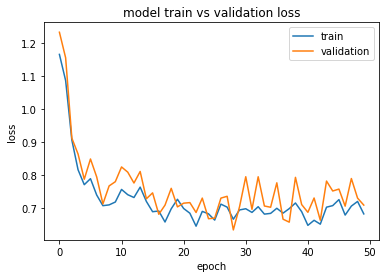

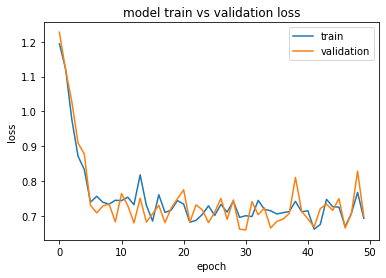

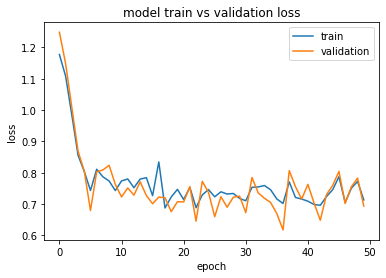

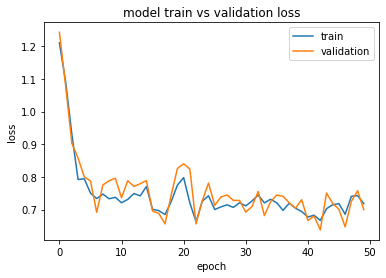

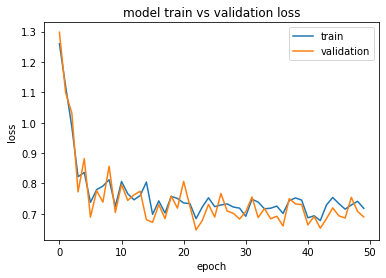

In [12]:
# plot train and validation loss
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

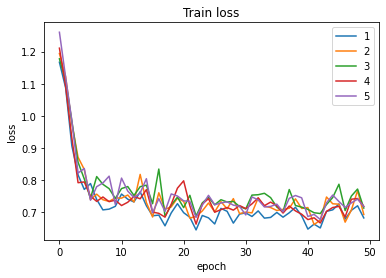

In [13]:
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

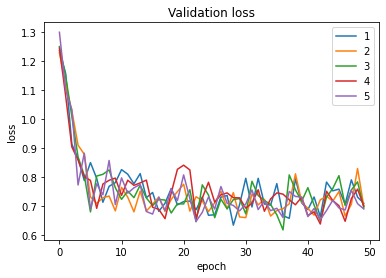

In [14]:
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

In [15]:
result_record_f1 = pd.DataFrame.from_dict(data=result_f1, orient='index')
result_record_f1 = np.mean(np.array(result_record_f1), axis = 0)
result_record_f1 = result_record_f1.reshape(-1)

result_record_acc = pd.DataFrame.from_dict(data=result_acc, orient='index')
result_record_acc = np.mean(np.array(result_record_acc), axis = 0)
result_record_acc = result_record_acc.reshape(-1)

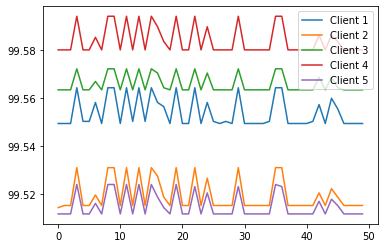

In [16]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_acc[i], label = 'Client '+ str(i+1))
plt.legend()
plt.show()

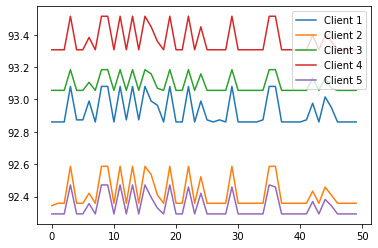

In [17]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_f1[i], label =  'Client '+ str(i+1))
plt.legend()
plt.show()